In [66]:
#Import

import numpy as np
import matplotlib.pyplot as plt
from multipole_signal import Derivatives
from getdist import plots
from getdist.gaussian_mixtures import GaussianND
import fishermat as fm
import pickle as pk

#Set current directory
import os
import sys

PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(SCRIPT_DIR)
print(SCRIPT_DIR)

#Configuration
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/danielsb/Documents/GitHub


In [67]:
# Redshift bins

z_bins = np.array([ 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95 ])

#z_bins = np.array([ 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45 ])


# Separations

dist = [
    np.arange(20, 164, 4),
    np.arange(32, 164, 4),
]

params_dict0 = {
    'h' : 0.6766,
    'As' : 2.05e-9,
    'ns' : 0.9665,
    'Ob' : 0.04897, # This is here the density parameter of Baryons
    'Om' : 0.3111, # This is here the density parameter of Cold Dark Matter
}

steps = [1e-3, 1e-1, 1e-4, 1e-2, 1e-2]

# JOINT ANALYSIS. 

### 50x50 vs 30x70 SPLITTINGS.

We run the analysis combining two different population splittings, combining the information as if they were two independent experiments. We include the cross correlations between the observables but assume the parameters of each population are independent. The signal looks like:

$$ \vec{\xi}(z,d) = (\{\xi_l^{\mathrm{LM}}(z,d)\}_{l=0,1,2,4}, \{\xi_l^{\mathrm{NP}}(z,d)\}_{l=0,1,2,4}) $$



## Derivatives (LOAD FROM FILE)

In [68]:
with open('derivatives.pkl', 'rb') as File:
    derivatives_dict = pk.load(File)
    
derivatives_50x50 = derivatives_dict['split_50x50']
derivatives_30x70 = derivatives_dict['split_30x70']

In [69]:
dsignal_dsbias50 = derivatives_50x50['dsignal_dsbias']

dsignal_dgbias50 = derivatives_50x50['dsignal_dgbias']

dsignal_dcosmic50 = derivatives_50x50['dsignal_dcosmic']

dsignal_dnum50 = derivatives_50x50['dsignal_dnumev']

np.shape(dsignal_dsbias50), np.shape(dsignal_dgbias50), np.shape(dsignal_dcosmic50), np.shape(dsignal_dnum50)

((8, 19, 324), (4, 19, 324), (5, 19, 324), (4, 19, 324))

In [70]:
dsignal_dsbias30 = derivatives_30x70['dsignal_dsbias']

dsignal_dgbias30 = derivatives_30x70['dsignal_dgbias']

dsignal_dcosmic30 = derivatives_30x70['dsignal_dcosmic']

dsignal_dnum30 = derivatives_30x70['dsignal_dnumev']

np.shape(dsignal_dsbias30), np.shape(dsignal_dgbias30), np.shape(dsignal_dcosmic30), np.shape(dsignal_dnum30)

((8, 19, 324), (4, 19, 324), (5, 19, 324), (4, 19, 324))

In [71]:
dsignal_dtheta50 = np.concatenate([dsignal_dsbias50, dsignal_dnum50, dsignal_dgbias50, dsignal_dcosmic50])

np.shape(dsignal_dtheta50)

(21, 19, 324)

In [72]:
dsignal_dtheta30 = np.concatenate([dsignal_dsbias30, dsignal_dnum30, dsignal_dgbias30, dsignal_dcosmic30])

np.shape(dsignal_dtheta30)

(21, 19, 324)

In [73]:
dsignal_dsB50 = np.concatenate([dsignal_dsbias50[:4], np.zeros_like(dsignal_dsbias50[:4])], axis=2)
dsignal_dsB30 = np.concatenate([np.zeros_like(dsignal_dsbias30[:4]), dsignal_dsbias30[:4]], axis=2)

dsignal_dsM = np.concatenate([dsignal_dsbias50[4:], dsignal_dsbias30[4:]], axis=2)
dsignal_dnum = np.concatenate([dsignal_dnum50, dsignal_dnum30], axis=2)
dsignal_dgbias50_ = np.concatenate([dsignal_dgbias50, np.zeros_like(dsignal_dgbias30[:4])], axis=2)
dsignal_dgbias30_ = np.concatenate([np.zeros_like(dsignal_dgbias50[:4]), dsignal_dgbias30], axis=2)
dsignal_dcosmic = np.concatenate([dsignal_dcosmic50, dsignal_dcosmic30], axis=2)

In [74]:
dsignal_dtheta_multi_ = np.concatenate([dsignal_dsB50, dsignal_dsB30, dsignal_dsM, dsignal_dnum, dsignal_dgbias50_, dsignal_dgbias30_, dsignal_dcosmic])

np.shape(dsignal_dtheta_multi_)

(29, 19, 648)

In [75]:
648-36

612

In [76]:
nind=list(range(288,324))+list(range(612, 648))

In [77]:
dsignal_dtheta_multi = np.delete(arr=dsignal_dtheta_multi_, obj=nind, axis=2)

np.shape(dsignal_dtheta_multi)

(29, 19, 576)

In [78]:
288 * 2

576

## Covariance Matrix

In [79]:
# Create the PRIORS Cov Matrix for sB, sM, num

errB = [5e-1, 5e-1] 
errF = [5e-1, 5e-1]

num_fit = np.array([7.94599872, -12.03752386, 2.29927261, -15.83887364])

sB_4fit50 = np.array([-0.90110745,  1.82300205, -1.01878441, -0.30342325])
sB_4fit30 = np.array([0.32517601, 0.64417733, 0.16141876, 0.13330362])

sM_4fit = np.array([-0.19376092,  1.07473357, -0.07806244, -0.00558004])

dsB_50 = sB_4fit50 * errB[0] 
dsB_30 = sB_4fit30 * errB[0] 

dsM = sM_4fit * errF[0]

dnum = num_fit * errB[1]

Cov_prior_all = np.diag(np.concatenate([dsB_50**2, dsB_30**2, dsM**2, dnum**2]))

Inv_Cov_prior_all_ = np.linalg.inv(Cov_prior_all)

Inv_Cov_prior_all = np.zeros([len(dsignal_dtheta_multi), len(dsignal_dtheta_multi)])
Inv_Cov_prior_all[:len(Inv_Cov_prior_all_), :len(Inv_Cov_prior_all_)] = Inv_Cov_prior_all_

np.shape(Cov_prior_all), np.shape(Inv_Cov_prior_all)

((16, 16), (29, 29))

In [80]:
def inverse_cov_matrix_joint(d, z_bins, pixel_size = 4, small_off_diagonal = True, rtol = 1e-4, splits=[50,30]):
    
    d_min = d[0]
    d_max = d[-1]
    
    print('\n ... Loading Covariance Matrices (Joint-splittings Analysis) [MONO-BB, MONO-BF, MONO-FF, DIP-BF, QUAD-BB, QUAD-BF, QUAD-FF, HEXA-T] ... \n')
    
    CovMatrix = [np.loadtxt('Covariance/multi_split/CovarianceMatrix_multi_'+str(splits[0])+'x'+str(splits[1])+'_at_z'+str(z)+'_d'+str(int(d_min))+'to160.txt') for z in z_bins]
            
    if not small_off_diagonal: 
        print('\n ... Removing small off-diagonal terms vs diagonal terms ... \n')
        print(f'\n Relative difference = {rtol} \n')
        
        for n, z in enumerate(z_bins):
            Matrix = np.copy(CovMatrix[n])
            value = Matrix / np.sqrt(np.outer(np.diag(Matrix), np.diag(Matrix)))
            Matrix[np.where(value <= rtol)] = 0.0
            CovMatrix[n] = Matrix
            
    print('\n ... Computing the Inverse [MONO-BB, MONO-BF, MONO-FF, DIP-BF, QUAD-BB, QUAD-BF, QUAD-FF, HEXA-T] ... \n')
            
    InvCovMatrix = [np.linalg.inv(CovMatrix[i]) for i,_ in enumerate(z_bins)]
    
    print('\n ... Success! ... \n')
    
    return InvCovMatrix

In [81]:
# Load the Covariance Matrix of the multipoles

Inv_Cov_Multipoles_Joint50x30_ = inverse_cov_matrix_joint(d=dist[0], z_bins=z_bins, small_off_diagonal=True, splits=[50,30], rtol=1e-4)

# Symmetrize the matrix

Inv_Cov_Multipoles_Joint50x30 = [0.5 * (Inv_Cov_Multipoles_Joint50x30_[i] + Inv_Cov_Multipoles_Joint50x30_[i].T) for i in range(len(z_bins))]

np.shape(Inv_Cov_Multipoles_Joint50x30)


 ... Loading Covariance Matrices (Joint-splittings Analysis) [MONO-BB, MONO-BF, MONO-FF, DIP-BF, QUAD-BB, QUAD-BF, QUAD-FF, HEXA-T] ... 


 ... Computing the Inverse [MONO-BB, MONO-BF, MONO-FF, DIP-BF, QUAD-BB, QUAD-BF, QUAD-FF, HEXA-T] ... 


 ... Success! ... 



(19, 576, 576)

In [82]:
# Build the Fisher Matrix

Fisher_Matrix_Joint50x30_ = fm.fisher_matrix(d_signal = dsignal_dtheta_multi, inv_cov = Inv_Cov_Multipoles_Joint50x30_, z_bins = z_bins)
Fisher_Matrix_Joint50x30 = Fisher_Matrix_Joint50x30_ + Inv_Cov_prior_all

np.shape(Fisher_Matrix_Joint50x30)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(29, 29)

In [83]:
print(np.allclose(Fisher_Matrix_Joint50x30, Fisher_Matrix_Joint50x30.T, rtol=1e-8))

False


In [84]:
np.linalg.det(Fisher_Matrix_Joint50x30)

-8.135967001381427e+129

## Constraints

In [85]:
#Absolute Errors

Sigma_Matrix_Joint50x30 = np.linalg.inv(Fisher_Matrix_Joint50x30)

Abs_Errors_all_Joint = np.sqrt(np.diag(Sigma_Matrix_Joint50x30))

# Fiducial values

sB_fit = np.concatenate([sB_4fit50, sB_4fit30]) 
gbias_fit = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783]), np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid = np.concatenate([sB_fit, sM_4fit, num_fit, gbias_fit, cosmic_fid])

# Relative errors

Rel_Errors_all_Joint = np.abs(Abs_Errors_all_Joint/params_fid)

par_errors_all_Joint = Rel_Errors_all_Joint * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB_50 = ', par_errors_all_Joint[0:int(len(sB_fit)/2)])
print()
print('sB_30 = ', par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)])
print()
print('s_model = ', par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)])
print()
print('number = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))])
print()
print('gbias_50 = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))])
print()
print('gbias_30 = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))])
print()
print('cosmic = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))])
print()


------------ Relative errors * 100 ------------

sB_50 =  [26.4960613  15.88628609 21.29706496 20.82439574]

sB_30 =  [36.49101735 39.10834852 43.61135568 23.16513089]

s_model =  [37.46526344 20.44194796 44.43217339 49.91930206]

number =  [39.82484281 36.80087907 29.58998331 29.41338012]

gbias_50 =  [0.1103624  0.27221772 0.10376287 0.22133884]

gbias_30 =  [0.12423027 0.31386849 0.09177415 0.20125014]

cosmic =  [2.04220945 1.12901347 1.76162752 1.98636581 0.65135688]



In [86]:
print(np.allclose(Sigma_Matrix_Joint50x30, Sigma_Matrix_Joint50x30.T, rtol=1e-20))

False


In [87]:
np.linalg.det(Sigma_Matrix_Joint50x30)

-1.2291101965301444e-130

In [88]:
def isPSD(A, tol=1e-4):
    E = np.linalg.eigvals(A)
    return E, np.all(E > -tol)

# Example usage:
# Your matrix
A = np.array([[1, 2], [2, 4]])
# Check if A is positive semi-definite
print(isPSD(A))

(array([0., 5.]), True)


In [89]:
print(isPSD(Fisher_Matrix_Joint50x30, tol=1e-10))

(array([ 3.45910818e+11,  2.84232534e+09,  2.64538389e+08, -7.40534921e+07,
        7.78596360e+07,  1.24124190e+07,  8.65806415e+06,  4.58872655e+06,
        1.30575200e+06,  7.55623176e+05,  5.46834347e+05,  2.39422525e+05,
        1.24115678e+05,  7.94032390e+04,  9.14024493e+04,  3.27858185e+04,
        2.41894968e+04,  1.17619236e+04,  1.84472388e+03,  6.10039125e+02,
        3.89173807e+02,  3.27784205e+02,  7.56180582e+01,  2.36999370e+01,
        6.95265009e+00,  4.69026157e+00,  7.45813004e-01,  3.41039674e-02,
        4.74983924e-02]), False)


In [90]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Fisher_Matrix_Joint50x30)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("Condition number of A:", condition_number)

Singular values of A: [3.45910818e+11 2.84232534e+09 2.64541984e+08 7.79796321e+07
 7.45416859e+07 1.27160632e+07 8.41876154e+06 4.58816622e+06
 1.30609734e+06 7.55622819e+05 5.45482016e+05 2.39428933e+05
 1.26328965e+05 9.06663320e+04 7.94017652e+04 3.27965762e+04
 2.41902685e+04 1.17626697e+04 1.84525664e+03 6.03085545e+02
 3.88934020e+02 3.27735320e+02 7.56173673e+01 2.36999300e+01
 6.95264449e+00 4.69026128e+00 7.45812971e-01 4.74983925e-02
 3.41039674e-02]
Condition number of A: 10142832174822.793


In [91]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Fisher_Matrix_Joint50x30.shape[0], Fisher_Matrix_Joint50x30.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Fisher_Matrix_Joint50x30 @ A_plus

In [92]:
np.allclose(A_plus, Sigma_Matrix_Joint50x30, rtol=1e-20)

False

In [93]:
np.diag(A_plus)

array([5.70053743e-02, 8.38724002e-02, 4.70764920e-02, 3.99247797e-03,
       1.40802037e-02, 6.34672714e-02, 4.95572488e-03, 9.53571810e-04,
       5.26974933e-03, 4.82665420e-02, 1.20303803e-03, 7.75910508e-06,
       1.00139432e+01, 1.96241433e+01, 4.62882084e-01, 2.17039340e+01,
       3.73819371e-07, 4.54314185e-06, 3.30448267e-07, 3.00357702e-06,
       4.73668391e-07, 6.03975000e-06, 2.58499814e-07, 2.48310960e-06,
       1.90925769e-04, 1.16287847e-03, 2.89889102e-04, 9.46190694e-07,
       4.10618049e-06])

## Triangle Plots

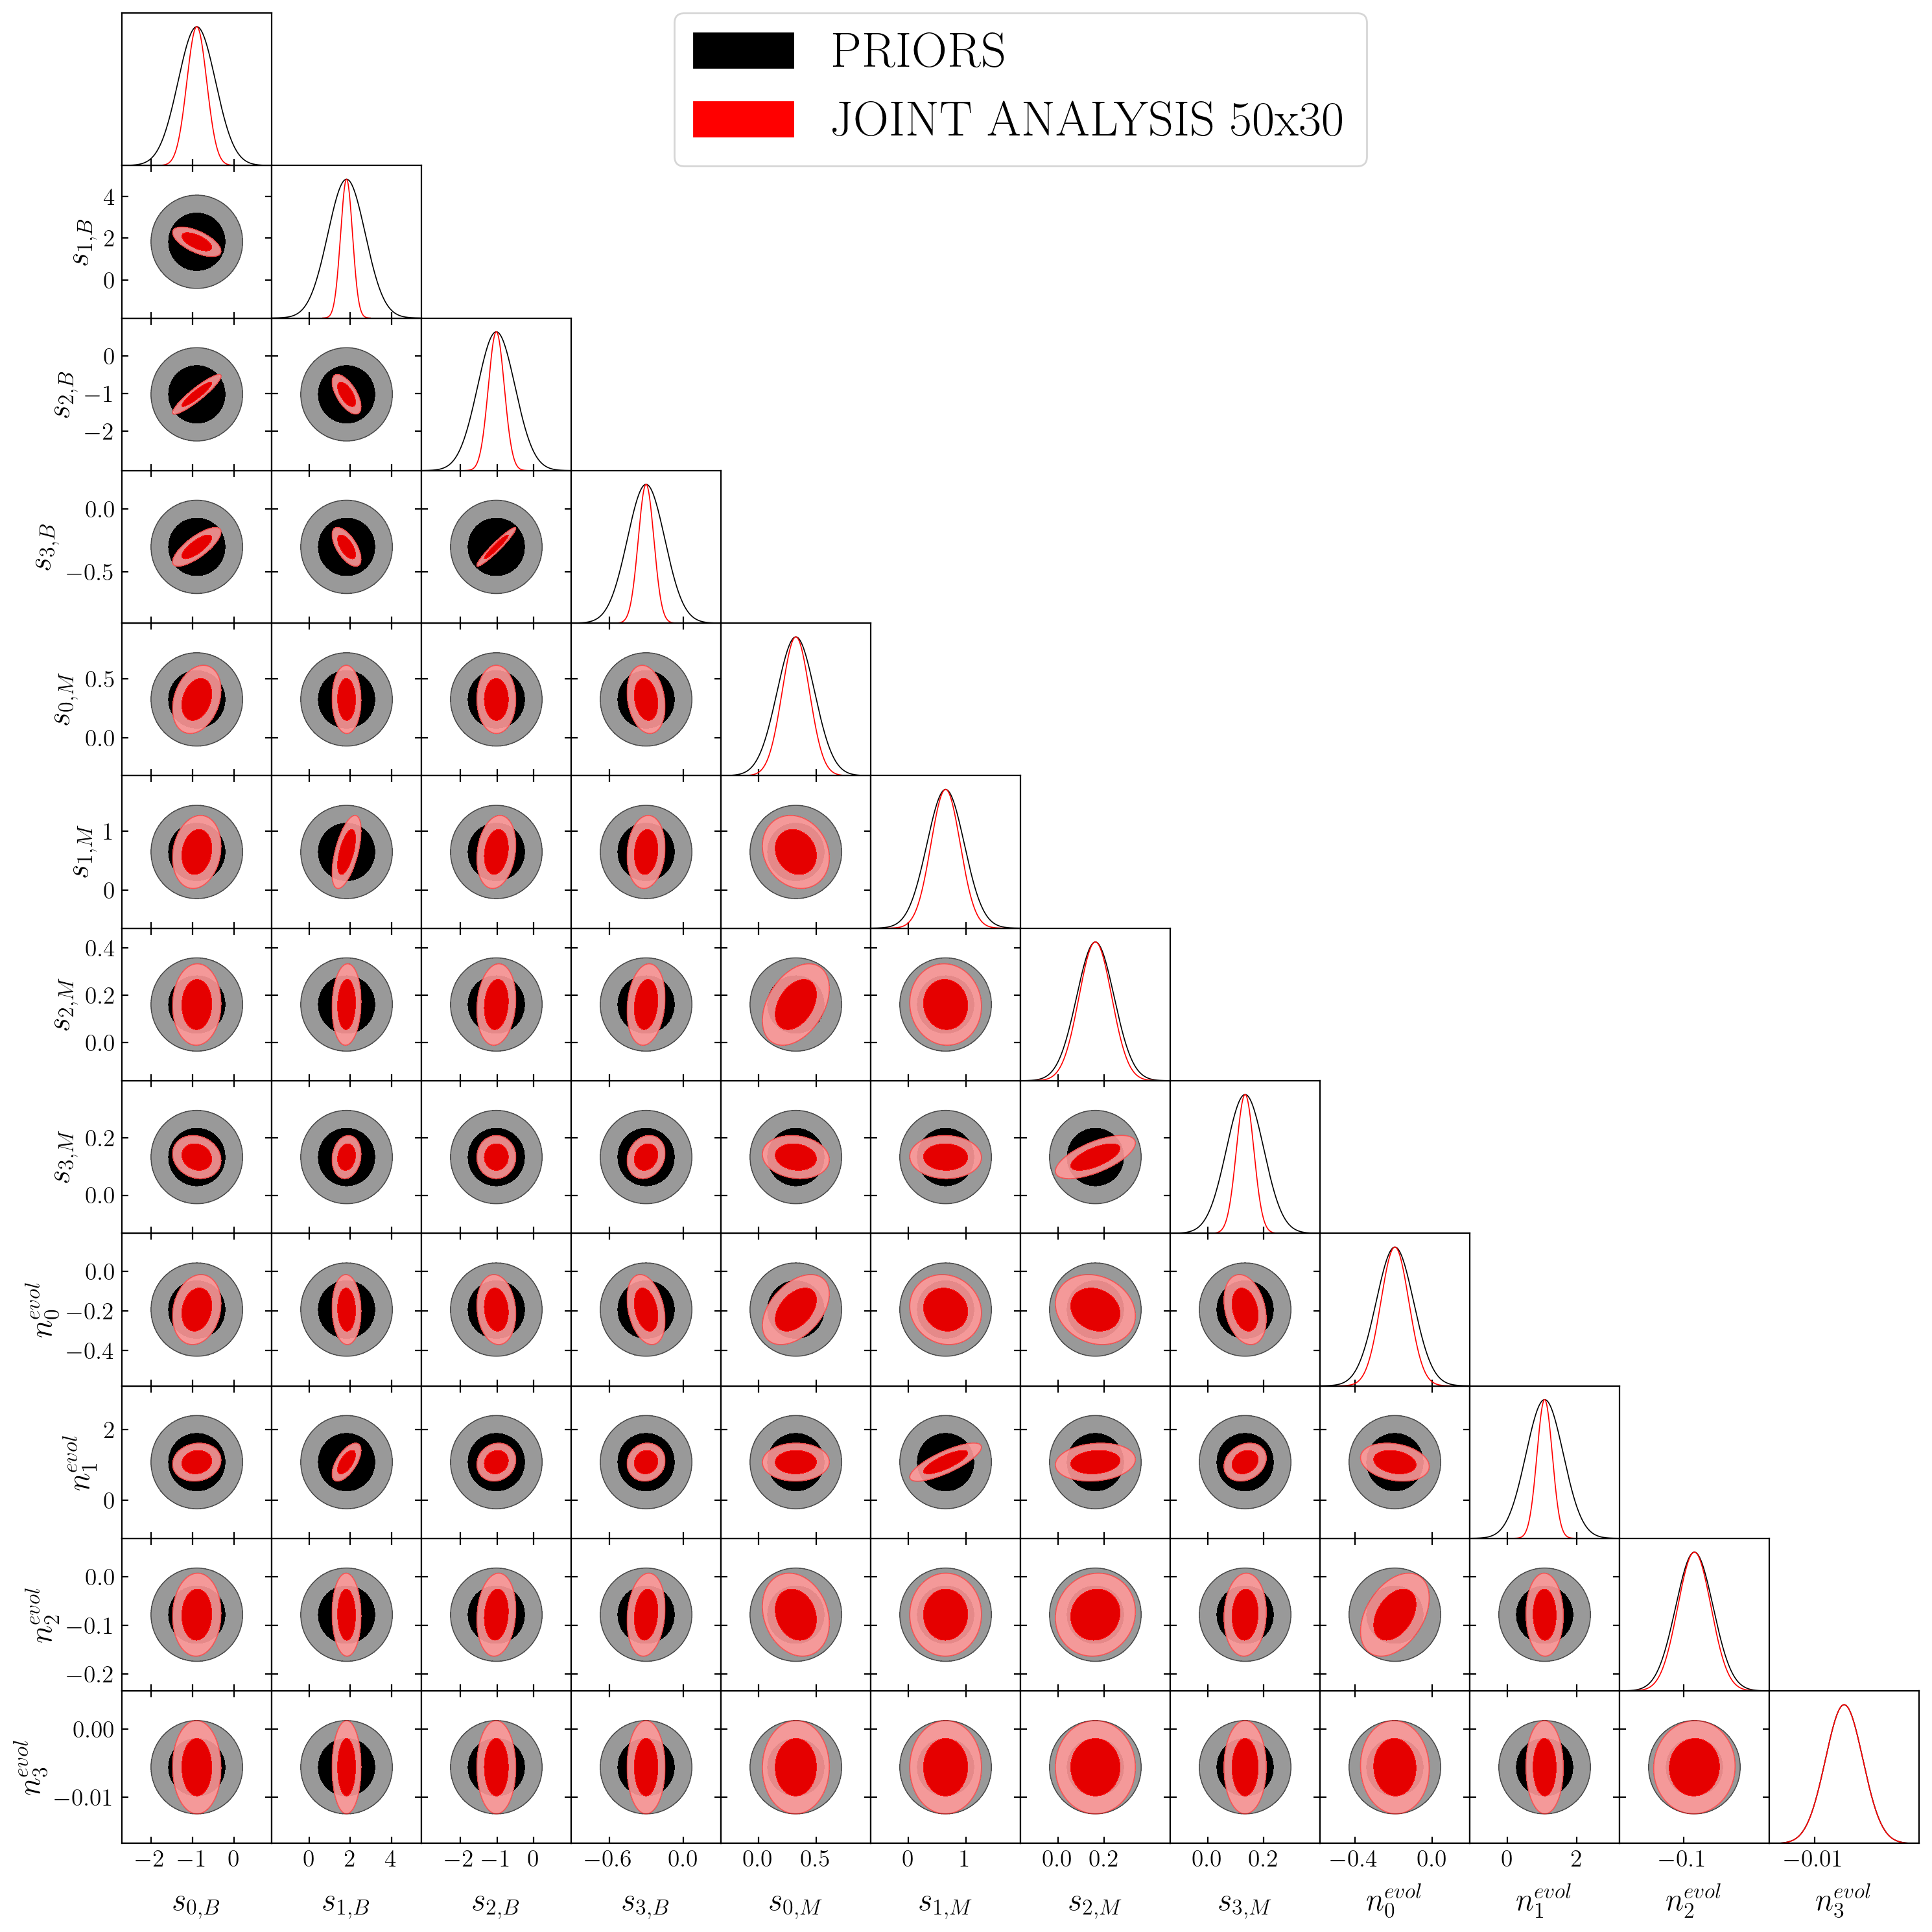

In [94]:
# Triangle plot

mean = params_fid[:-13]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit30))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_sbias_nevol_fit = GaussianND(mean, Sigma_Matrix_Joint50x30[:-13,:-13], labels = labels, names = param_names)
GaussDist_priors_sbias_nevol_fit = GaussianND(mean, Cov_prior_all, labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_priors_sbias_nevol_fit, GaussDist_sbias_nevol_fit], param_names, 
                filled=True, 
                legend_labels=['PRIORS', 'JOINT ANALYSIS 50x30'],
                contour_colors=['black', 'red'])

/Users/danielsb/opt/anaconda3/envs/camb/lib/python3.9/site-packages/getdist/gaussian_mixtures.py:39: RuntimeWarning: invalid value encountered in sqrt
  self.norms = (2 * np.pi) ** (0.5 * self.dim) * np.array([np.sqrt(np.linalg.det(cov)) for cov in self.covs])


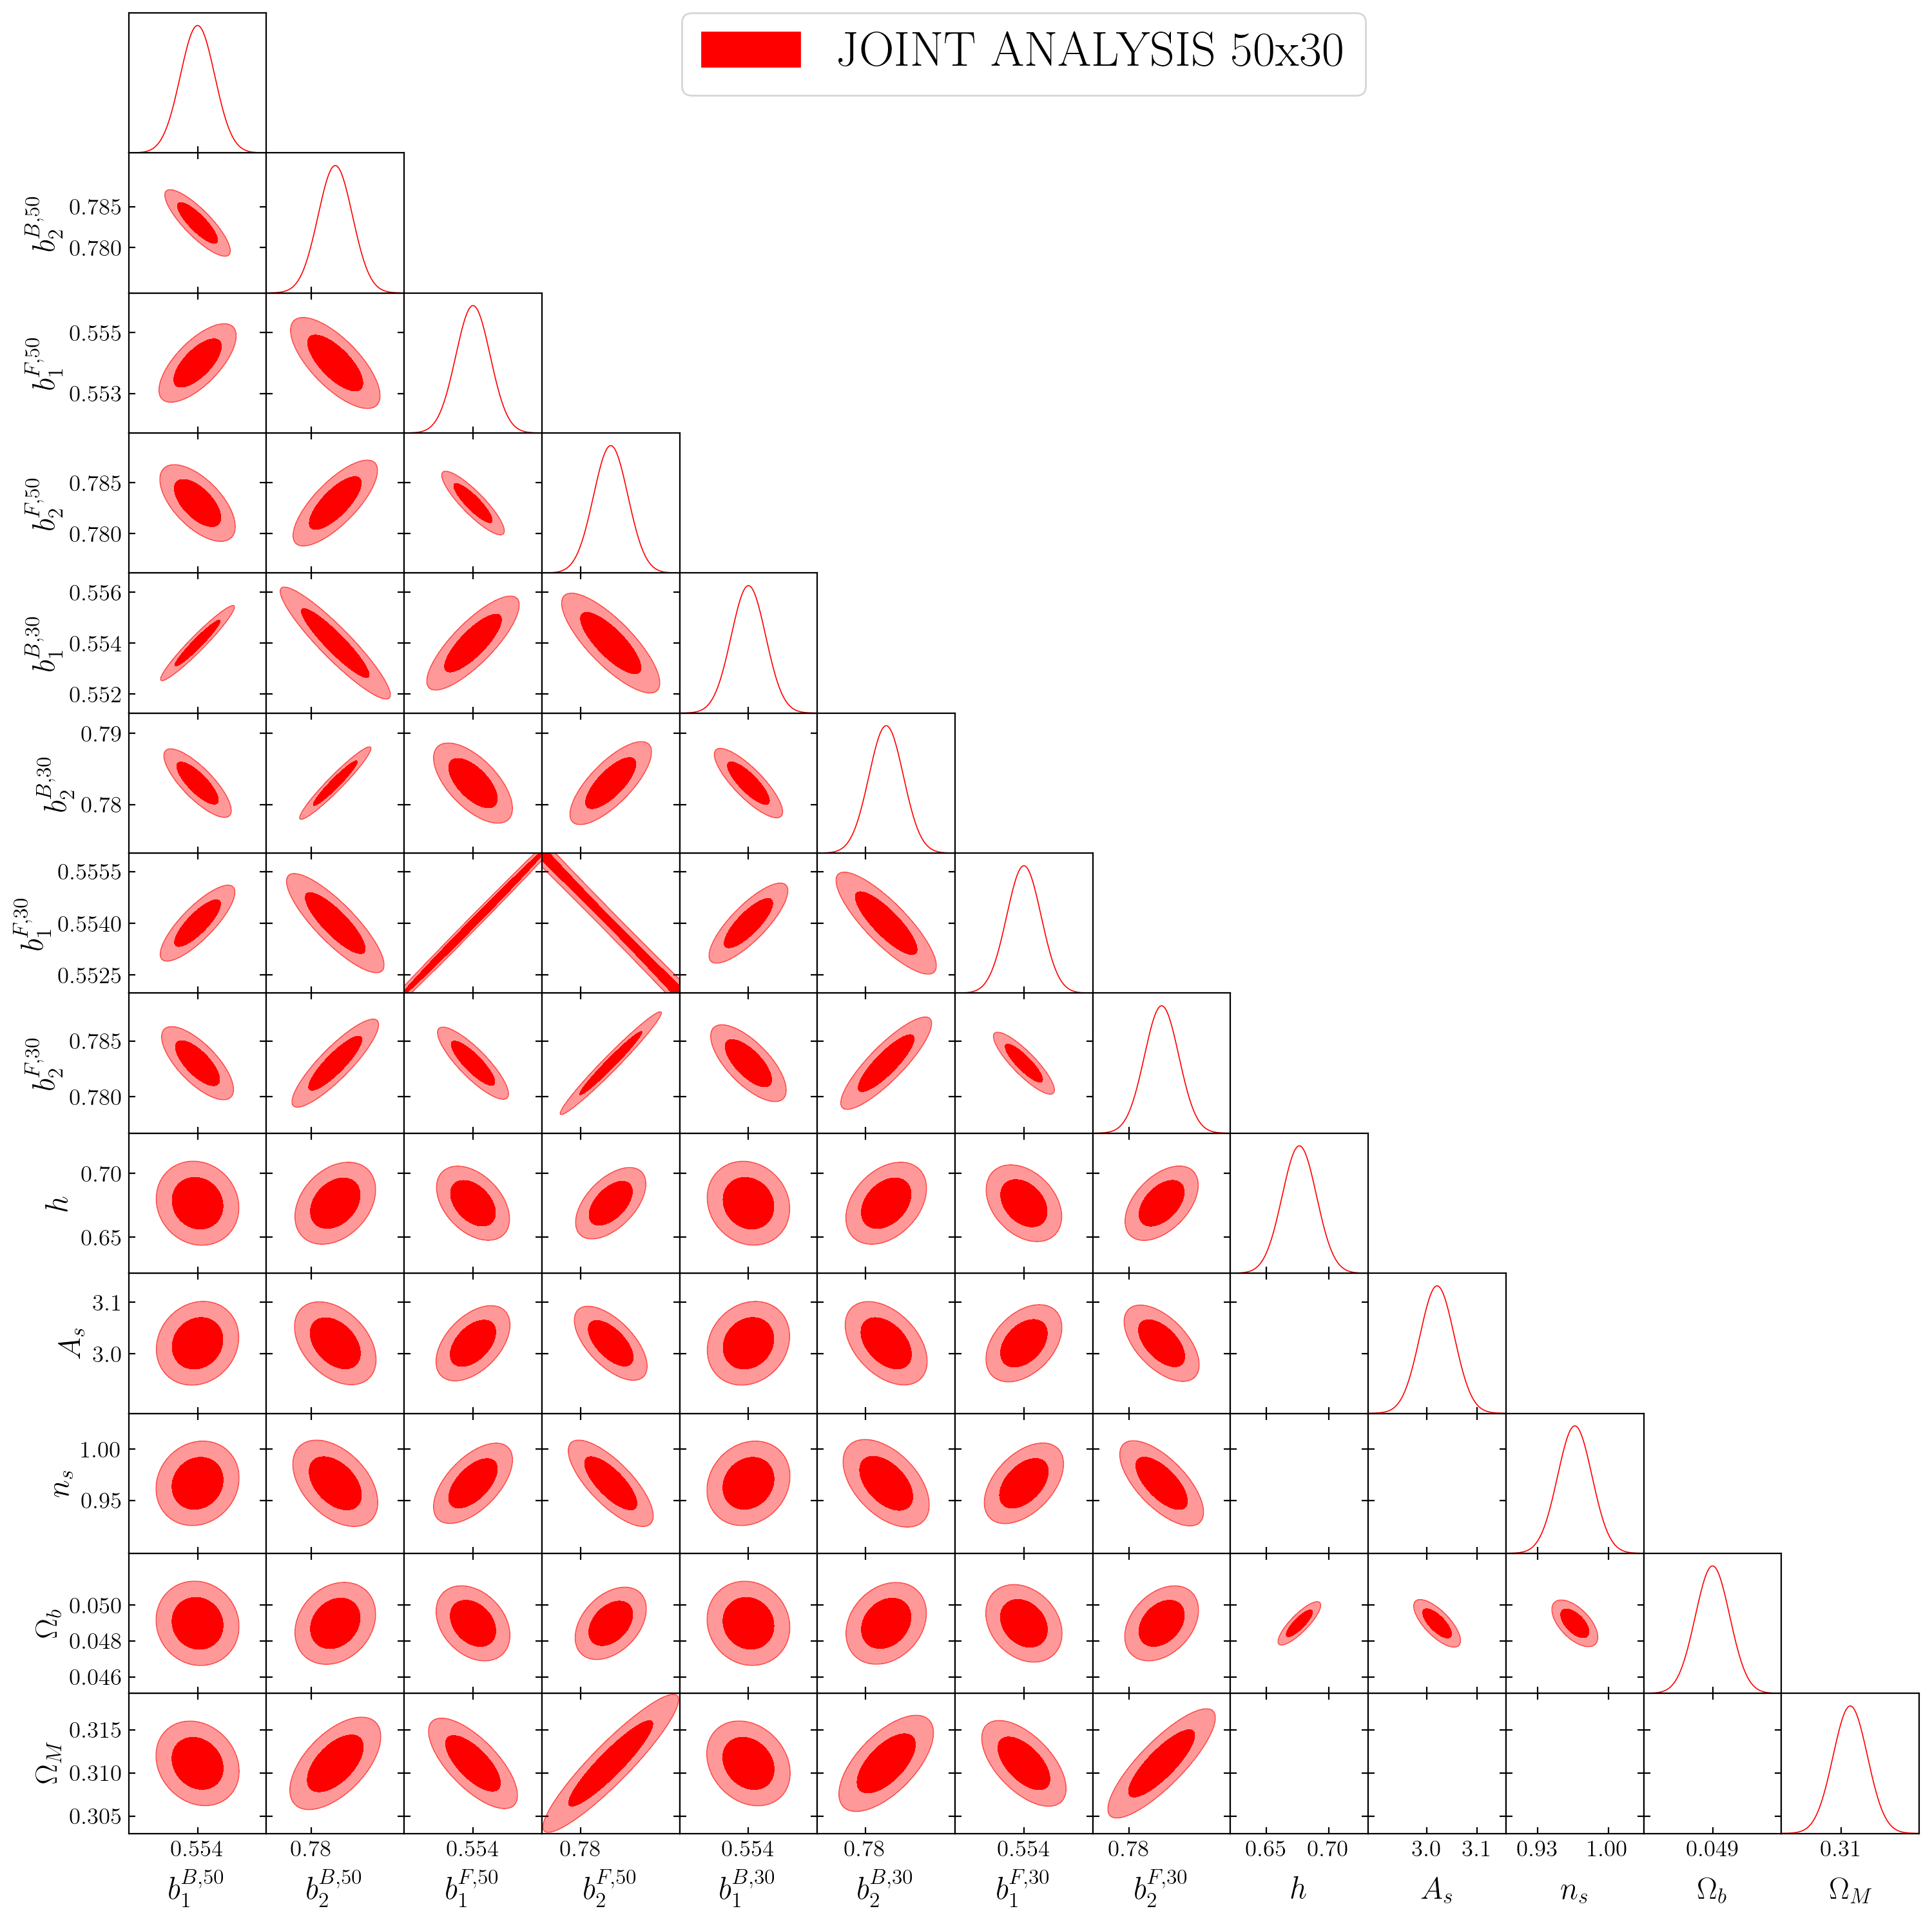

In [95]:
# Triangle plot: GALAXY BIAS AND COSMIC PARAMETERS

mean = params_fid[16:]

gbias_names = ['b1B_m1', 'b2B_m1', 'b1F_m1', 'b2F_m1'] + ['b1B_m2', 'b2B_m2', 'b1F_m2', 'b2F_m2']
cosmic_names = ['h', 'As', 'ns', 'Ob', 'OM']

gbias_labels = [r'b_1^{B,50}', r'b_2^{B,50}', r'b_1^{F,50}', r'b_2^{F,50}'] + [r'b_1^{B,30}', r'b_2^{B,30}', r'b_1^{F,30}', r'b_2^{F,30}']
cosmic_labels = [r'h', r'A_s', r'n_s', r'\Omega_b', r'\Omega_M']

param_names = gbias_names + cosmic_names
labels = gbias_labels + cosmic_labels

GaussDist_gbias_cosmic_fit = GaussianND(mean, Sigma_Matrix_Joint50x30[16:,16:], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot(GaussDist_gbias_cosmic_fit, param_names, 
                filled=True, 
                legend_labels=['JOINT ANALYSIS 50x30'],
                contour_colors=['red'])

# SINGLE SPLIT 

### $m = 2 \,\rightarrow\,$ $50\%$ Brigth - $50\%$ Faint

In [96]:
len(dsignal_dgbias50_[1,1])/2

324.0

In [97]:
dsignal_dtheta_fit_all50 = np.concatenate([dsignal_dsbias50[:,:,:-36], dsignal_dnum50[:,:,:-36], dsignal_dgbias50_[:,:,:288], dsignal_dcosmic50[:,:,:-36]])

np.shape(dsignal_dtheta_fit_all50)

(21, 19, 288)

In [98]:
# Create the Cov Matrix for sB, sF, num

Cov_priors_50 = np.diag(np.concatenate([dsB_50**2, dsM**2, dnum**2]))

Inv_Cov_prior_50_ = np.linalg.inv(Cov_priors_50)

Inv_Cov_prior_50 = np.zeros([len(dsignal_dtheta_fit_all50), len(dsignal_dtheta_fit_all50)])
Inv_Cov_prior_50[:len(Inv_Cov_prior_50_), :len(Inv_Cov_prior_50_)] = Inv_Cov_prior_50_

np.shape(Cov_priors_50)

(12, 12)

In [99]:
def inverse_cov_matrix_survey(d, z_bins, pixel_size = 4, small_off_diagonal = True, rtol = 1e-4, split=[50,50]):
    
    d_min = d[0]
    d_max = d[-1]
    
    print('\n ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT] ... \n')
    
    CovMatrix = [np.loadtxt('Covariance/multi_split/CovarianceMatrix_at_z'+str(z)+'_d'+str(int(d_min))+'to160_msplit-'+str(split[0])+'B_'+str(split[1])+'F.txt') for z in z_bins]
            
    if not small_off_diagonal:
        print('\n ... Removing small off-diagonal terms vs diagonal terms ... \n')
        print(f'\n Relative difference = {rtol} \n')
        for n, z in enumerate(z_bins):
            Matrix = np.copy(CovMatrix[n])
            r, c = np.shape(Matrix)
            for i in np.arange(r):
                for j in np.arange(c):
                    value = Matrix[i,j]/np.sqrt(Matrix[i,i] * Matrix[j,j])
                    if value <= rtol:
                        Matrix[i,j] = 0.
                    else: 
                        Matrix[i,j] = Matrix[i,j]
            CovMatrix[n] = Matrix
            
    print('\n ... Computing the Inverse [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT] ... \n')
            
    InvCovMatrix = [np.linalg.inv(CovMatrix[i]) for i,_ in enumerate(z_bins)]
    
    return InvCovMatrix

In [100]:
# Fisher Matrix + prior

Inv_Cov_Multipoles_50 = inverse_cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[50, 50], small_off_diagonal = True)

Fisher_Matrix_50_ = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all50, inv_cov = Inv_Cov_Multipoles_50, z_bins = z_bins)

Fisher_Matrix_50 = Fisher_Matrix_50_ + Inv_Cov_prior_50

np.shape(Fisher_Matrix_50)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT] ... 


 ... Computing the Inverse [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT] ... 


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

In [101]:
print(np.allclose(Fisher_Matrix_50, Fisher_Matrix_50.T, rtol=1e-11))

True


In [102]:
np.linalg.det(Fisher_Matrix_50)

1.0503372258674591e+76

In [103]:
Sigma_Matrix_50 = np.linalg.inv(Fisher_Matrix_50)

#Absolute Errors

Abs_Errors_all_50 = np.sqrt(np.diag(Sigma_Matrix_50))

# Fiducial values

sbias_fit_50 = np.concatenate([sB_4fit50, sM_4fit])
gbias_fit_50 = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid_50 = np.concatenate([sbias_fit_50, num_fit, gbias_fit_50, cosmic_fid])

# Relative errors

Rel_Errors_all_50 = np.abs(Abs_Errors_all_50/params_fid_50)

par_errors_all_50 = Rel_Errors_all_50 * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB = ', par_errors_all_50[0:int(len(sbias_fit_50)/2)])
print()
print('smodel = ', par_errors_all_50[int(len(sbias_fit_50)/2):len(sbias_fit_50)])
print()
print('number = ', par_errors_all_50[len(sbias_fit_50):(len(sbias_fit_50) + len(num_fit))])
print()
print('gbias = ', par_errors_all_50[(len(sbias_fit_50) + len(num_fit)):(len(sbias_fit_50) + len(num_fit) + len(gbias_fit_50))])
print()
print('cosmic = ', par_errors_all_50[(len(sbias_fit_50) + len(num_fit)+len(gbias_fit_50)):])


------------ Relative errors * 100 ------------

sB =  [36.69556914 21.54677319 26.55002325 26.50668432]

smodel =  [47.75752199 32.7137266  49.26867547 49.985239  ]

number =  [44.8630439  44.08925726 40.32536604 33.4091446 ]

gbias =  [0.25910432 0.38875445 0.23708902 0.30781126]

cosmic =  [1.32322219 0.74761806 1.11330049 1.39710716 0.55647449]


In [104]:
print(np.allclose(Sigma_Matrix_50, Sigma_Matrix_50.T, rtol=1e-20))

True


In [105]:
np.linalg.det(Sigma_Matrix_50)

9.520751767812855e-77

In [106]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Fisher_Matrix_50)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("Condition number of A:", condition_number)

Singular values of A: [9.80875246e+07 7.54086493e+07 5.29236311e+06 1.89711689e+06
 1.15027062e+06 3.28709353e+05 2.68739633e+05 1.09964830e+05
 9.02619321e+04 8.03967008e+04 6.26920254e+04 1.61434902e+04
 1.43011086e+03 6.59650471e+02 1.68149675e+02 7.29164156e+00
 5.50946585e+00 2.22918702e+00 1.08379436e-01 3.77408549e-02
 2.96606284e-02]
Condition number of A: 3306994154.658424


In [107]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Fisher_Matrix_50.shape[0], Fisher_Matrix_50.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Fisher_Matrix_50 @ A_plus

In [108]:
np.allclose(A_plus, Sigma_Matrix_50, rtol=1e-20)

True

# SINGLE SPLIT 

### $m = 10/3 \,\rightarrow\,$ $30\%$ Brigth - $70\%$ Faint

In [109]:
len(dsignal_dgbias30_[1,1])/2

324.0

In [110]:
dsignal_dtheta_fit_all30 = np.concatenate([dsignal_dsbias30[:,:,:-36], dsignal_dnum30[:,:,:-36], dsignal_dgbias30_[:,:,324:-36], dsignal_dcosmic30[:,:,:-36]])

np.shape(dsignal_dtheta_fit_all30)

(21, 19, 288)

In [111]:
# Create the Cov Matrix for sB, sF, num

Cov_priors_30 = np.diag(np.concatenate([dsB_30**2, dsM**2, dnum**2]))

Inv_Cov_prior_30_ = np.linalg.inv(Cov_priors_30)

Inv_Cov_prior_30 = np.zeros([len(dsignal_dtheta_fit_all30), len(dsignal_dtheta_fit_all30)])
Inv_Cov_prior_30[:len(Inv_Cov_prior_30_), :len(Inv_Cov_prior_30_)] = Inv_Cov_prior_30_

np.shape(Cov_priors_30)

(12, 12)

In [112]:
# Fisher Matrix + prior

Inv_Cov_Multipoles_30 = inverse_cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[30, 70], small_off_diagonal = True)

Fisher_Matrix_30_ = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all30, inv_cov = Inv_Cov_Multipoles_30, z_bins = z_bins)

Fisher_Matrix_30 = Fisher_Matrix_30_ + Inv_Cov_prior_30

np.shape(Fisher_Matrix_50)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT] ... 


 ... Computing the Inverse [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT] ... 


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

In [113]:
np.allclose(Fisher_Matrix_30, Fisher_Matrix_30.T, rtol=1e-12)

False

In [114]:
np.linalg.det(Fisher_Matrix_30)

1.8680425530036296e+77

In [115]:
Sigma_Matrix_30 = np.linalg.inv(Fisher_Matrix_30)

#Absolute Errors

Abs_Errors_all_30 = np.sqrt(np.diag(Sigma_Matrix_30))

# Fiducial values

sbias_fit_30 = np.concatenate([sB_4fit30, sM_4fit])
gbias_fit_30 = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid_30 = np.concatenate([sbias_fit_30, num_fit, gbias_fit_30, cosmic_fid])

# Relative errors

Rel_Errors_all_30 = np.abs(Abs_Errors_all_30/params_fid_30)

par_errors_all_30 = Rel_Errors_all_30 * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB = ', par_errors_all_30[0:int(len(sbias_fit_30)/2)])
print()
print('smodel = ', par_errors_all_30[int(len(sbias_fit_30)/2):len(sbias_fit_30)])
print()
print('number = ', par_errors_all_30[len(sbias_fit_30):(len(sbias_fit_30) + len(num_fit))])
print()
print('gbias = ', par_errors_all_30[(len(sbias_fit_30) + len(num_fit)):(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30))])
print()
print('cosmic = ', par_errors_all_30[(len(sbias_fit_30) + len(num_fit)+len(gbias_fit_30)):])


------------ Relative errors * 100 ------------

sB =  [41.65245357 41.28480791 44.72117233 24.03684966]

smodel =  [47.95656665 21.43380836 49.53360227 49.97908041]

number =  [41.0230869  39.19387776 33.31660553 31.58054756]

gbias =  [0.28552224 0.40995657 0.21292883 0.268902  ]

cosmic =  [1.13281269 0.61852473 0.91846422 1.27840872 0.42128833]


In [116]:
np.allclose(Sigma_Matrix_30, Sigma_Matrix_30.T, rtol=1e-20)

True

In [117]:
np.linalg.det(Sigma_Matrix_30)

5.353197112094121e-78

In [118]:
# Perform Singular Value Decomposition

U, s, Vh = np.linalg.svd(Sigma_Matrix_30)

# s contains the singular values of A
print("Singular values of A:", s)

# Calculate the condition number
condition_number = s[0] / s[-1]
print("(Log)-Condition number of A:", np.log10(condition_number))

Singular values of A: [3.16762072e+01 2.18646651e+01 4.77889811e+00 2.29897865e-01
 7.90774855e-02 1.40279994e-02 4.91668673e-03 2.36063712e-03
 4.76162092e-04 1.26698392e-04 2.81560958e-05 2.03458756e-05
 1.48491776e-05 1.06960851e-05 5.10963515e-06 3.83883250e-06
 9.90142874e-07 3.87198053e-07 1.78518831e-07 9.57151681e-09
 7.74706648e-09]
(Log)-Condition number of A: 9.61159589276138


In [119]:
# Create Σ+ (the pseudo-inverse of the diagonal matrix Σ)
S_plus = np.zeros((Sigma_Matrix_30.shape[0], Sigma_Matrix_30.shape[1])).T
S_plus[:s.shape[0], :s.shape[0]] = np.linalg.inv(np.diag(s))

# Compute the pseudo-inverse of A
A_plus = Vh.T @ S_plus @ U.T

# Verify by multiplying with the original matrix A
identity_matrix = Sigma_Matrix_30 @ A_plus

In [120]:
determinant = np.prod(s)

print(f'The determinant of the Sigma Matrix is: {determinant}')

The determinant of the Sigma Matrix is: 5.353197112091218e-78


In [121]:
np.allclose(A_plus, Fisher_Matrix_30, rtol=1e-7)

True

Comparison with result of combined analysis

In [122]:
print()
print('------------ Relative errors * 100 ------------' )
print()
print('sB_50 = ', par_errors_all_Joint[0:int(len(sB_fit)/2)])
print()
print('sB_30 = ', par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)])
print()
print('s_model = ', par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)])
print()
print('number = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))])
print()
print('gbias_50 = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))])
print()
print('gbias_30 = ', par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))])
print()
print('cosmic = ', par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))])
print()


------------ Relative errors * 100 ------------

sB_50 =  [26.4960613  15.88628609 21.29706496 20.82439574]

sB_30 =  [36.49101735 39.10834852 43.61135568 23.16513089]

s_model =  [37.46526344 20.44194796 44.43217339 49.91930206]

number =  [39.82484281 36.80087907 29.58998331 29.41338012]

gbias_50 =  [0.1103624  0.27221772 0.10376287 0.22133884]

gbias_30 =  [0.12423027 0.31386849 0.09177415 0.20125014]

cosmic =  [2.04220945 1.12901347 1.76162752 1.98636581 0.65135688]



# Numerical comparison

In [123]:
cosmic50x50 = par_errors_all_50[(len(sbias_fit_50) + len(num_fit)+len(gbias_fit_50)):]
cosmic30x70 = par_errors_all_30[(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30)):]

cosmicjoint = par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+len(gbias_fit) + len(cosmic_fid))]

In [124]:
sm50x50 = par_errors_all_50[int(len(sbias_fit_50)/2):len(sbias_fit_50)]
sm30x70 = par_errors_all_30[int(len(sbias_fit_30)/2):len(sbias_fit_30)]

sB50x50 = par_errors_all_50[0:int(len(sbias_fit_50)/2)]
sB30x70 = par_errors_all_30[0:int(len(sbias_fit_30)/2)]

sB50joint = par_errors_all_Joint[0:int(len(sB_fit)/2)]
sB30joint = par_errors_all_Joint[int(len(sB_fit)/2):len(sB_fit)]

smjoint = par_errors_all_Joint[len(sB_fit):len(sB_fit)+len(sM_4fit)]

In [125]:
np.shape(par_errors_all_Joint)

(29,)

In [126]:
gbias50x50 = par_errors_all_50[(len(sbias_fit_50) + len(num_fit)):(len(sbias_fit_50) + len(num_fit) + len(gbias_fit_50))]
gbias30x70 = par_errors_all_30[(len(sbias_fit_30) + len(num_fit)):(len(sbias_fit_30) + len(num_fit) + len(gbias_fit_30))]

gbias50joint = par_errors_all_Joint[((len(sB_fit)+len(sM_4fit)+len(num_fit))):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)/2))]
gbias30joint = par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)+len(num_fit)+int(len(gbias_fit)/2)):((len(sB_fit)+len(sM_4fit)+len(num_fit))+int(len(gbias_fit)))]

In [127]:
num50x50 = par_errors_all_50[len(sbias_fit_50):(len(sbias_fit_50) + len(num_fit))]
num30x70 = par_errors_all_30[len(sbias_fit_30):(len(sbias_fit_30) + len(num_fit))]

numjoint = par_errors_all_Joint[(len(sB_fit)+len(sM_4fit)):(len(sB_fit)+len(sM_4fit)+len(num_fit))]

In [128]:
print('\n Difference Joint vs 50x50 \n')
print(' DsB = ', (1-sB50joint/sB50x50) * 100, '\n')
print(' Dgbias = ',  (1-gbias50joint/gbias50x50) * 100, '\n')
print(' Dsmodel = ', (1-smjoint/sm50x50) * 100, '\n')
print(' Dnum = ', (1-numjoint/num50x50) * 100, '\n')
print(' Dcosmic = ', (1-cosmicjoint/cosmic50x50) * 100, '\n')

print('\n Difference Joint vs 30x70 \n')
print(' DsB = ', (1-sB30joint/sB30x70) * 100, '\n')
print(' Dgbias = ',  (1-gbias30joint/gbias30x70) * 100, '\n')
print(' Dsmodel = ', (1-smjoint/sm30x70) * 100, '\n')
print(' Dnum = ', (1-numjoint/num30x70) * 100, '\n')
print(' Dcosmic = ', (1-cosmicjoint/cosmic30x70) * 100, '\n')


 Difference Joint vs 50x50 

 DsB =  [27.79493023 26.27069517 19.7851363  21.43719114] 

 Dgbias =  [57.40619028 29.97695235 56.234638   28.09267645] 

 Dsmodel =  [21.55107326 37.51262823  9.81658638  0.13191283] 

 Dnum =  [11.23018111 16.53096161 26.62191019 11.96009213] 

 Dcosmic =  [-54.33609403 -51.01474105 -58.23468526 -42.17705531 -17.05062776] 


 Difference Joint vs 30x70 

 DsB =  [12.39167391  5.27181667  2.48163587  3.62659326] 

 Dgbias =  [56.49015906 23.43859897 56.89914572 25.15855678] 

 Dsmodel =  [21.87667705  4.62755094 10.29892569  0.11960675] 

 Dnum =  [ 2.9209018   6.10554206 11.18547993  6.86234915] 

 Dcosmic =  [-80.27776927 -82.53327979 -91.80143158 -55.3779932  -54.61071229] 



In [129]:
print('\n Difference 50x50 vs 30x70 \n')
print(' DsB = ', (1-sB50x50/sB30x70) * 100, '\n')
print(' Dgbias = ',  (1-gbias50x50/gbias30x70) * 100, '\n')
print(' Dsmodel = ', (1-sm50x50/sm30x70) * 100, '\n')
print(' Dnum = ', (1-num50x50/num30x70) * 100, '\n')
print(' Dcosmic = ', (1-cosmic50x50/cosmic30x70) * 100, '\n')


 Difference 50x50 vs 30x70 

 DsB =  [ 11.9005821   47.80943818  40.63209468 -10.27520116] 

 Dgbias =  [  9.25249193   5.17179488 -11.34660378 -14.46968068] 

 Dsmodel =  [ 4.15051940e-01 -5.26267570e+01  5.34842595e-01 -1.23223375e-02] 

 Dnum =  [ -9.36047794 -12.49016372 -21.03683852  -5.79026387] 

 Dcosmic =  [-16.80856018 -20.87116696 -21.21326703  -9.28485814 -32.08875104] 



# Triangle Plots

In [130]:
np.shape(params_fid), np.shape(params_fid_50)

((29,), (21,))

In [131]:
# Delete rows and columns alien to the 50x50 split

nind = list(range(4,8))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(25, 25)

In [132]:
# Delete elements of params_fid

params_fid_ = params_fid[:-13]

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(12,)

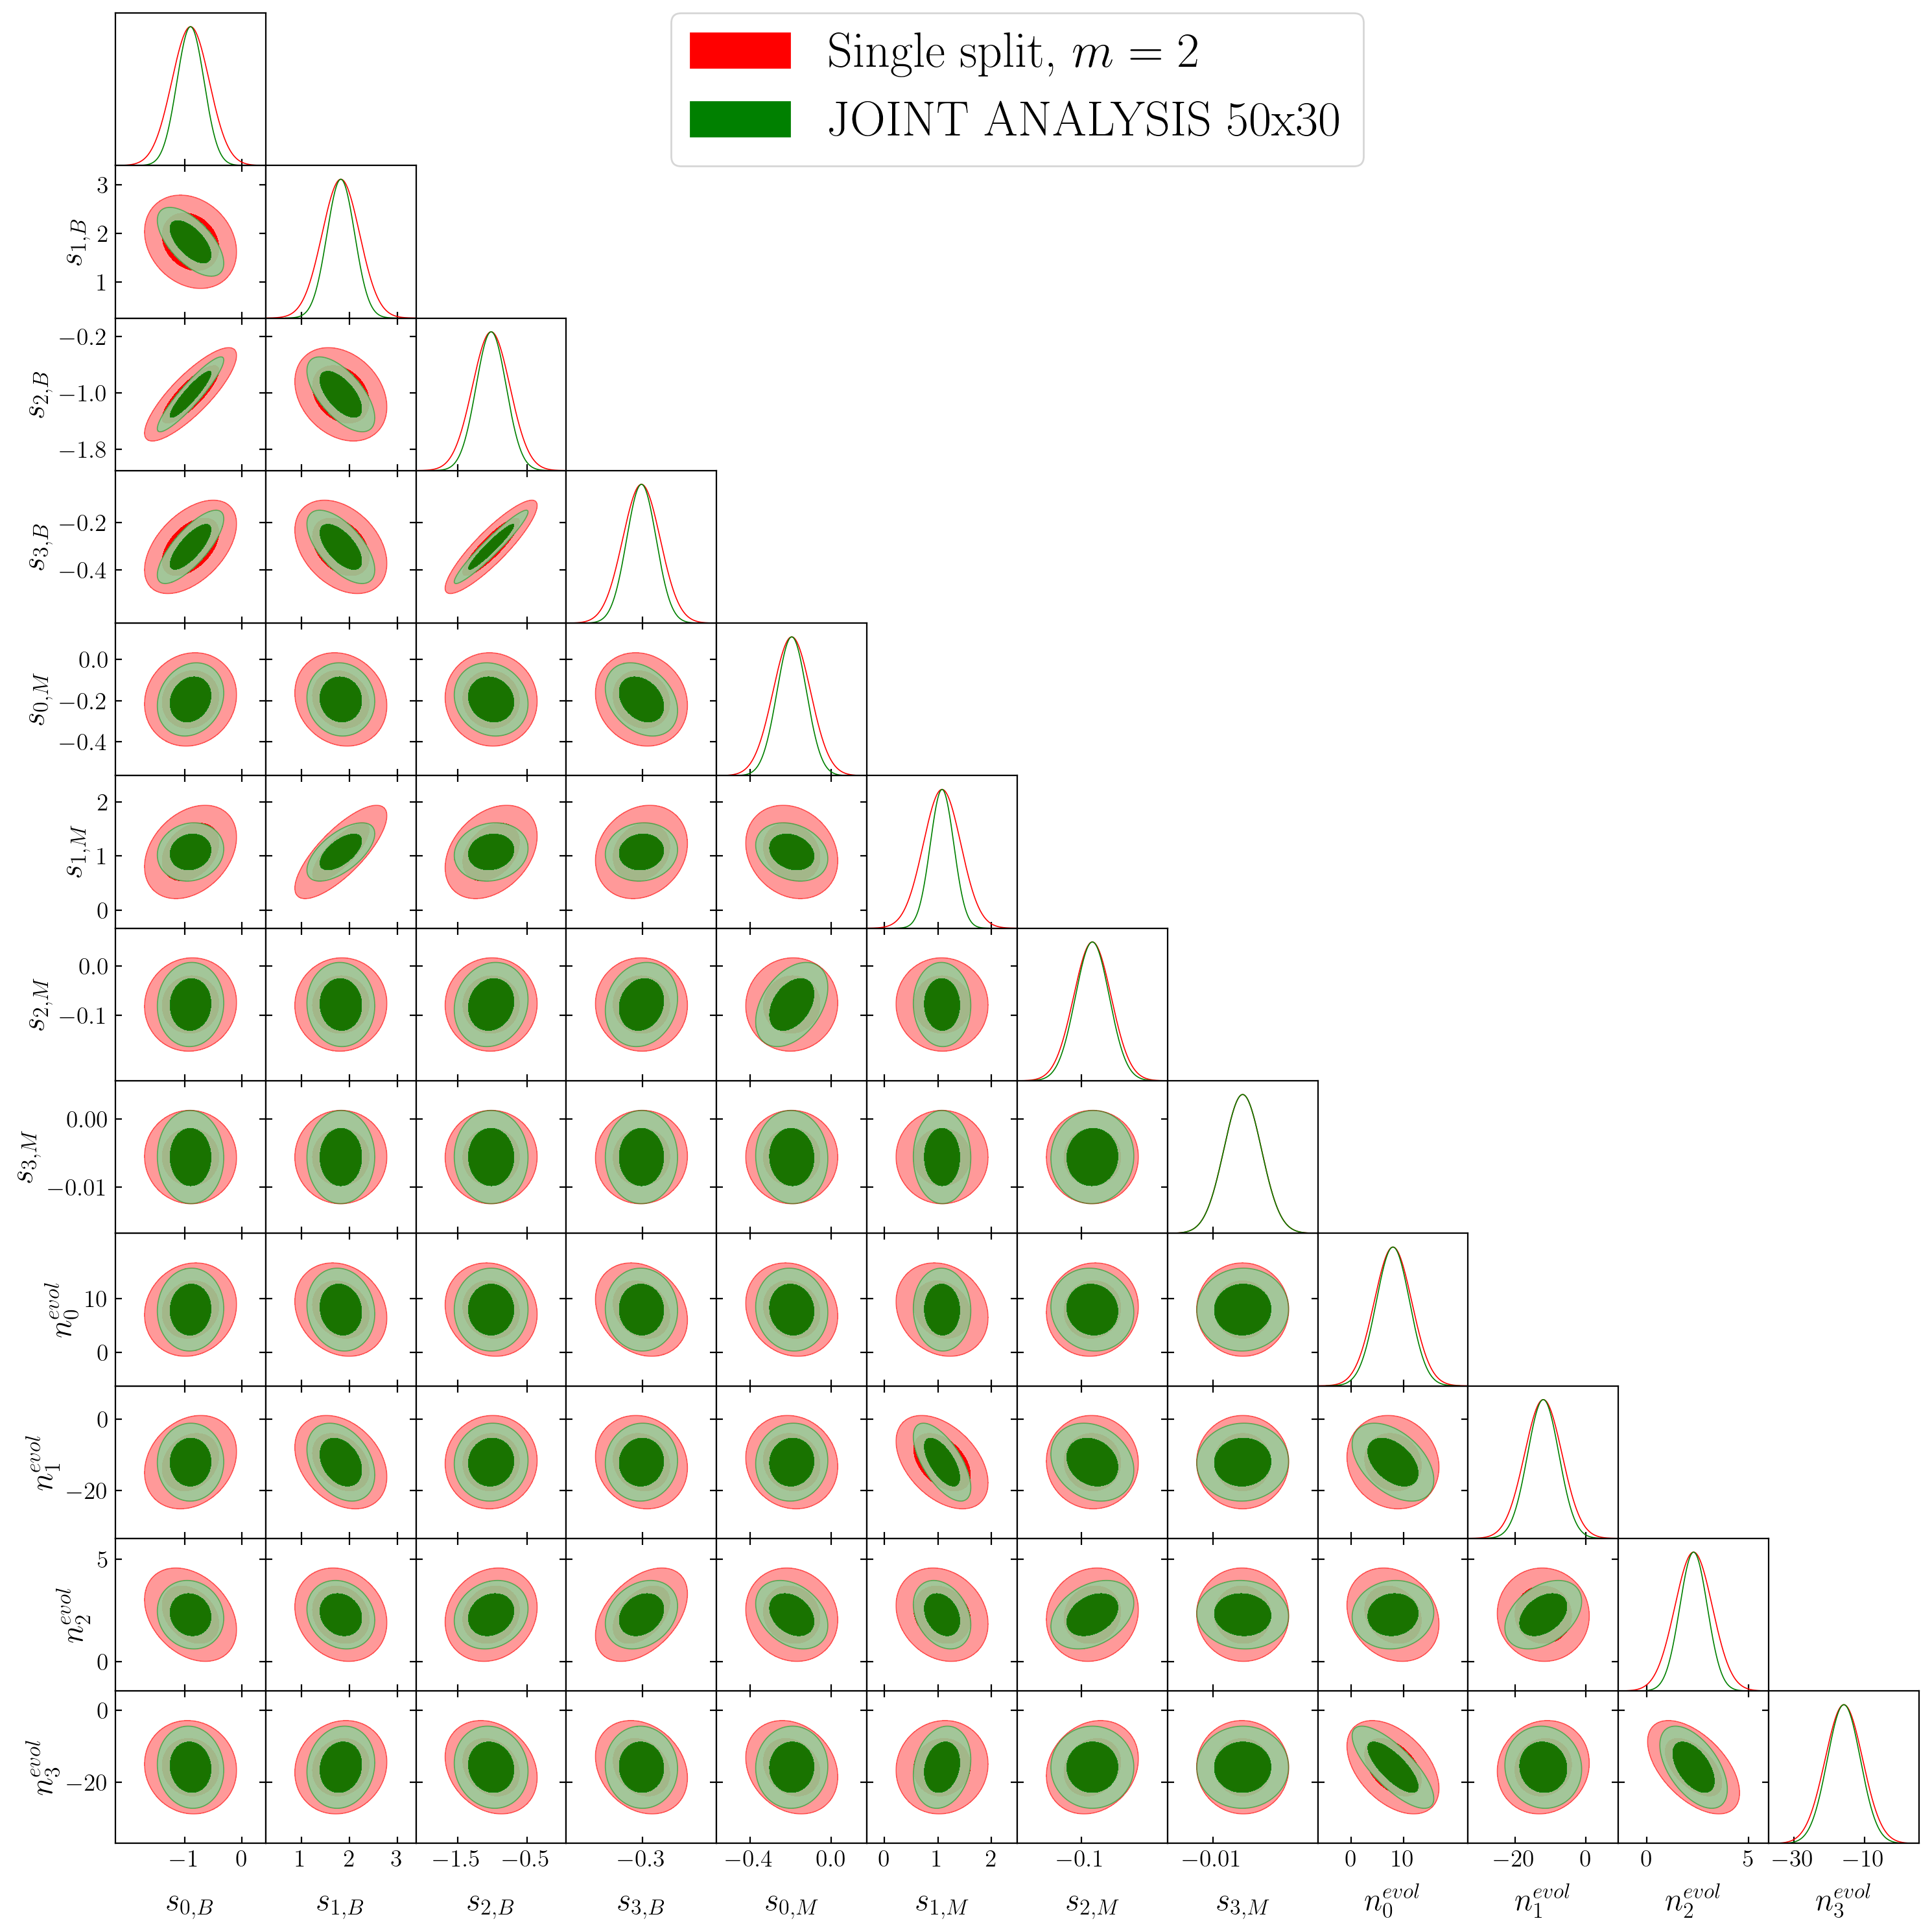

In [133]:
# Triangle plot

mean_joint = params_fid_
mean_50 = params_fid_50[:-9]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit50))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_joint_sbias_nevol_fit_ = GaussianND(mean_joint, Sigma_Matrix_Joint50x30_[:-13,:-13], labels = labels, names = param_names)
GaussDist_50_sbias_nevol_fit = GaussianND(mean_50, Sigma_Matrix_50[:-9,:-9], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_50_sbias_nevol_fit, GaussDist_joint_sbias_nevol_fit_], param_names, 
                filled=True, 
                legend_labels=[r'Single split, $m=2$', r'JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'green'])

In [145]:
np.shape(params_fid), np.shape(params_fid_30)

((29,), (21,))

In [146]:
# Delete rows and columns alien to the 30x70 split

nind = list(range(0,4))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(25, 25)

In [147]:
# Delete elements of params_fid

params_fid_ = params_fid[:-13]

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(12,)

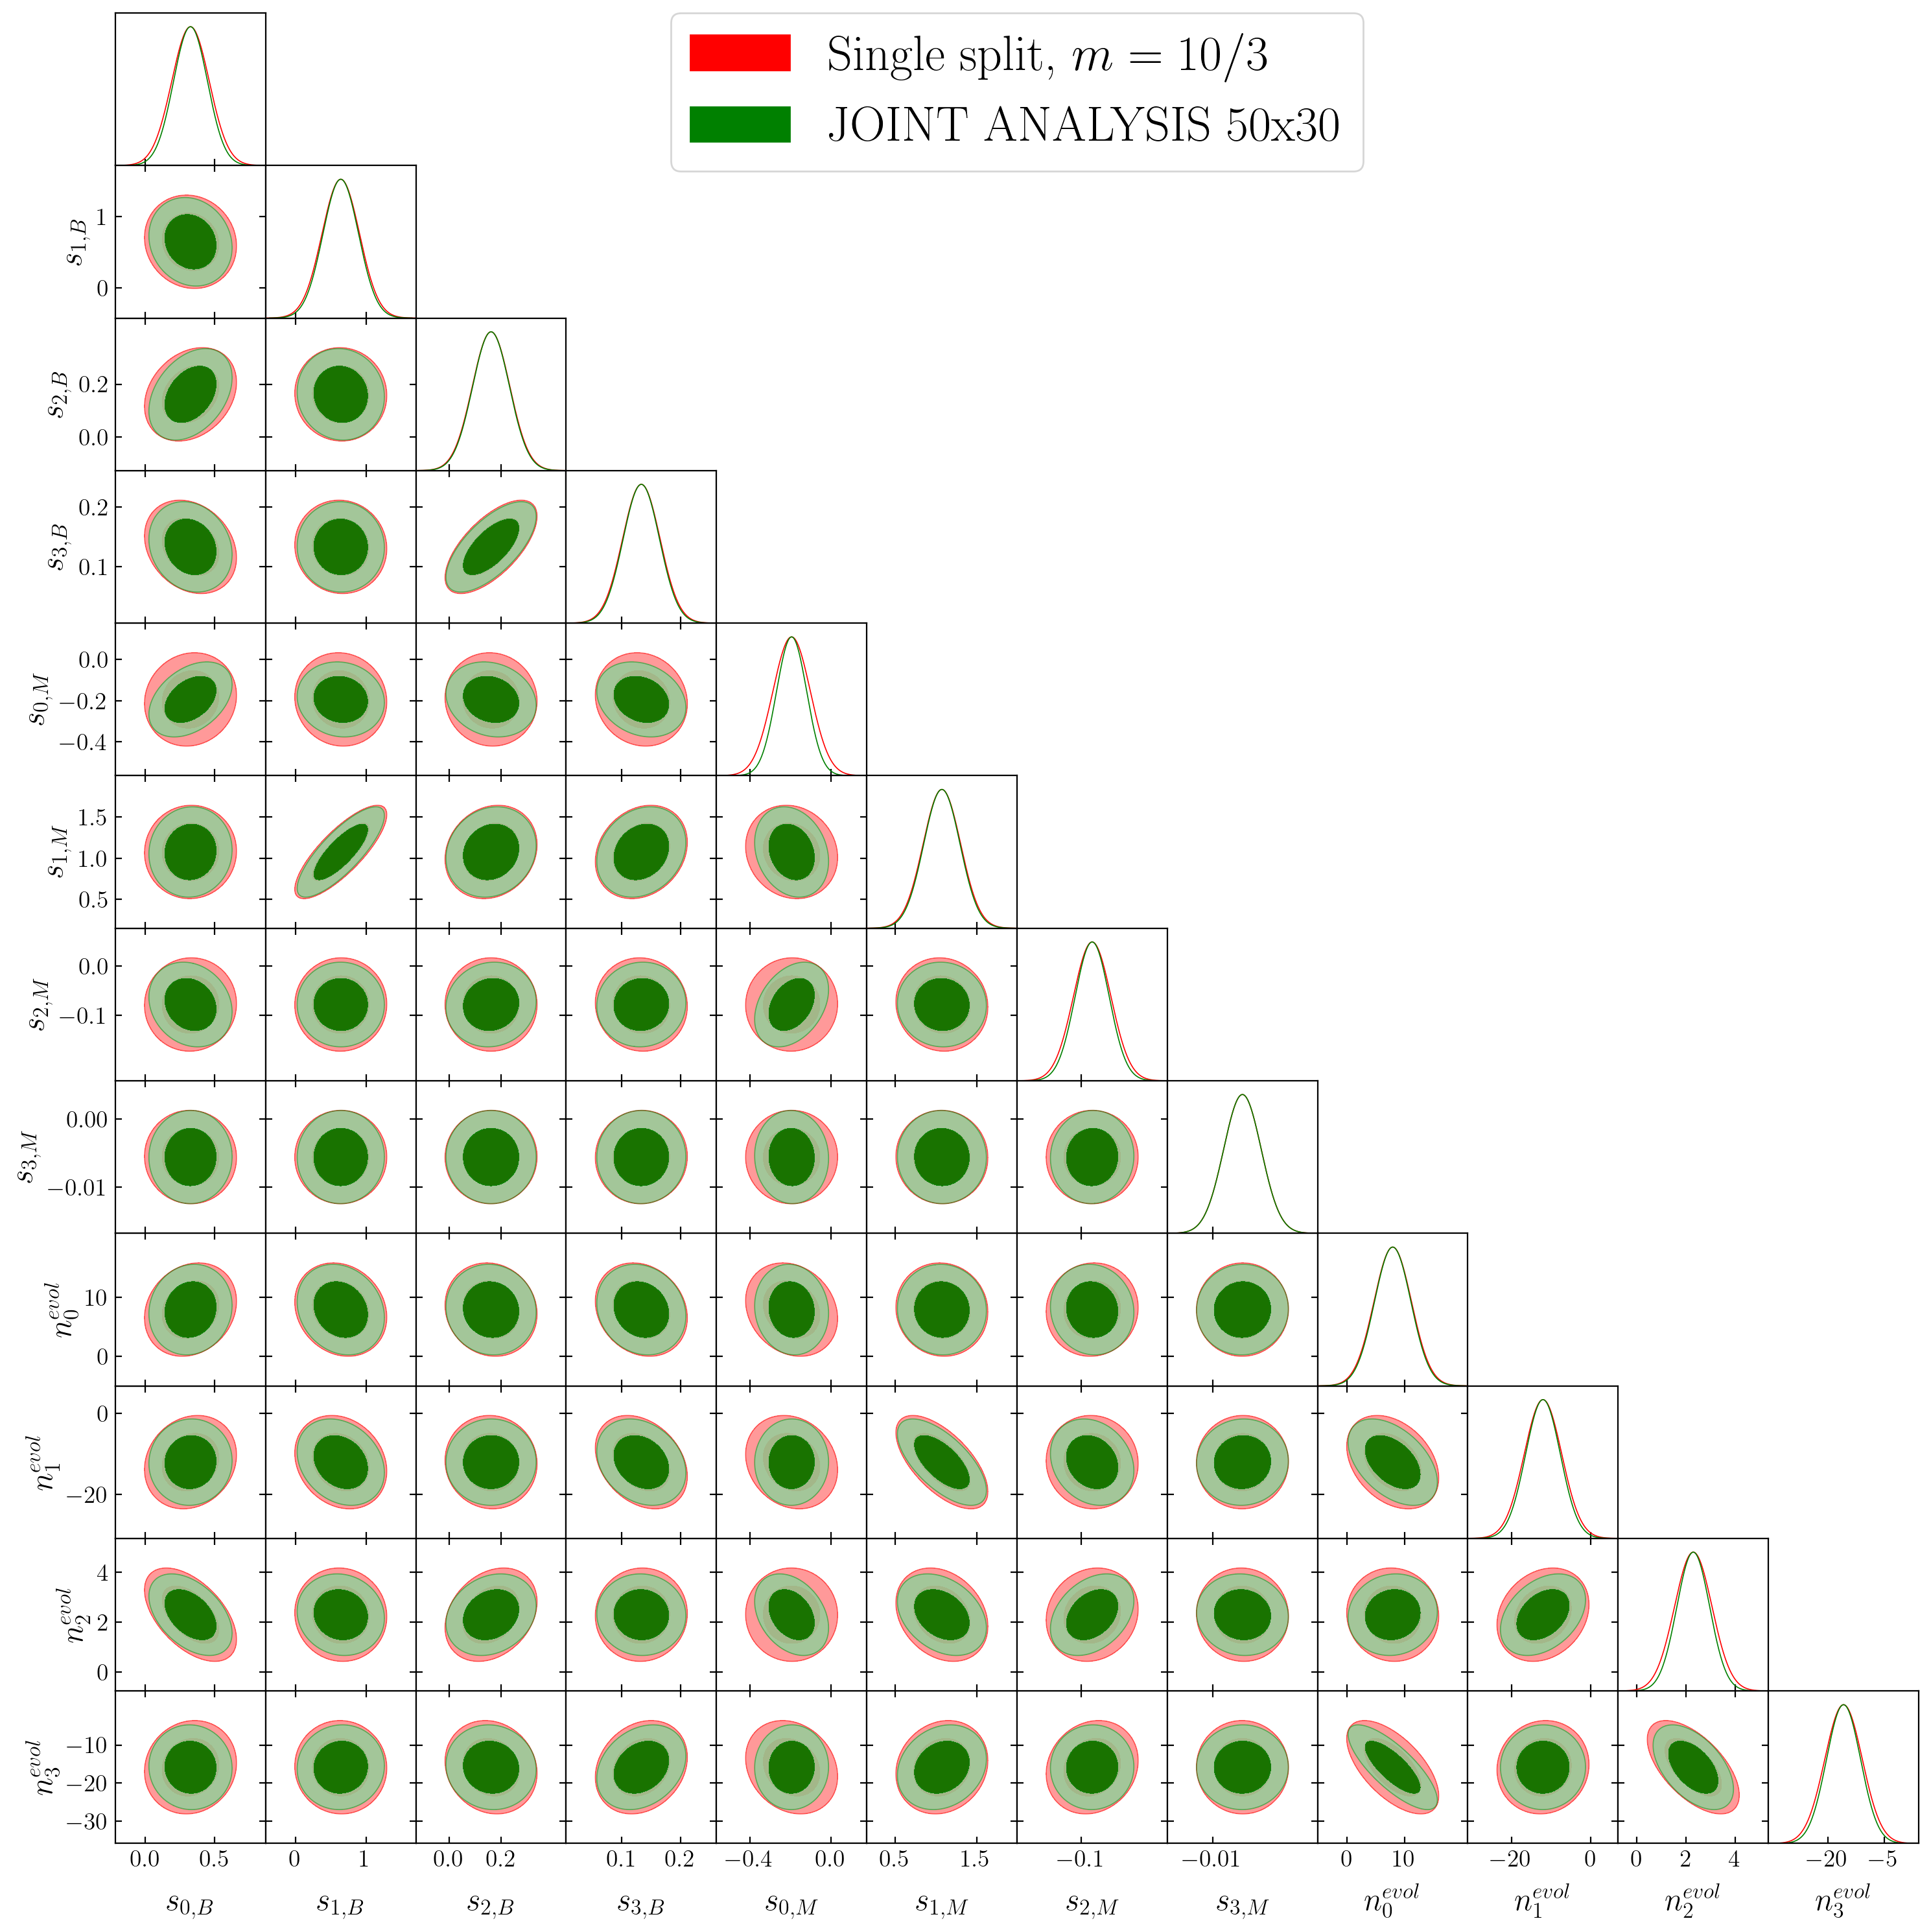

In [148]:
# Triangle plot

mean_joint = params_fid_
mean_30 = params_fid_30[:-9]

sB_names = ['s'+str(int(i))+'B' for i in np.arange(len(sB_4fit50))]
sM_names = ['s'+str(int(i))+'M' for i in np.arange(len(sM_4fit))]

sB_labels=[r's_{'+str(i)+r',B}' for i in np.arange(len(sB_4fit50))]
sM_labels=[r's_{'+str(i)+r',M}' for i in np.arange(len(sM_4fit))]

num_names = ['n'+str(int(i)) for i in np.arange(len(num_fit))]

num_labels=[r'n_{'+str(i)+r'}^{evol}' for i in np.arange(len(num_fit))]

param_names = sB_names + sM_names + num_names 
labels = sB_labels + sM_labels + num_labels 

GaussDist_joint_sbias_nevol_fit_ = GaussianND(mean_joint, Sigma_Matrix_Joint50x30_[:-13,:-13], labels = labels, names = param_names)
GaussDist_30_sbias_nevol_fit = GaussianND(mean_30, Sigma_Matrix_30[:-9,:-9], labels = labels, names = param_names)

g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_30_sbias_nevol_fit, GaussDist_joint_sbias_nevol_fit_], param_names, 
                filled=True, 
                legend_labels=[r'Single split, $m=10/3$', r'JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'green'])

In [149]:
# Delete rows and columns alien to the 50x50 split

nind = list(range(0,16)) + list(range(20,24))

Sigma_Matrix_Joint50x30_ = Sigma_Matrix_Joint50x30

Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=0)
Sigma_Matrix_Joint50x30_ = np.delete(arr=Sigma_Matrix_Joint50x30_, obj=nind, axis=1)

np.shape(Sigma_Matrix_Joint50x30_)

(9, 9)

In [150]:
# Delete elements of params_fid

params_fid_ = params_fid

params_fid_ = np.delete(arr=params_fid_, obj=nind, axis=0)

np.shape(params_fid_)

(9,)

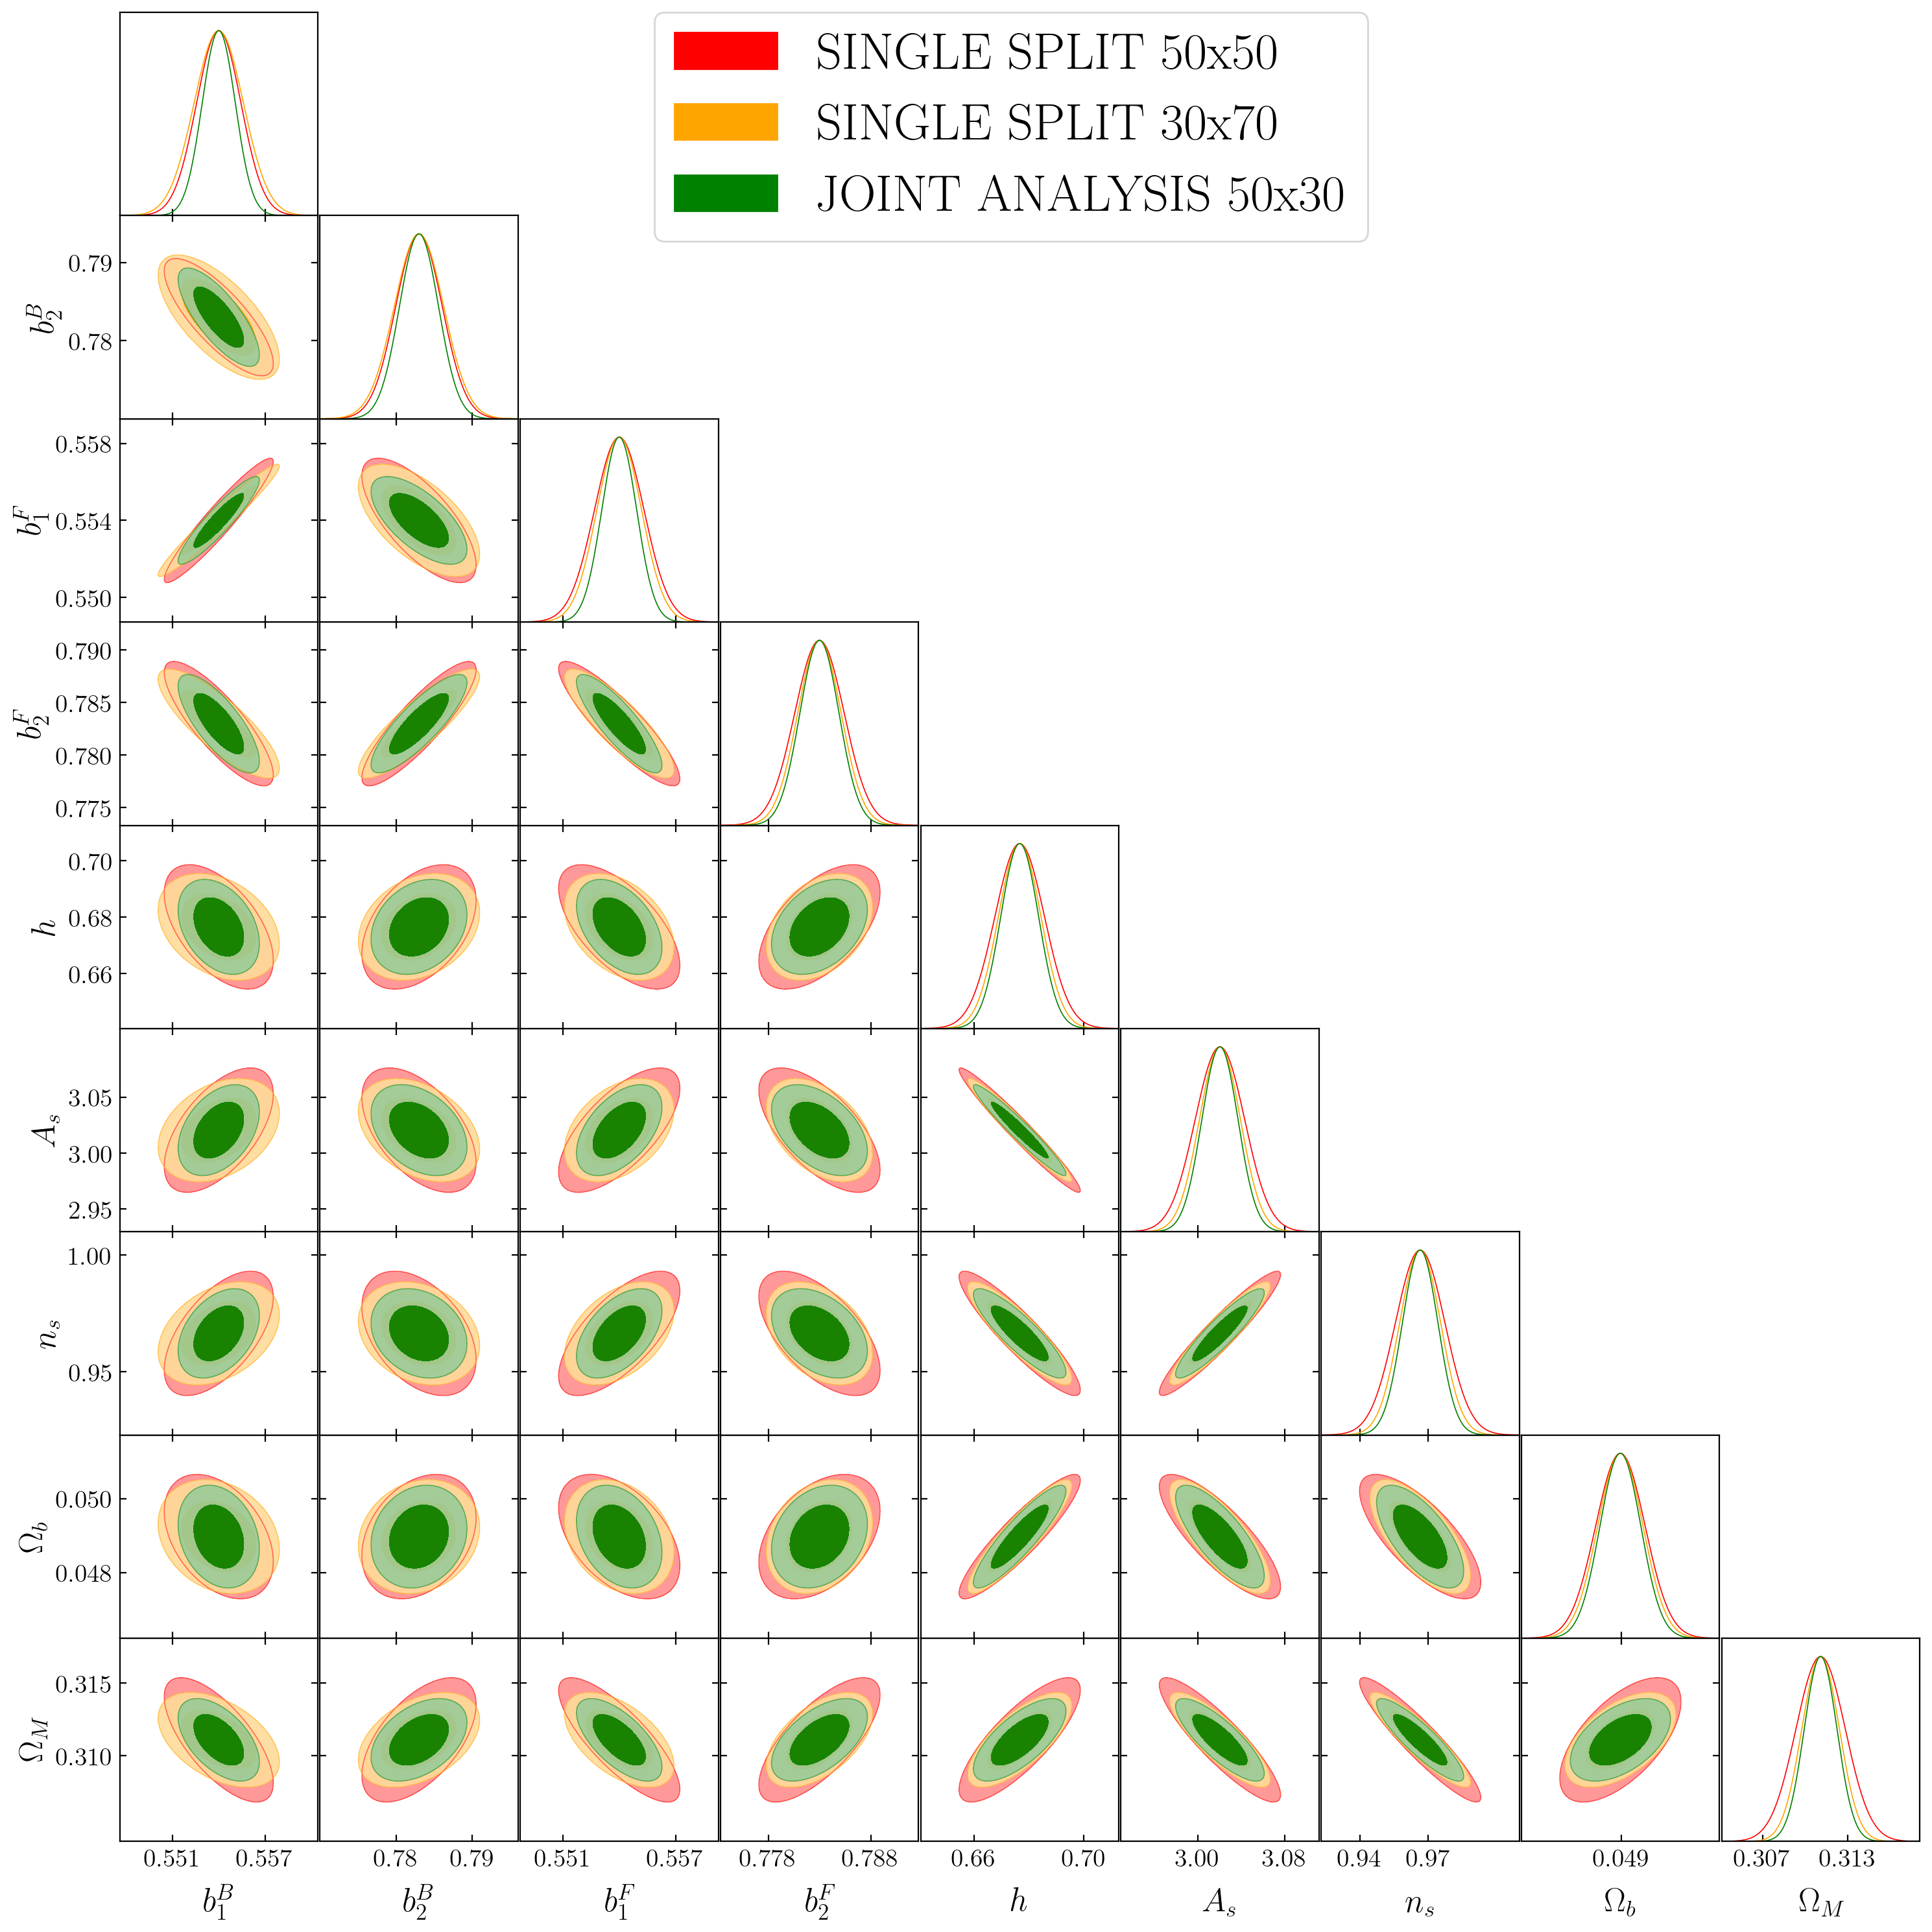

In [151]:
# Triangle plot: GALAXY BIAS AND COSMIC PARAMETERS

mean_50 = params_fid_

gbias_names = ['b1B_m1', 'b2B_m1', 'b1F_m1', 'b2F_m1']
cosmic_names = ['h', 'As', 'ns', 'Ob', 'OM']

gbias_labels = [r'b_1^{B}', r'b_2^{B}', r'b_1^{F}', r'b_2^{F}']
cosmic_labels = [r'h', r'A_s', r'n_s', r'\Omega_b', r'\Omega_M']

param_names = gbias_names + cosmic_names
labels = gbias_labels + cosmic_labels

GaussDist_gbias_cosmic_fit = GaussianND(mean_50, Sigma_Matrix_Joint50x30_, labels = labels, names = param_names)
GaussDist_gbias_cosmic_fit_50 = GaussianND(mean_50, Sigma_Matrix_50[12:, 12:], labels = labels, names = param_names)
GaussDist_gbias_cosmic_fit_30 = GaussianND(mean_50, Sigma_Matrix_30[12:, 12:], labels = labels, names = param_names)


g = plots.get_subplot_plotter(width_inch=15)
g.settings.legend_frame = True
g.settings.alpha_filled_add=0.9
g.settings.legend_fontsize=32
g.settings.axes_fontsize=18
g.settings.axes_labelsize=22
g.settings.axis_tick_max_labels=6

g.triangle_plot([GaussDist_gbias_cosmic_fit_50, GaussDist_gbias_cosmic_fit_30, GaussDist_gbias_cosmic_fit], param_names, 
                filled=True, 
                legend_labels=['SINGLE SPLIT 50x50', 'SINGLE SPLIT 30x70','JOINT ANALYSIS 50x30'],
                contour_colors=['red', 'orange', 'green'])

# Predictions from the JOINT ANALYSIS

## Magnification bias

In [76]:
# Magnification bias fit

def magbias_fit(params, x):
    a, b, c, d = params
    return  a + b * x + c * np.log(x) + d * (np.log(x))**2

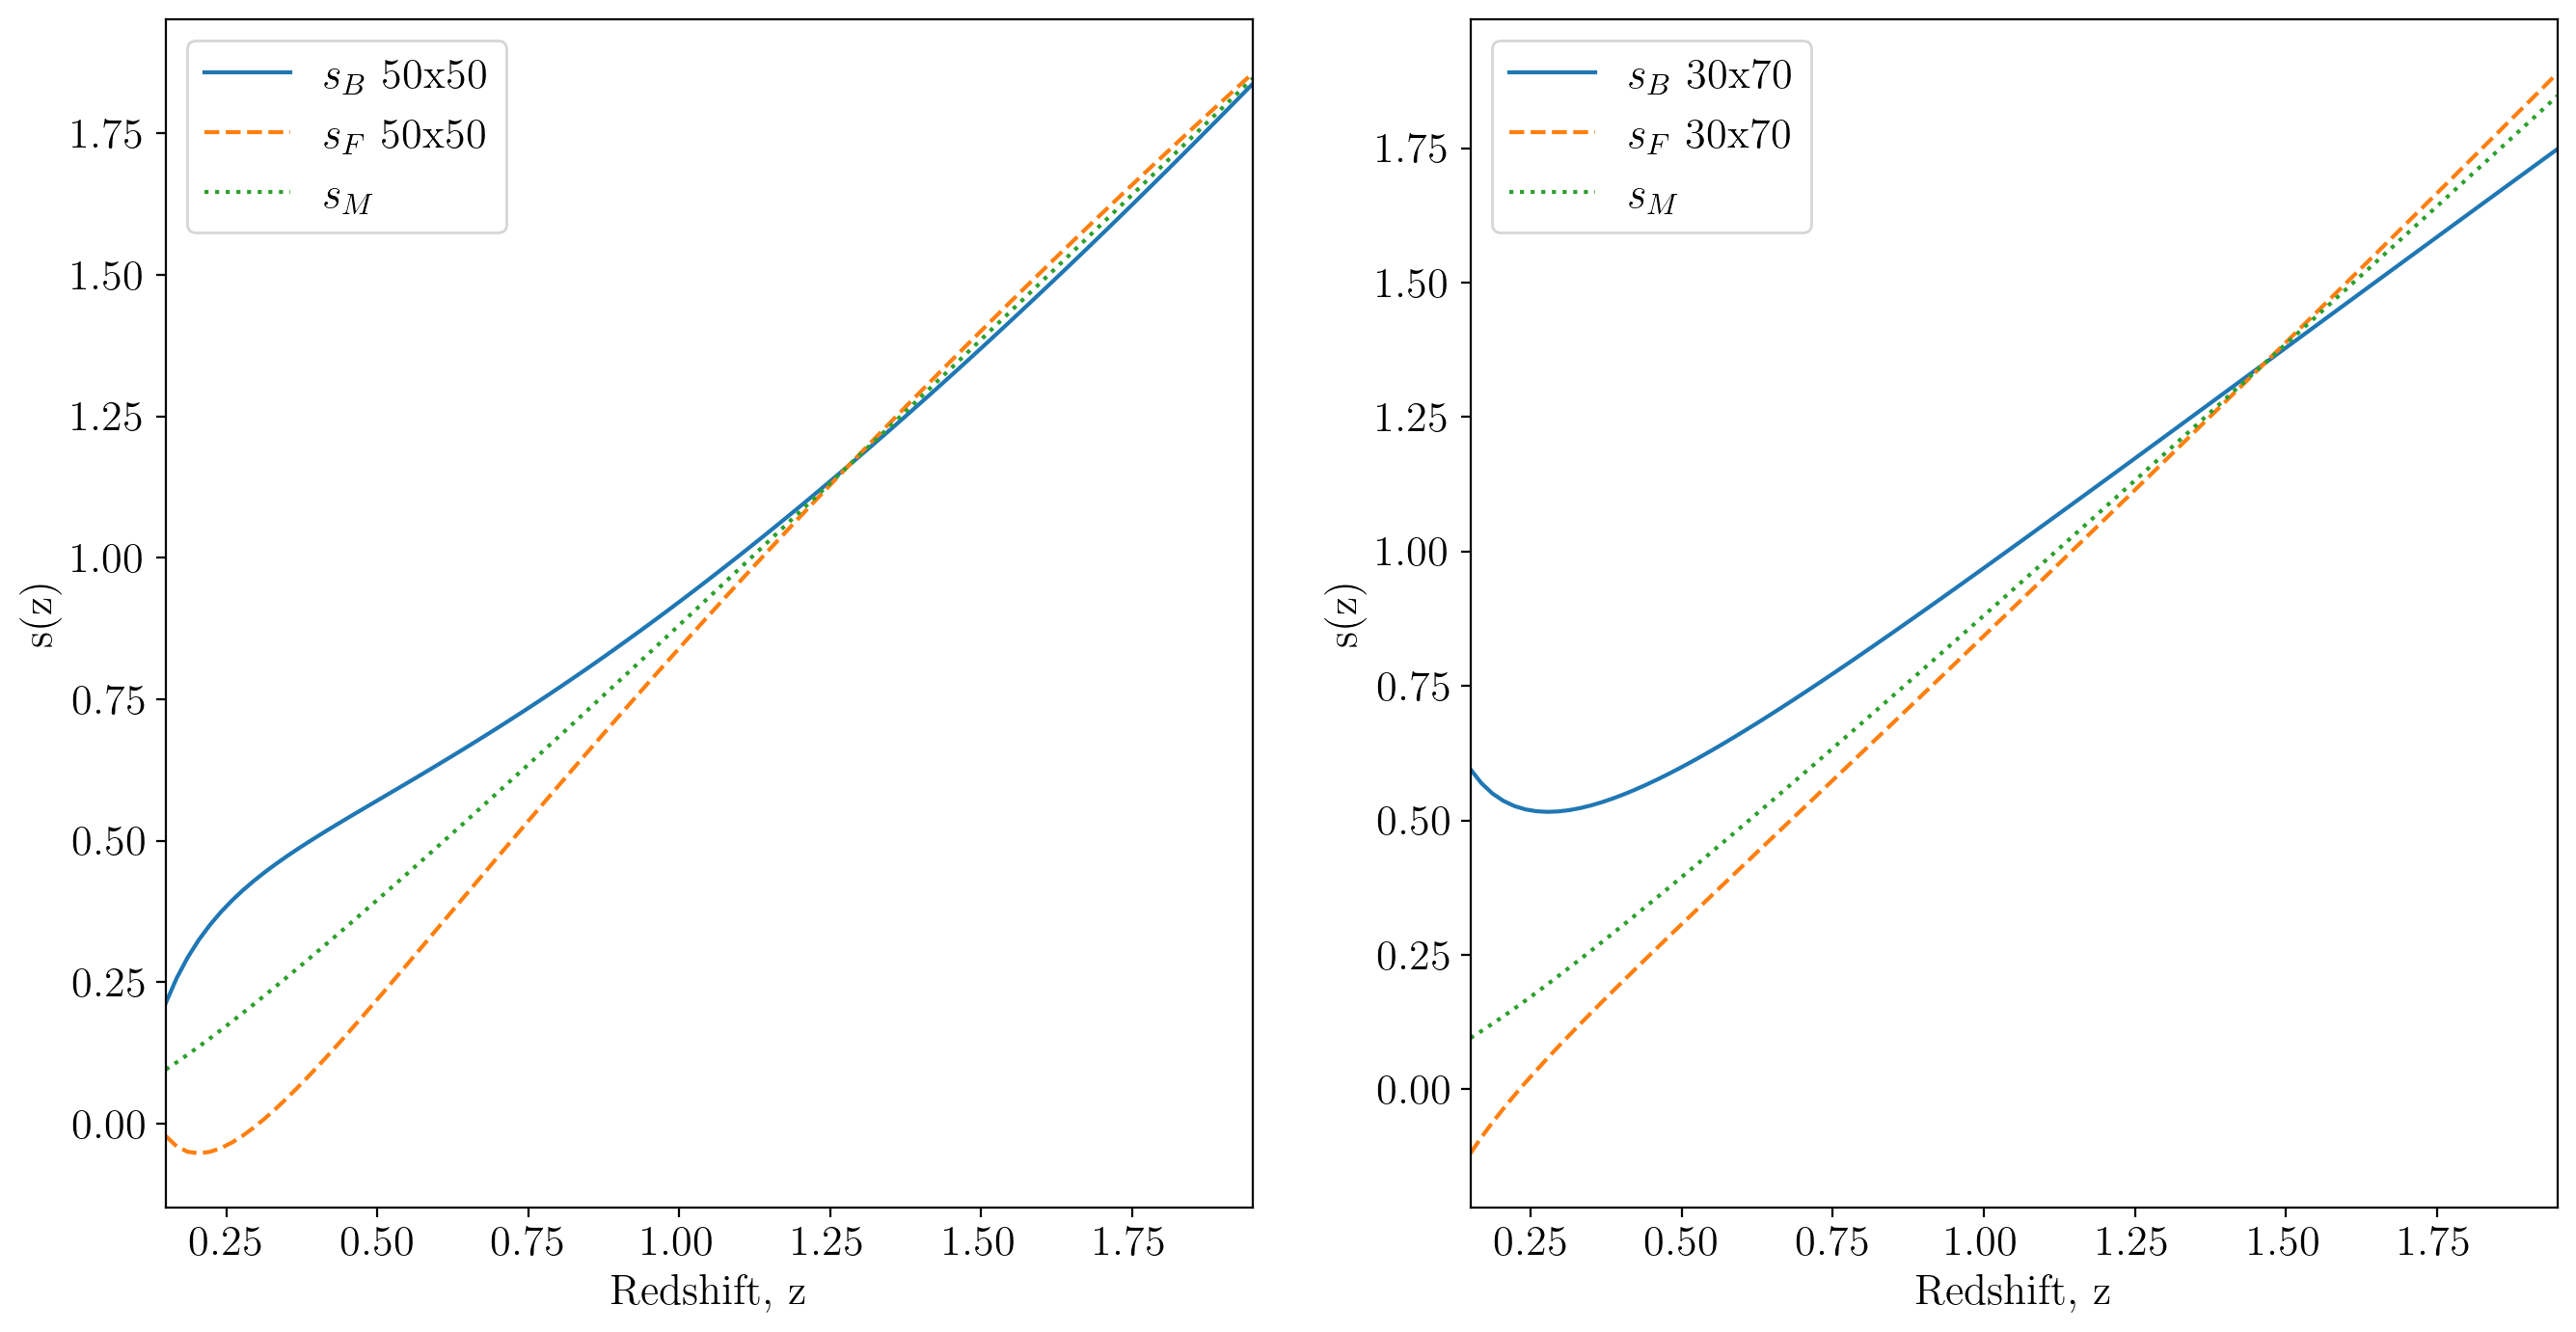

In [77]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

m_50 = 2.
m_30 = 10/3.

sB_fid_50 = magbias_fit(sB_fit[:4], z_lin)
sB_fid_30 = magbias_fit(sB_fit[4:], z_lin)
sM_fid = magbias_fit(sM_4fit, z_lin)
sF_fid_50 = sM_fid * (m_50/(m_50-1)) - sB_fid_50/(m_50-1)
sF_fid_30 = sM_fid * (m_30/(m_30-1)) - sB_fid_30/(m_30-1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, '-', label=r'$s_B$ 50x50')
ax[0].plot(z_lin, sF_fid_50, '--', label=r'$s_F$ 50x50')
ax[0].plot(z_lin, sM_fid, ':', label=r'$s_M$')

ax[1].plot(z_lin, sB_fid_30, '-', label=r'$s_B$ 30x70')
ax[1].plot(z_lin, sF_fid_30, '--', label=r'$s_F$ 30x70')
ax[1].plot(z_lin, sM_fid, ':', label=r'$s_M$')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r's(z)')
    axi.legend();


### Observables: $s_B(z)$ and $s_M(z)$

In [78]:
# Compute priors 

# Select the marginalized covariance matrix for the magnification biases priors

cov_sB_50_priors = Cov_prior_all[:4, :4]
cov_sB_30_priors = Cov_prior_all[4:8, 4:8]
cov_sM_priors = Cov_prior_all[8:12, 8:12]

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
sB_50_pars_samples_priors = np.random.multivariate_normal(sB_4fit50, cov_sB_50_priors, num_samples)
sB_30_pars_samples_priors = np.random.multivariate_normal(sB_4fit30, cov_sB_30_priors, num_samples)
sM_pars_samples_priors = np.random.multivariate_normal(sM_4fit, cov_sM_priors, num_samples)

# Evaluate fitting function for each parameter sample

sB_50_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_50_pars_samples_priors])
sB_30_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_30_pars_samples_priors])

sM_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_priors])

# Calculate the 68% confidence interval

sB_50_lower_bound_priors = np.percentile(sB_50_samples_priors, 16, axis=0)
sB_50_upper_bound_priors = np.percentile(sB_50_samples_priors, 84, axis=0)

sB_30_lower_bound_priors = np.percentile(sB_30_samples_priors, 16, axis=0)
sB_30_upper_bound_priors = np.percentile(sB_30_samples_priors, 84, axis=0)

sM_lower_bound_priors = np.percentile(sM_samples_priors, 16, axis=0)
sM_upper_bound_priors = np.percentile(sM_samples_priors, 84, axis=0)


###### Compare the two observables

In [79]:
# Select the marginalized covariance matrix for the magnification biases

cov_sB_Joint_50 = Sigma_Matrix_Joint50x30[:4, :4]
cov_sB_Joint_30 = Sigma_Matrix_Joint50x30[4:8, 4:8]
cov_sM_Joint = Sigma_Matrix_Joint50x30[8:12, 8:12]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sB_Joint_50_pars_samples = np.random.multivariate_normal(sB_4fit50, cov_sB_Joint_50, num_samples)
sB_Joint_30_pars_samples = np.random.multivariate_normal(sB_4fit30, cov_sB_Joint_30, num_samples)
sM_Joint_pars_samples = np.random.multivariate_normal(sM_4fit, cov_sM_Joint, num_samples)

# Evaluate fitting function for each parameter sample
sB_Joint_50_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_Joint_50_pars_samples])
sB_Joint_30_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_Joint_30_pars_samples])
sM_Joint_samples = np.array([magbias_fit(pars, z_lin) for pars in sM_Joint_pars_samples])

# Calculate the 68% confidence interval
sB_Joint_50_lower_bound = np.percentile(sB_Joint_50_samples, 16, axis=0)
sB_Joint_50_upper_bound = np.percentile(sB_Joint_50_samples, 84, axis=0)

sB_Joint_30_lower_bound = np.percentile(sB_Joint_30_samples, 16, axis=0)
sB_Joint_30_upper_bound = np.percentile(sB_Joint_30_samples, 84, axis=0)

sM_Joint_lower_bound = np.percentile(sM_Joint_samples, 16, axis=0)
sM_Joint_upper_bound = np.percentile(sM_Joint_samples, 84, axis=0)

Predictions for $s_B(z)$ vs Priors

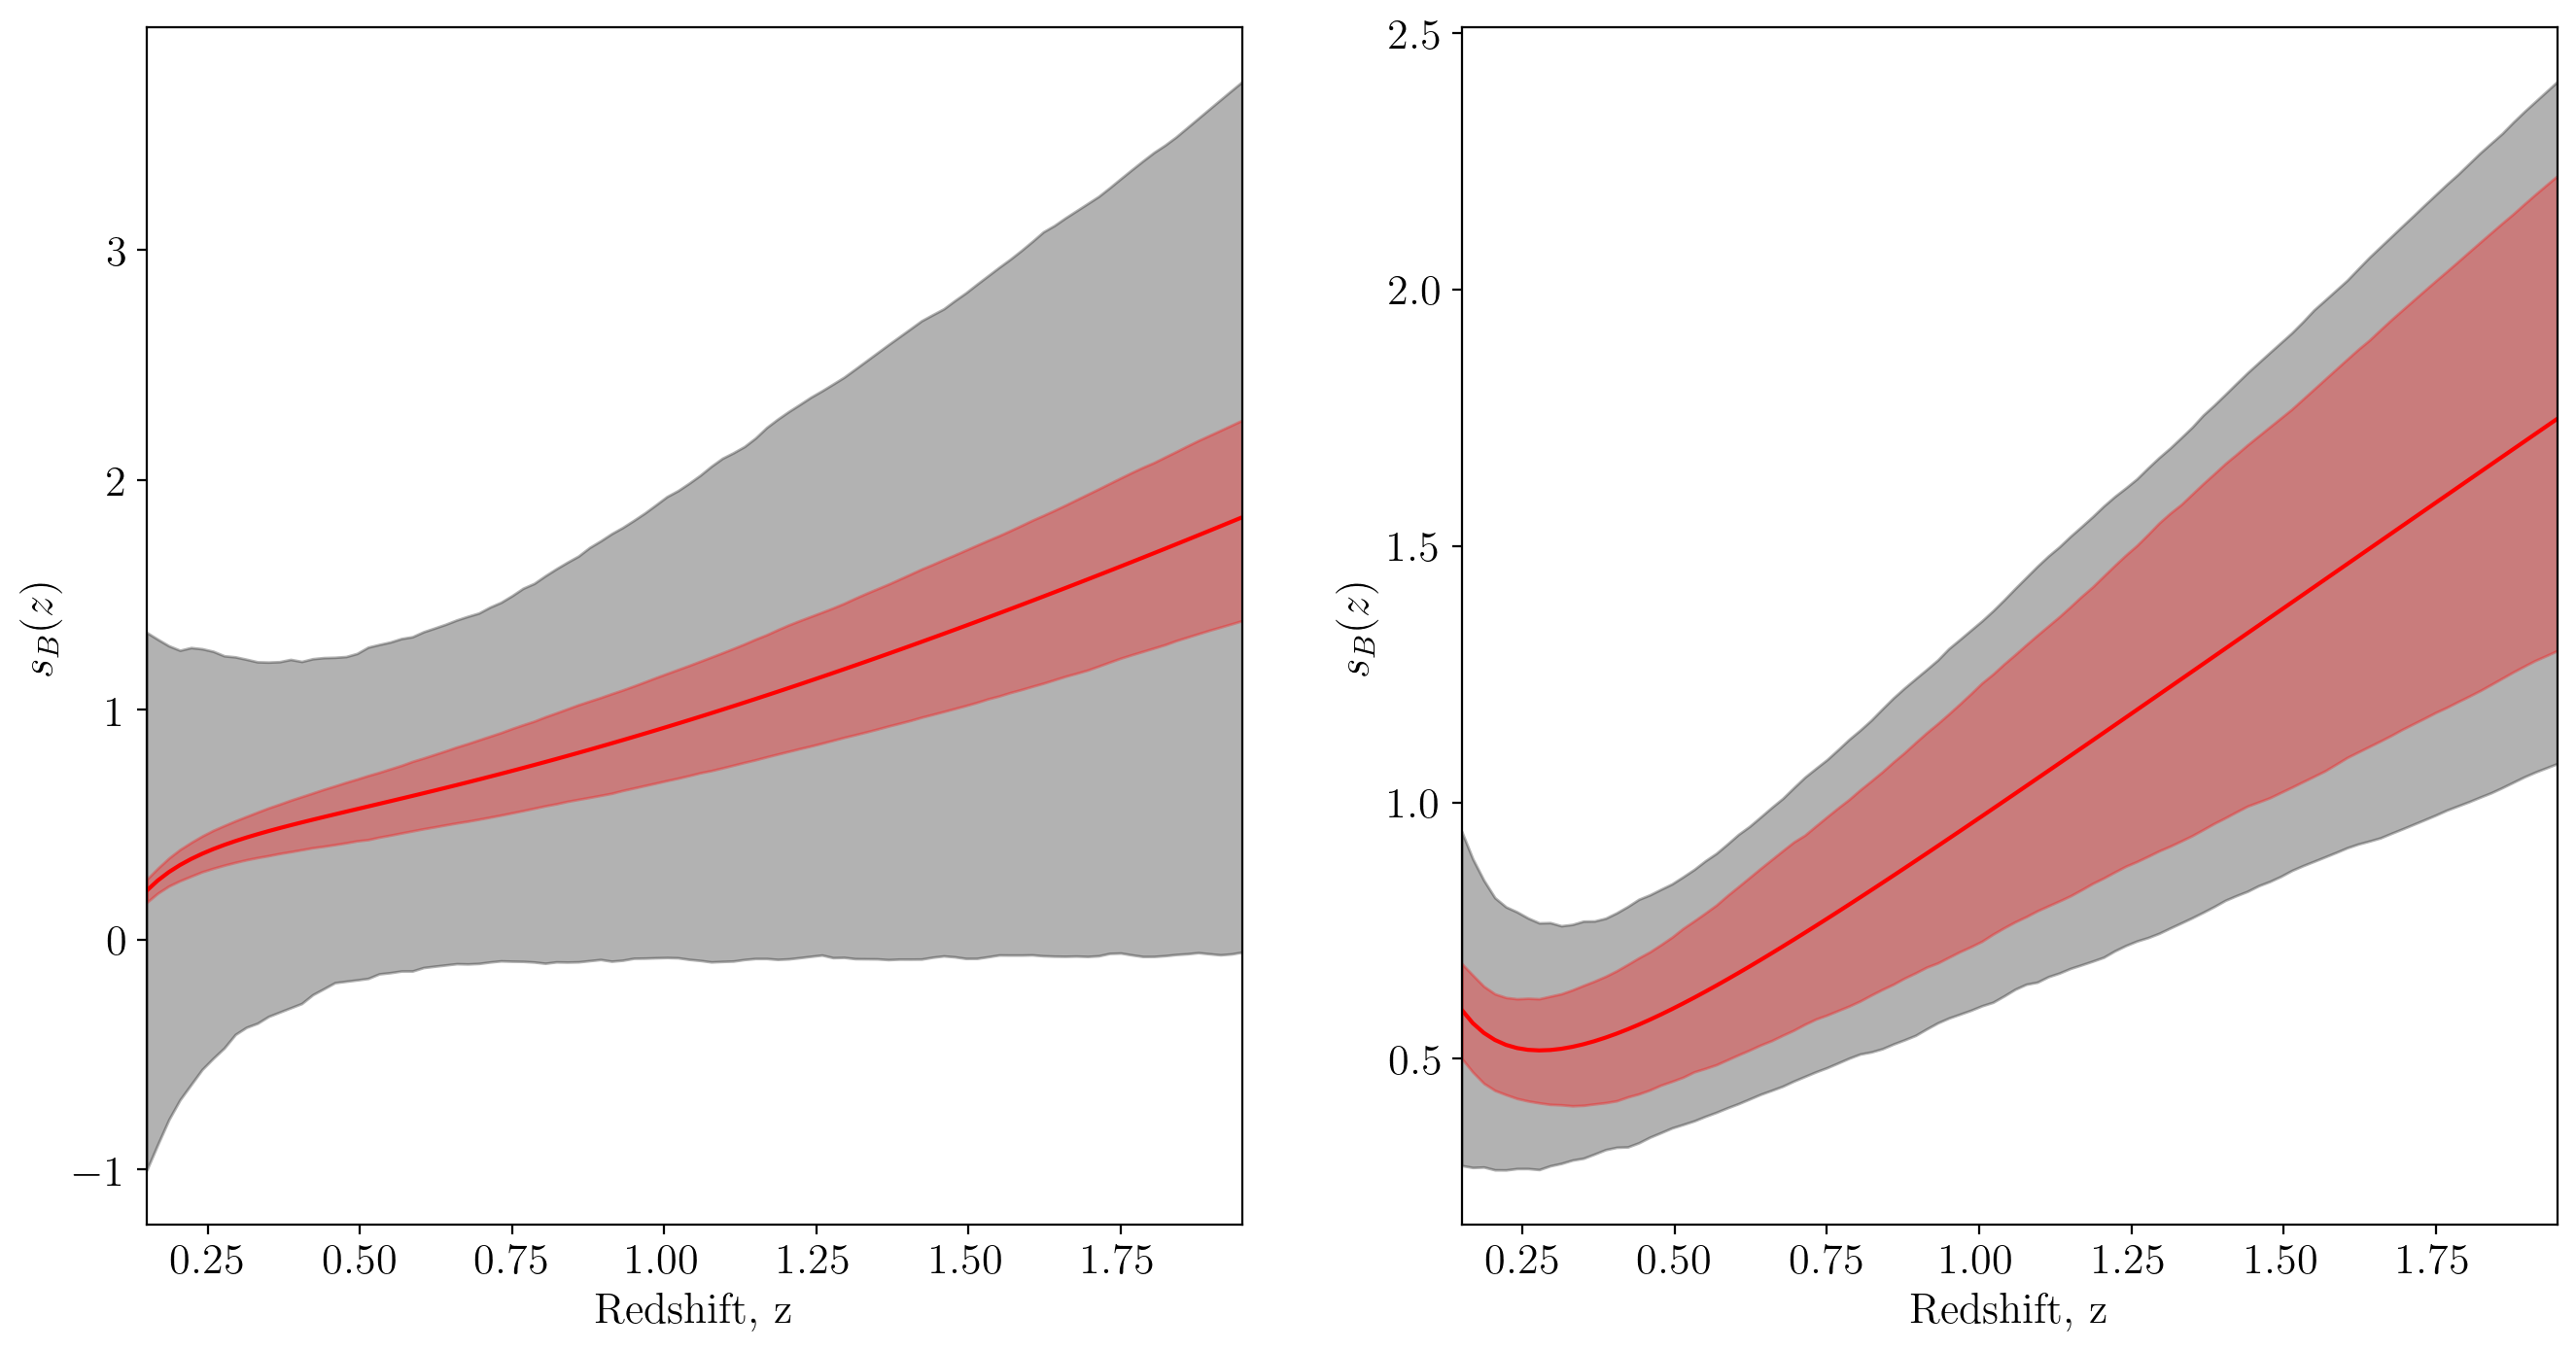

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, 'r-')
ax[0].fill_between(z_lin, sB_50_lower_bound_priors, sB_50_upper_bound_priors, color='black', alpha=0.3)
ax[0].fill_between(z_lin, sB_Joint_50_lower_bound, sB_Joint_50_upper_bound, color='red', alpha=0.3)

ax[1].plot(z_lin, sB_fid_30, 'r-')
ax[1].fill_between(z_lin, sB_30_lower_bound_priors, sB_30_upper_bound_priors, color='black', alpha=0.3)
ax[1].fill_between(z_lin, sB_Joint_30_lower_bound, sB_Joint_30_upper_bound, color='red', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r'$s_B(z)$')

Predictions for $s_M(z)$ vs Priors

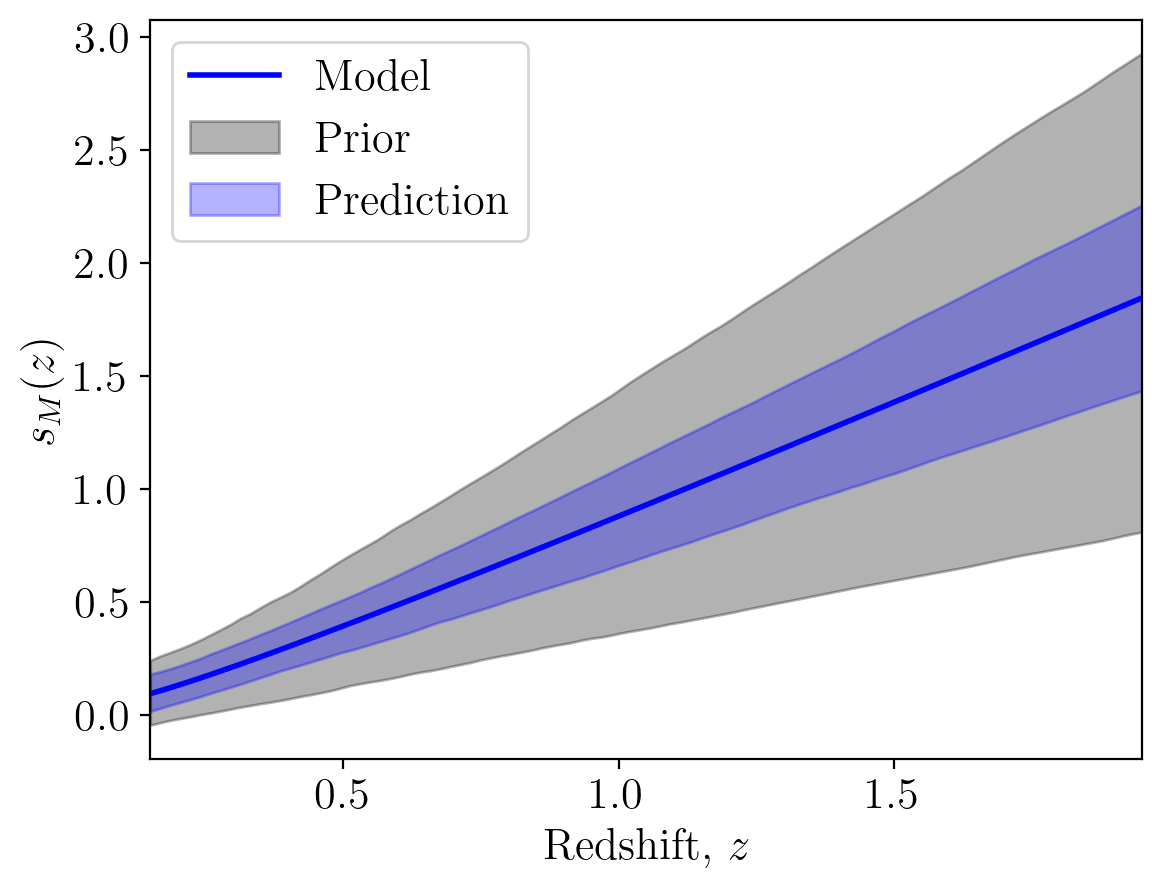

In [81]:
plt.plot(z_lin, sM_fid, '-', lw = 2.0, color='blue', label = 'Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label = r'Prior')
plt.fill_between(z_lin, sM_Joint_lower_bound, sM_Joint_upper_bound, color='blue', alpha=0.3, label = r'Prediction')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_M(z)$');
plt.legend(loc='upper left');

### Magnification bias of the Faint, $s_F(z)$

The magnification bias of the faint population is obtained by:

$$ s_F(z) = s_{model}(z)\frac{\bar{N}(z)}{\bar{N}_F(z)} - s_B(z)\frac{\bar{N}_B(z)}{\bar{N}_F(z)} = s_F(z) = s_{model}(z)\frac{m}{m-1} - s_B(z)\frac{1}{m-1} $$ 

We need to sample together the $s_B$ and $s_m$ parameters.

In [82]:
sbias_fid = np.concatenate([sB_4fit50, sB_4fit30, sM_4fit])

np.shape(sbias_fid)

(12,)

In [83]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias = Sigma_Matrix_Joint50x30[:12, :12]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_Joint_pars_samples = np.random.multivariate_normal(sbias_fid, cov_sbias, num_samples)

# Evaluate fitting function for each parameter sample
sB_Joint_50_samples_ = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_Joint_pars_samples])
sB_Joint_30_samples_ = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_Joint_pars_samples])
sM_Joint_samples_ = np.array([magbias_fit(pars[8:12], z_lin) for pars in sbias_Joint_pars_samples])

# Compute the sF for each sample
sF_50_samples_ = sM_Joint_samples_*m_50/(m_50-1) - sB_Joint_50_samples_/(m_50-1)
sF_30_samples_ = sM_Joint_samples_*m_30/(m_30-1) - sB_Joint_30_samples_/(m_30-1)


# Calculate the 68% confidence interval
sF_50_Joint_lower_bound_ = np.percentile(sF_50_samples_, 16, axis=0)
sF_50_Joint_upper_bound_ = np.percentile(sF_50_samples_, 84, axis=0)

sF_30_Joint_lower_bound_ = np.percentile(sF_30_samples_, 16, axis=0)
sF_30_Joint_upper_bound_ = np.percentile(sF_30_samples_, 84, axis=0)

Compare with priors

In [84]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_priors_ = Cov_prior_all[:12, :12]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_pars_samples_priors_ = np.random.multivariate_normal(sbias_fid, cov_sbias_priors_, num_samples)

# Evaluate fitting function for each parameter sample
sB_50_samples_priors_ = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_pars_samples_priors_])
sB_30_samples_priors_ = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_pars_samples_priors_])
sM_samples_priors_ = np.array([magbias_fit(pars[8:12], z_lin) for pars in sbias_pars_samples_priors_])

# Compute the sF for each sample
sF_50_samples_priors_ = sM_samples_priors_*m_50/(m_50-1) - sB_50_samples_priors_/(m_50-1)
sF_30_samples_priors_ = sM_samples_priors_*m_30/(m_30-1) - sB_30_samples_priors_/(m_30-1)

# Calculate the 68% confidence interval
sF_50_lower_bound_priors_ = np.percentile(sF_50_samples_priors_, 16, axis=0)
sF_50_upper_bound_priors_ = np.percentile(sF_50_samples_priors_, 84, axis=0)

sF_30_lower_bound_priors_ = np.percentile(sF_30_samples_priors_, 16, axis=0)
sF_30_upper_bound_priors_ = np.percentile(sF_30_samples_priors_, 84, axis=0)

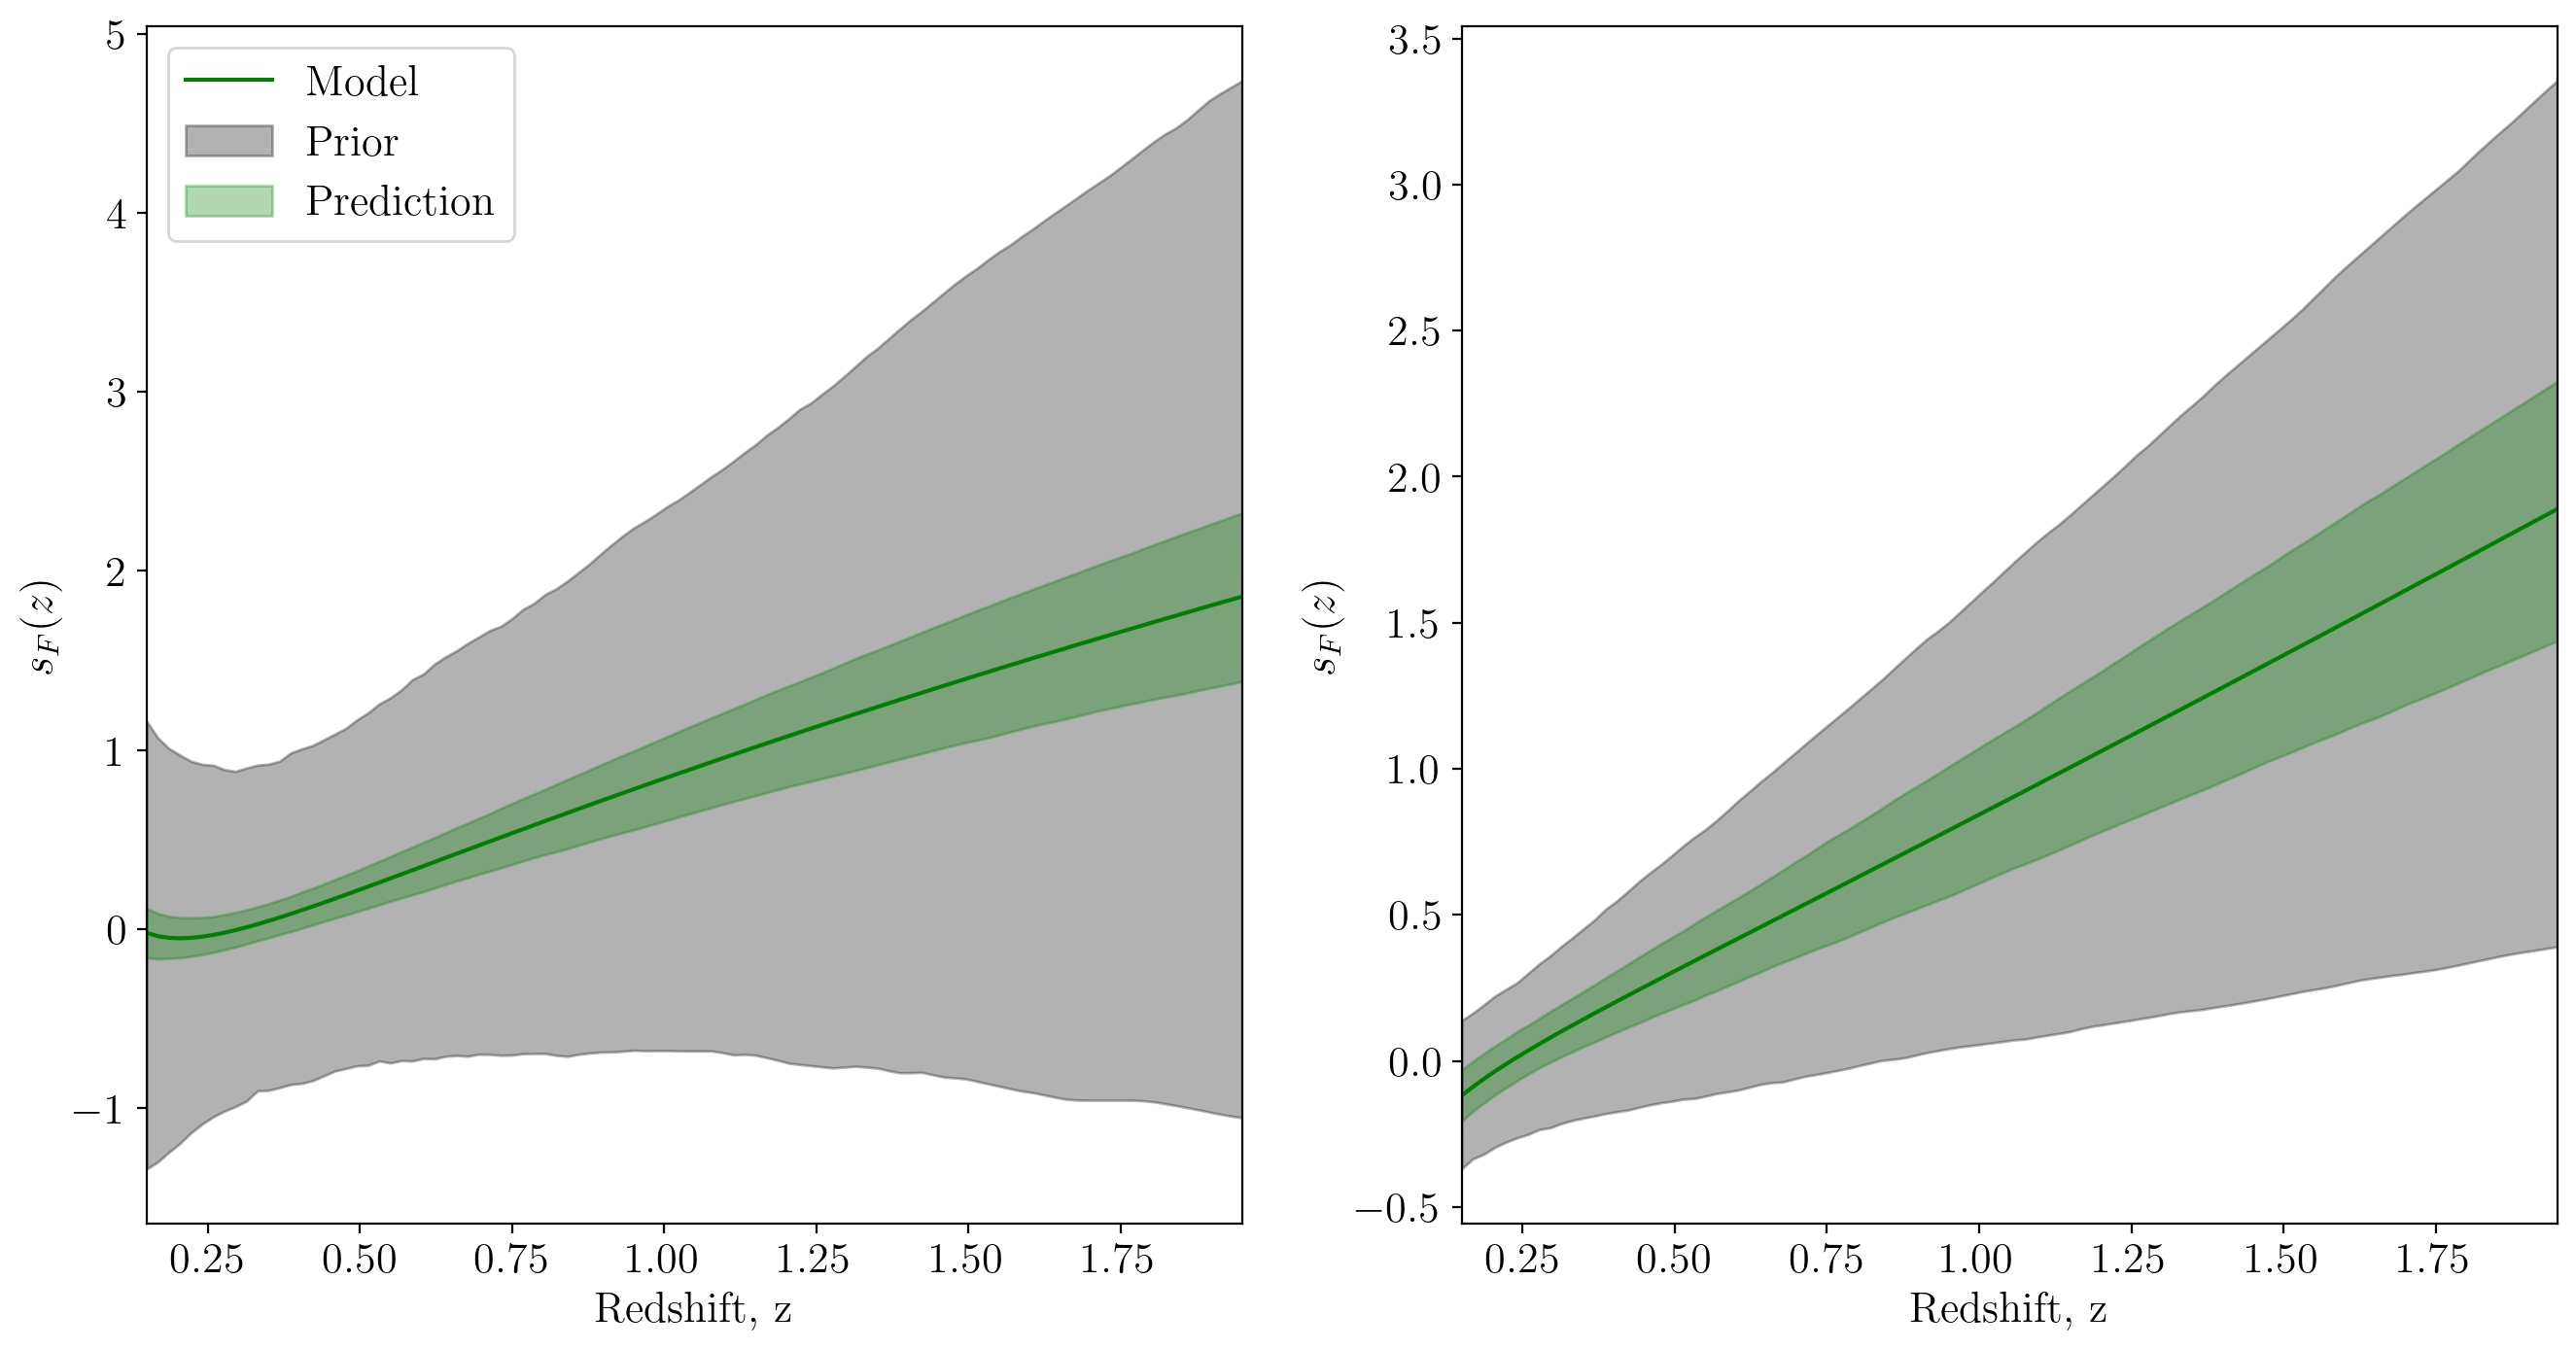

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sF_fid_50, '-', color = 'green', label = 'Model')
ax[0].fill_between(z_lin, sF_50_lower_bound_priors_, sF_50_upper_bound_priors_, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, sF_50_Joint_lower_bound_, sF_50_Joint_upper_bound_, color='green', alpha=0.3, label = 'Prediction')

ax[1].plot(z_lin, sF_fid_30, '-', color = 'green')
ax[1].fill_between(z_lin, sF_30_lower_bound_priors_, sF_30_upper_bound_priors_, color='black', alpha=0.3)
ax[1].fill_between(z_lin, sF_30_Joint_lower_bound_, sF_30_Joint_upper_bound_, color='green', alpha=0.3)

ax[0].legend(loc='upper left')

for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r'$s_F(z)$')

## Number evolution

In [86]:
def nevol_fit(params, x):
    a, b, c, d = params
    return a + b * x + c * (1/x) + d * np.exp(-x)

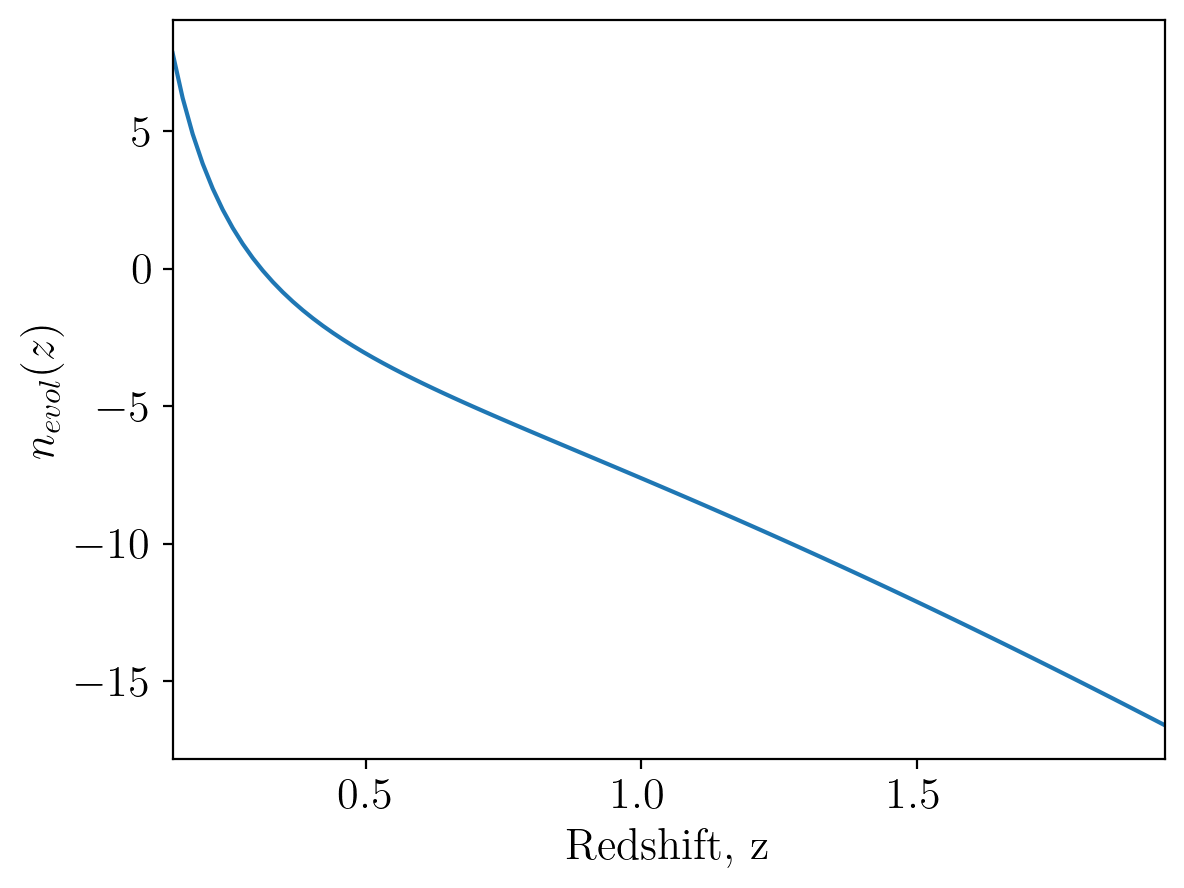

In [87]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 2.

num_evol_fid = nevol_fit(num_fit, z_lin)

plt.plot(z_lin, num_evol_fid, '-')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$n_{evol}(z)$');
#plt.title('Fitting model for the number desnsitiy evolution');

In [88]:
# Select the marginalized covariance matrix for the number evolution
cov_Joint_numevol = Sigma_Matrix_Joint50x30[12:16, 12:16]
cov_numevol_priors = Cov_prior_all[12:16, 12:16]


# Generate parameter samples from multivariate normal distribution
num_samples = 1000
nevol_Joint_pars_samples = np.random.multivariate_normal(num_fit, cov_Joint_numevol, num_samples)
nevol_samples_priors = np.random.multivariate_normal(num_fit, cov_numevol_priors, num_samples)


# Evaluate fitting function for each parameter sample
nevol_Joint_samples = np.array([nevol_fit(pars, z_lin) for pars in nevol_Joint_pars_samples])
nevol_samples_priors = np.array([nevol_fit(pars, z_lin) for pars in nevol_samples_priors])

# Calculate the 68% confidence interval
nevol_Joint_lower_bound = np.percentile(nevol_Joint_samples, 16, axis=0)
nevol_Joint_upper_bound = np.percentile(nevol_Joint_samples, 84, axis=0)
nevol_lower_bound_priors = np.percentile(nevol_samples_priors, 16, axis=0)
nevol_upper_bound_priors = np.percentile(nevol_samples_priors, 84, axis=0)

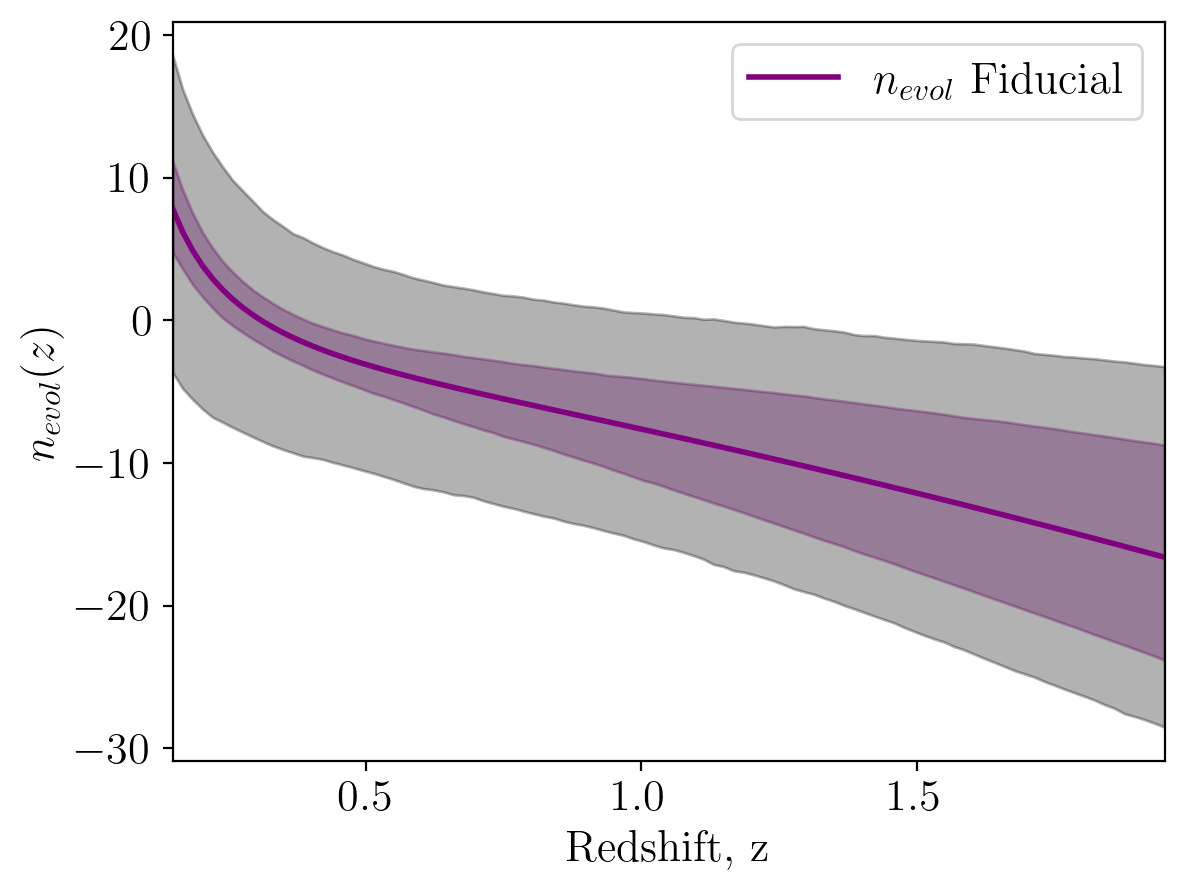

In [89]:
plt.plot(z_lin, num_evol_fid, '-', color='purple', label=r'$n_{evol}$'+' Fiducial', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, nevol_Joint_lower_bound, nevol_Joint_upper_bound, color='purple', alpha=0.3)
plt.fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3)


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$n_{evol}(z)$')
plt.legend();

## Evolution bias

The evolution bias is computed from the magnification biases and the evolution of the number densities.

$$ f^{evol}_{B}(z) = -\frac{d\log{N_B(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_B(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) - \frac{5}{2}s_B(z)\,\frac{d\log{F_c}}{d\log{(1+z)}} $$

$$ f^{evol}_{F}(z) = -\frac{d\log{N_F(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_F(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) 
    - \frac{5}{2}\left[\frac{\bar{N}}{\bar{N}_F}\,s_{model}(z)\frac{d\log{F_*}}{d\log{(1+z)}}-\frac{\bar{N}_B}{\bar{N}_F}\,s_B(z)\frac{d\log{F_c}}{d\log{(1+z)}}\right] $$

We have all the ingredients defined as methods in the EvolutionBias class. We need to extract the relevant terms and then sample togeter the $n_{evol}$ and magnification bias parameters to construct the predictions for each evolution bias. 

In [90]:
from biasmodels import EvolutionBias

In [91]:
myEvolBias_50 = EvolutionBias(n_split=m_50)
myEvolBias_30 = EvolutionBias(n_split=m_30)


dlogH = myEvolBias_50.dlogH
rHterm = myEvolBias_50.rHterm
dFstar = myEvolBias_50.dLogFstar
dFcut = myEvolBias_50.dLogFcut

In [92]:
def fevol_bright(pars_s, pars_n, z):
    pars_sB = pars_s[:4] 
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*magbias_fit(params=pars_sB, x=z))*rHterm(z) - 5*magbias_fit(params=pars_sB, x=z) - 5/2*magbias_fit(params=pars_sB, x=z)*dFcut(z)
    
def fevol_faint(pars_s, pars_n, z):
    
    pars_sB = pars_s[:4]
    pars_sM = pars_s[4:]
    s_B = magbias_fit(params=pars_sB, x=z)
    s_M = magbias_fit(params=pars_sM, x=z)
    s_faint = s_M*m_split/(m_split-1) - s_B/(m_split-1)
    
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*s_faint)*rHterm(z) - 5*s_faint + 5/2*((1/(m_split-1)) * s_B *dFcut(z) - (m_split/(m_split-1)) * s_M *dFstar(z))

In [93]:
sbias_fid_50 = np.concatenate([sB_4fit50, sM_4fit])
sbias_fid_30 = np.concatenate([sB_4fit30, sM_4fit])

np.shape(sbias_fid_50), np.shape(sbias_fid_30)

((8,), (8,))

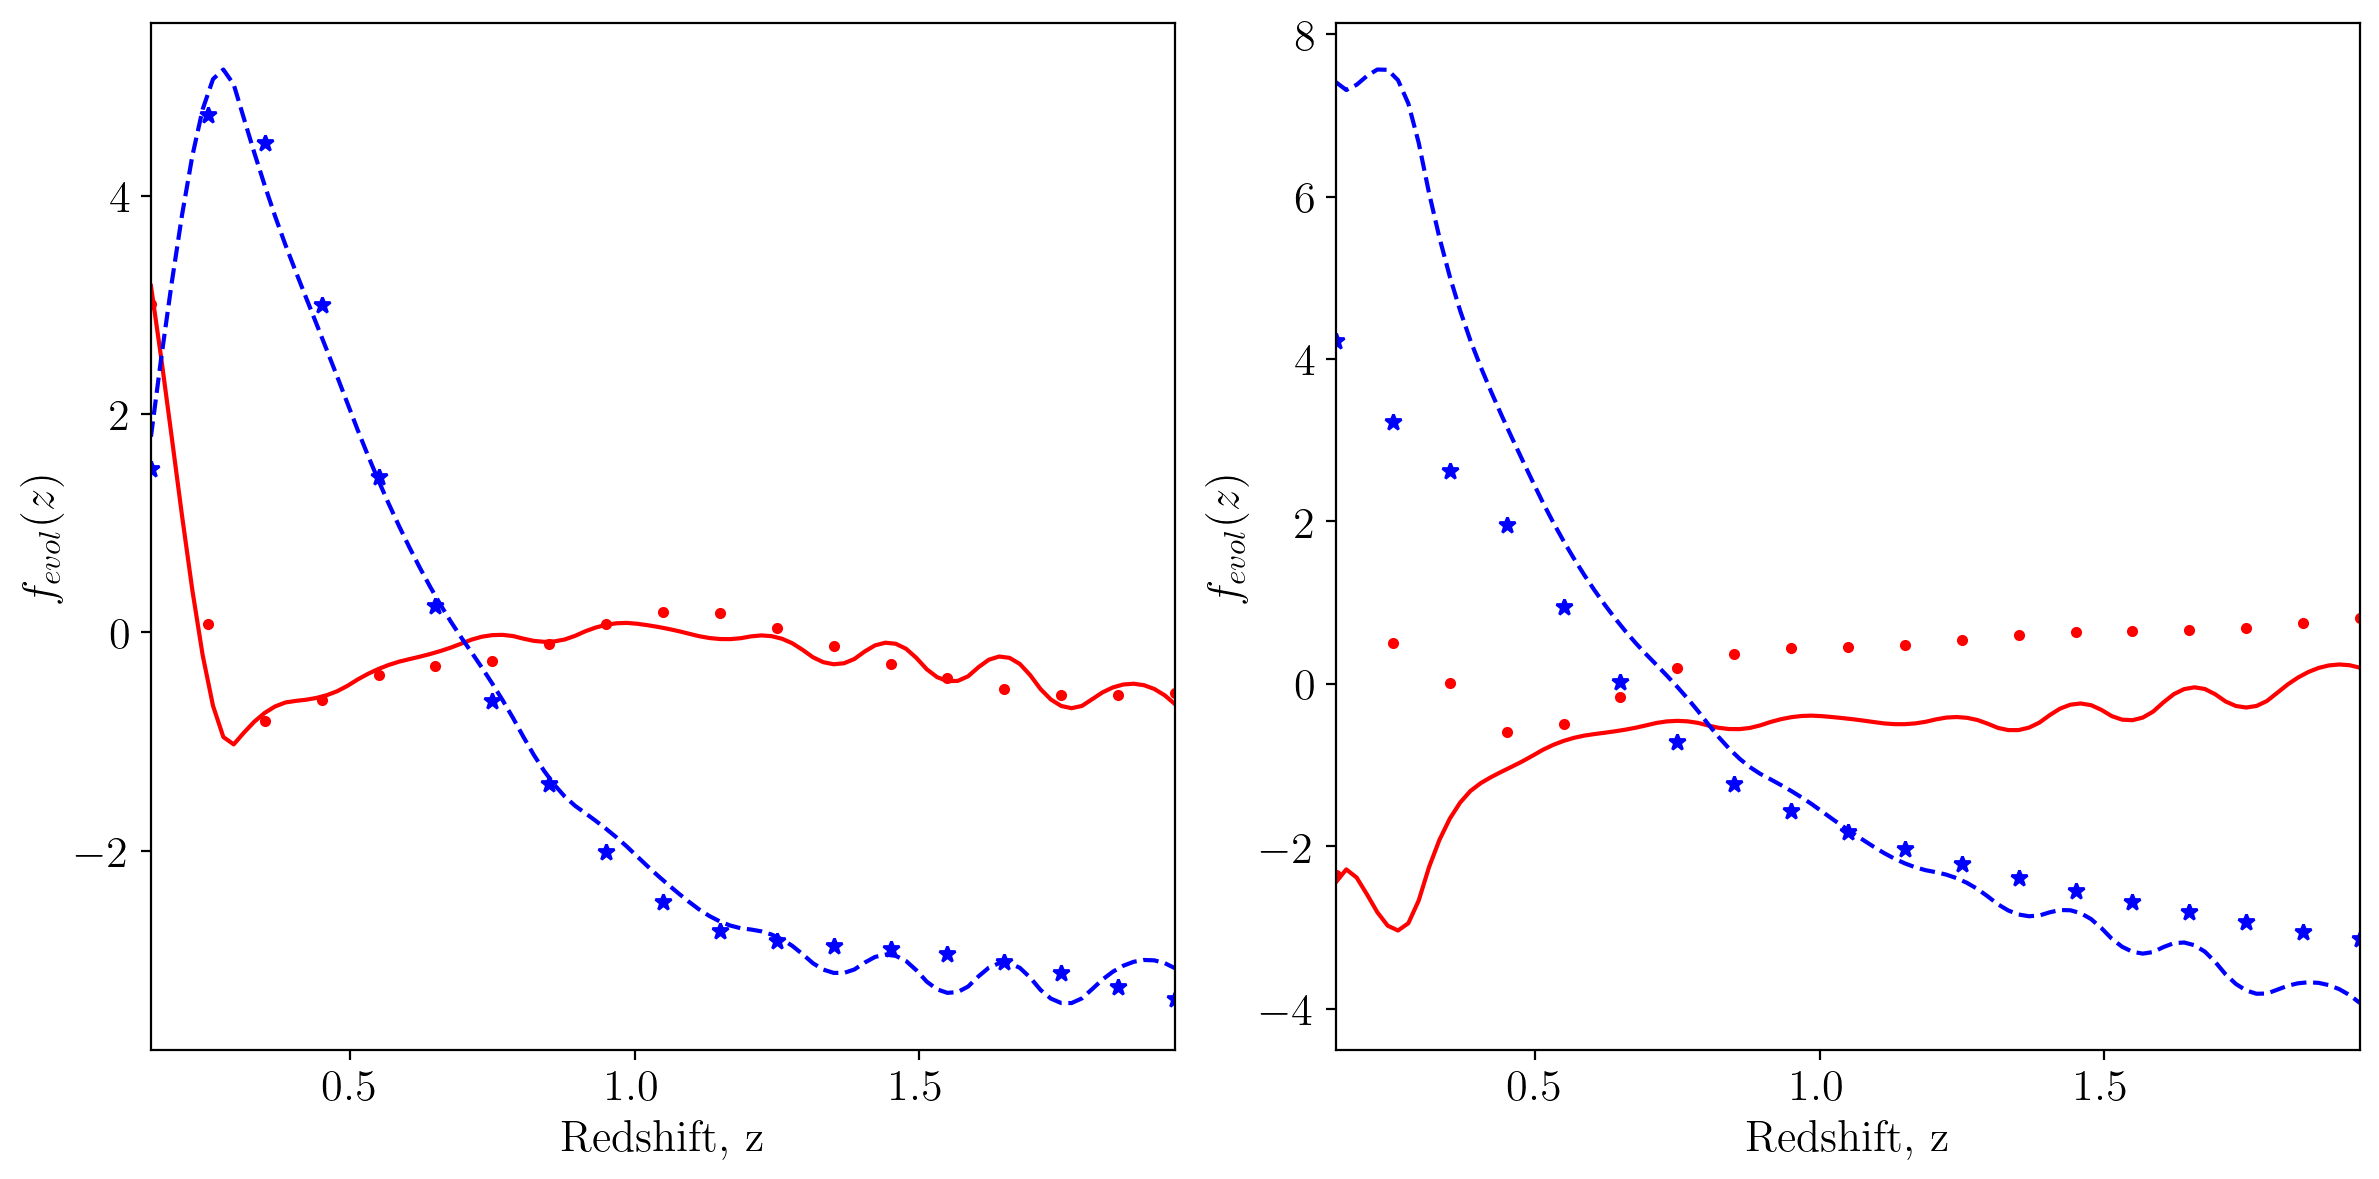

In [94]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

fevol_50_B_fid = fevol_bright(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)
fevol_50_F_fid = fevol_faint(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)

fevol_30_B_fid = fevol_bright(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)
fevol_30_F_fid = fevol_faint(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)

feB_50 = myEvolBias_50.fevol_bright(z_bins)
feF_50 = myEvolBias_50.fevol_faint(z_bins)

feB_30 = myEvolBias_30.fevol_bright(z_bins)
feF_30 = myEvolBias_30.fevol_faint(z_bins)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, 'r-')
ax[0].plot(z_lin, fevol_50_F_fid, 'b--')
ax[0].plot(z_bins, feB_50, 'r.', label='Bright')
ax[0].plot(z_bins, feF_50, 'b*', label='Faint')

ax[1].plot(z_lin, fevol_30_B_fid, 'r-')
ax[1].plot(z_lin, fevol_30_F_fid, 'b--')
ax[1].plot(z_bins, feB_30, 'r.', label='Bright')
ax[1].plot(z_bins, feF_30, 'b*', label='Faint')

for axi in ax:
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlabel(r'Redshift, z');
    axi.set_ylabel(r'$f_{evol}(z)$');

In [95]:
list(range(4,8))

[4, 5, 6, 7]

In [96]:
# Select the marginalized covariance matrix for the parameters

cov_Joint_all = Sigma_Matrix_Joint50x30[:16, :16]
cov_all_priors = Cov_prior_all[:16, :16]

all_fid = np.concatenate([sbias_fid, num_fit])

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
all_Joint_pars_samples = np.random.multivariate_normal(all_fid, cov_Joint_all, num_samples)
all_pars_samples_priors = np.random.multivariate_normal(all_fid, cov_all_priors, num_samples)

nind_50 = list(range(4,8))

all_Joint_50_pars_samples = all_Joint_pars_samples
all_Joint_50_pars_samples = np.delete(all_Joint_50_pars_samples, nind_50, axis=1)
all_50_pars_samples_priors = all_pars_samples_priors
all_50_pars_samples_priors = np.delete(all_50_pars_samples_priors, nind_50, axis=1)

nind_30 = list(range(0,4))

all_Joint_30_pars_samples = all_Joint_pars_samples
all_Joint_30_pars_samples = np.delete(all_Joint_30_pars_samples, nind_30, axis=1)
all_30_pars_samples_priors = all_pars_samples_priors
all_30_pars_samples_priors = np.delete(all_30_pars_samples_priors, nind_30, axis=1)

In [97]:
# Evaluate fitting function for each parameter sample

fevol_Joint_50_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_50_pars_samples])
fevol_Joint_50_B_samples_priors = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors])
fevol_Joint_50_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_50_pars_samples])
fevol_Joint_50_F_samples_priors = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors])

fevol_Joint_30_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_30_pars_samples])
fevol_Joint_30_B_samples_priors = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors])
fevol_Joint_30_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_Joint_30_pars_samples])
fevol_Joint_30_F_samples_priors = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors])

# Calculate the 68% confidence intervals

fevol_B_50_lower_bound = np.percentile(fevol_Joint_50_B_samples, 16, axis=0)
fevol_B_50_upper_bound = np.percentile(fevol_Joint_50_B_samples, 84, axis=0)
fevol_B_50_lower_bound_priors = np.percentile(fevol_Joint_50_B_samples_priors, 16, axis=0)
fevol_B_50_upper_bound_priors = np.percentile(fevol_Joint_50_B_samples_priors, 84, axis=0)

fevol_F_50_lower_bound = np.percentile(fevol_Joint_50_F_samples, 16, axis=0)
fevol_F_50_upper_bound = np.percentile(fevol_Joint_50_F_samples, 84, axis=0)
fevol_F_50_lower_bound_priors = np.percentile(fevol_Joint_50_F_samples_priors, 16, axis=0)
fevol_F_50_upper_bound_priors = np.percentile(fevol_Joint_50_F_samples_priors, 84, axis=0)

fevol_B_30_lower_bound = np.percentile(fevol_Joint_30_B_samples, 16, axis=0)
fevol_B_30_upper_bound = np.percentile(fevol_Joint_30_B_samples, 84, axis=0)
fevol_B_30_lower_bound_priors = np.percentile(fevol_Joint_30_B_samples_priors, 16, axis=0)
fevol_B_30_upper_bound_priors = np.percentile(fevol_Joint_30_B_samples_priors, 84, axis=0)

fevol_F_30_lower_bound = np.percentile(fevol_Joint_30_F_samples, 16, axis=0)
fevol_F_30_upper_bound = np.percentile(fevol_Joint_30_F_samples, 84, axis=0)
fevol_F_30_lower_bound_priors = np.percentile(fevol_Joint_30_F_samples_priors, 16, axis=0)
fevol_F_30_upper_bound_priors = np.percentile(fevol_Joint_30_F_samples_priors, 84, axis=0)

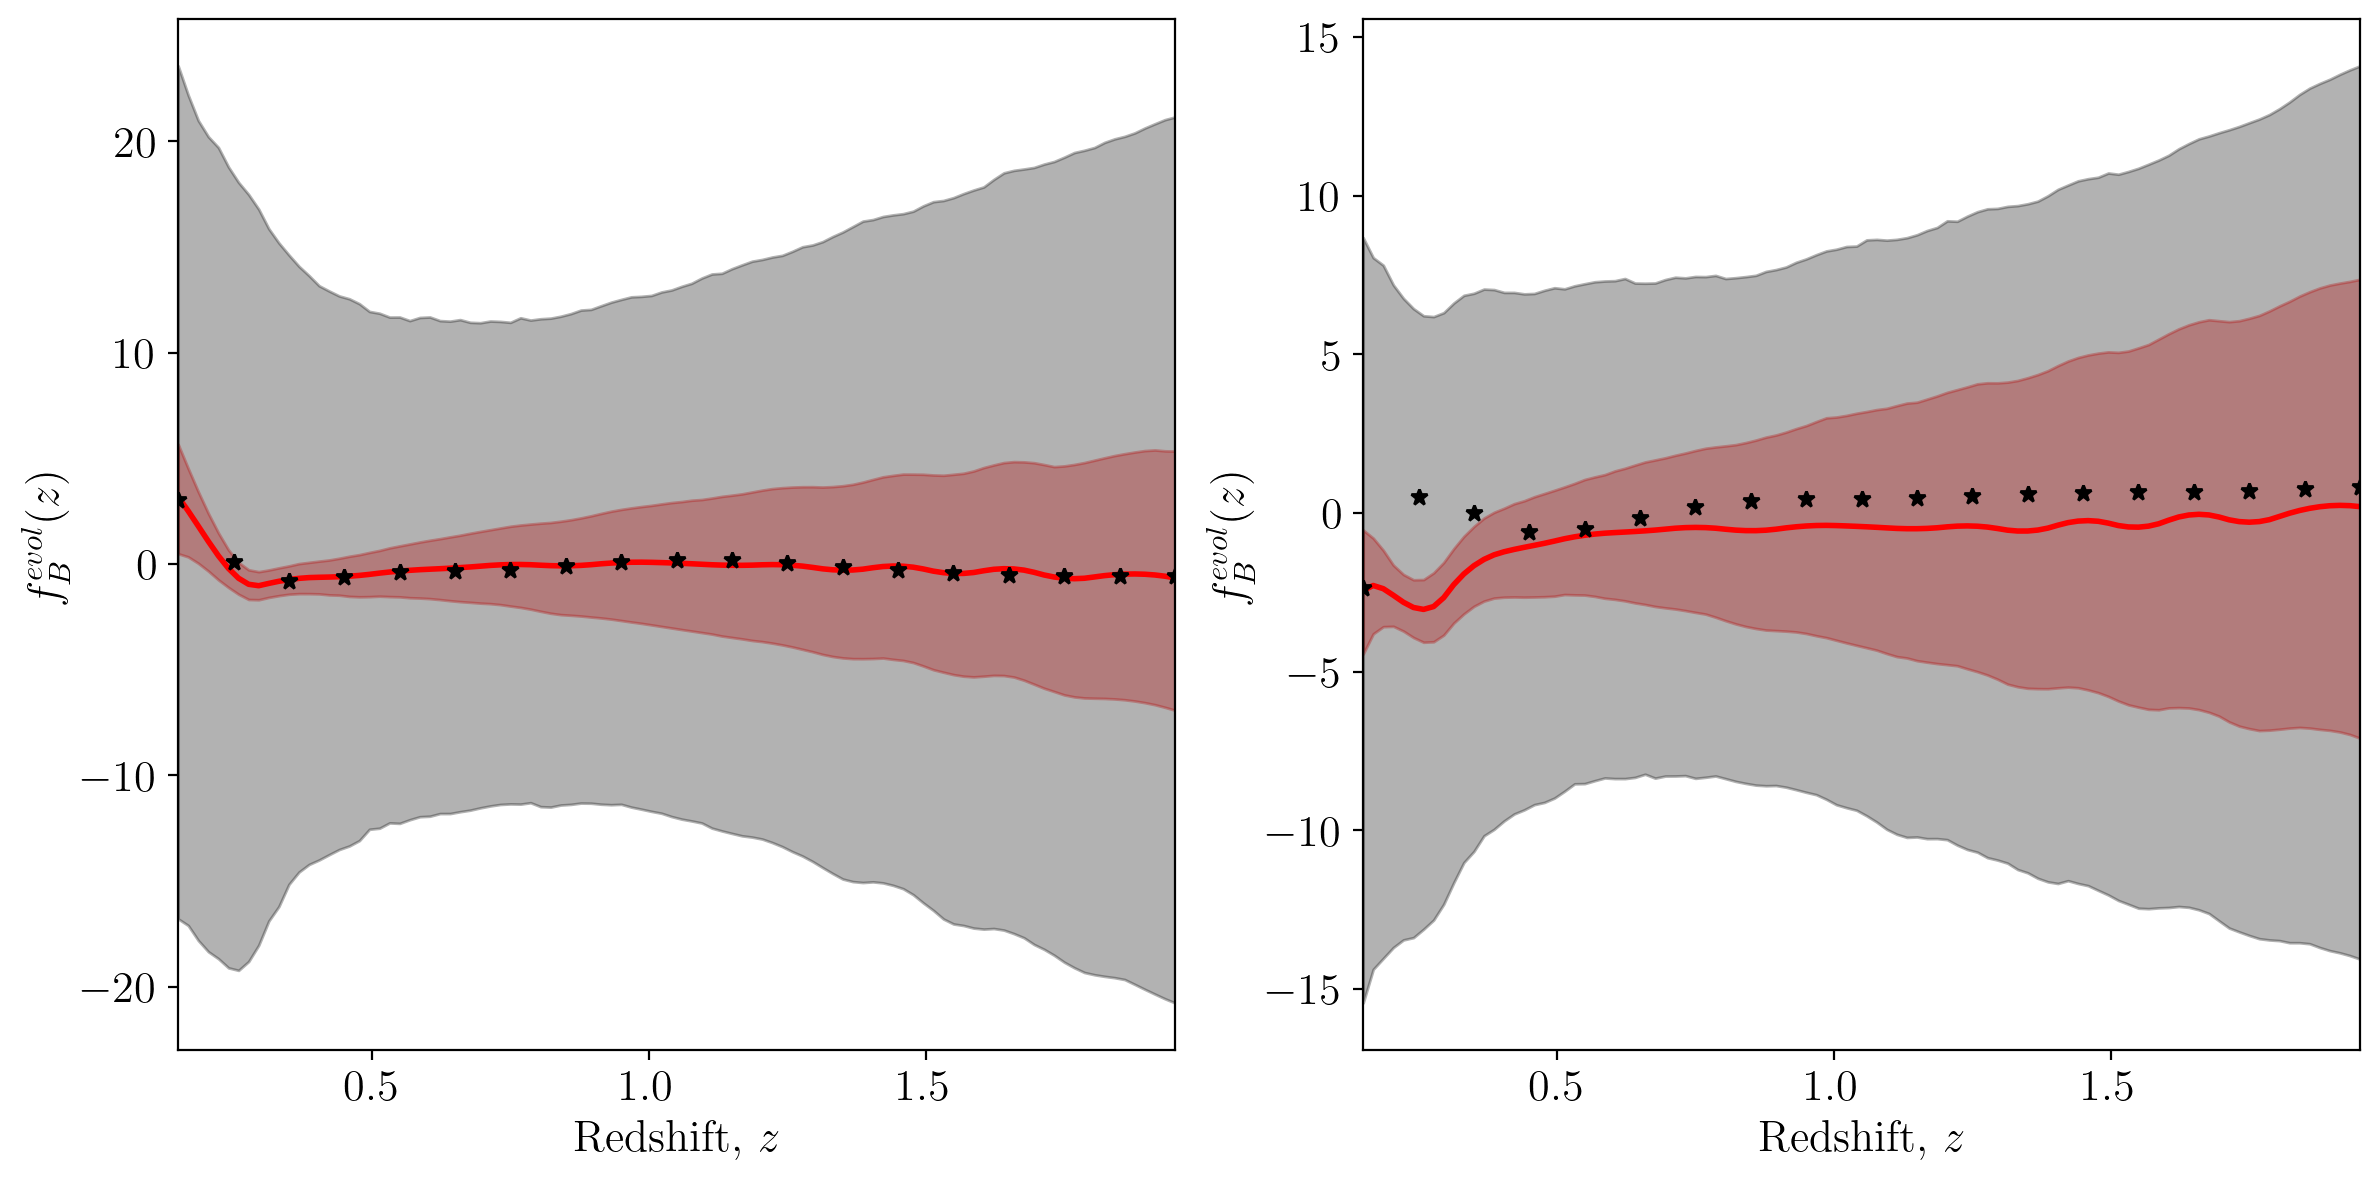

In [98]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, '-', color='red', lw = 2.0)
ax[0].plot(z_bins, feB_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_B_fid, '-', color='red', lw = 2.0)
ax[1].plot(z_bins, feB_30, '*', color='black')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, fevol_B_50_lower_bound, fevol_B_50_upper_bound, color='red', alpha=0.3)
ax[0].fill_between(z_lin, fevol_B_50_lower_bound_priors, fevol_B_50_upper_bound_priors, color='black', alpha=0.3)

ax[1].fill_between(z_lin, fevol_B_30_lower_bound, fevol_B_30_upper_bound, color='red', alpha=0.3)
ax[1].fill_between(z_lin, fevol_B_30_lower_bound_priors, fevol_B_30_upper_bound_priors, color='black', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_B(z)$')

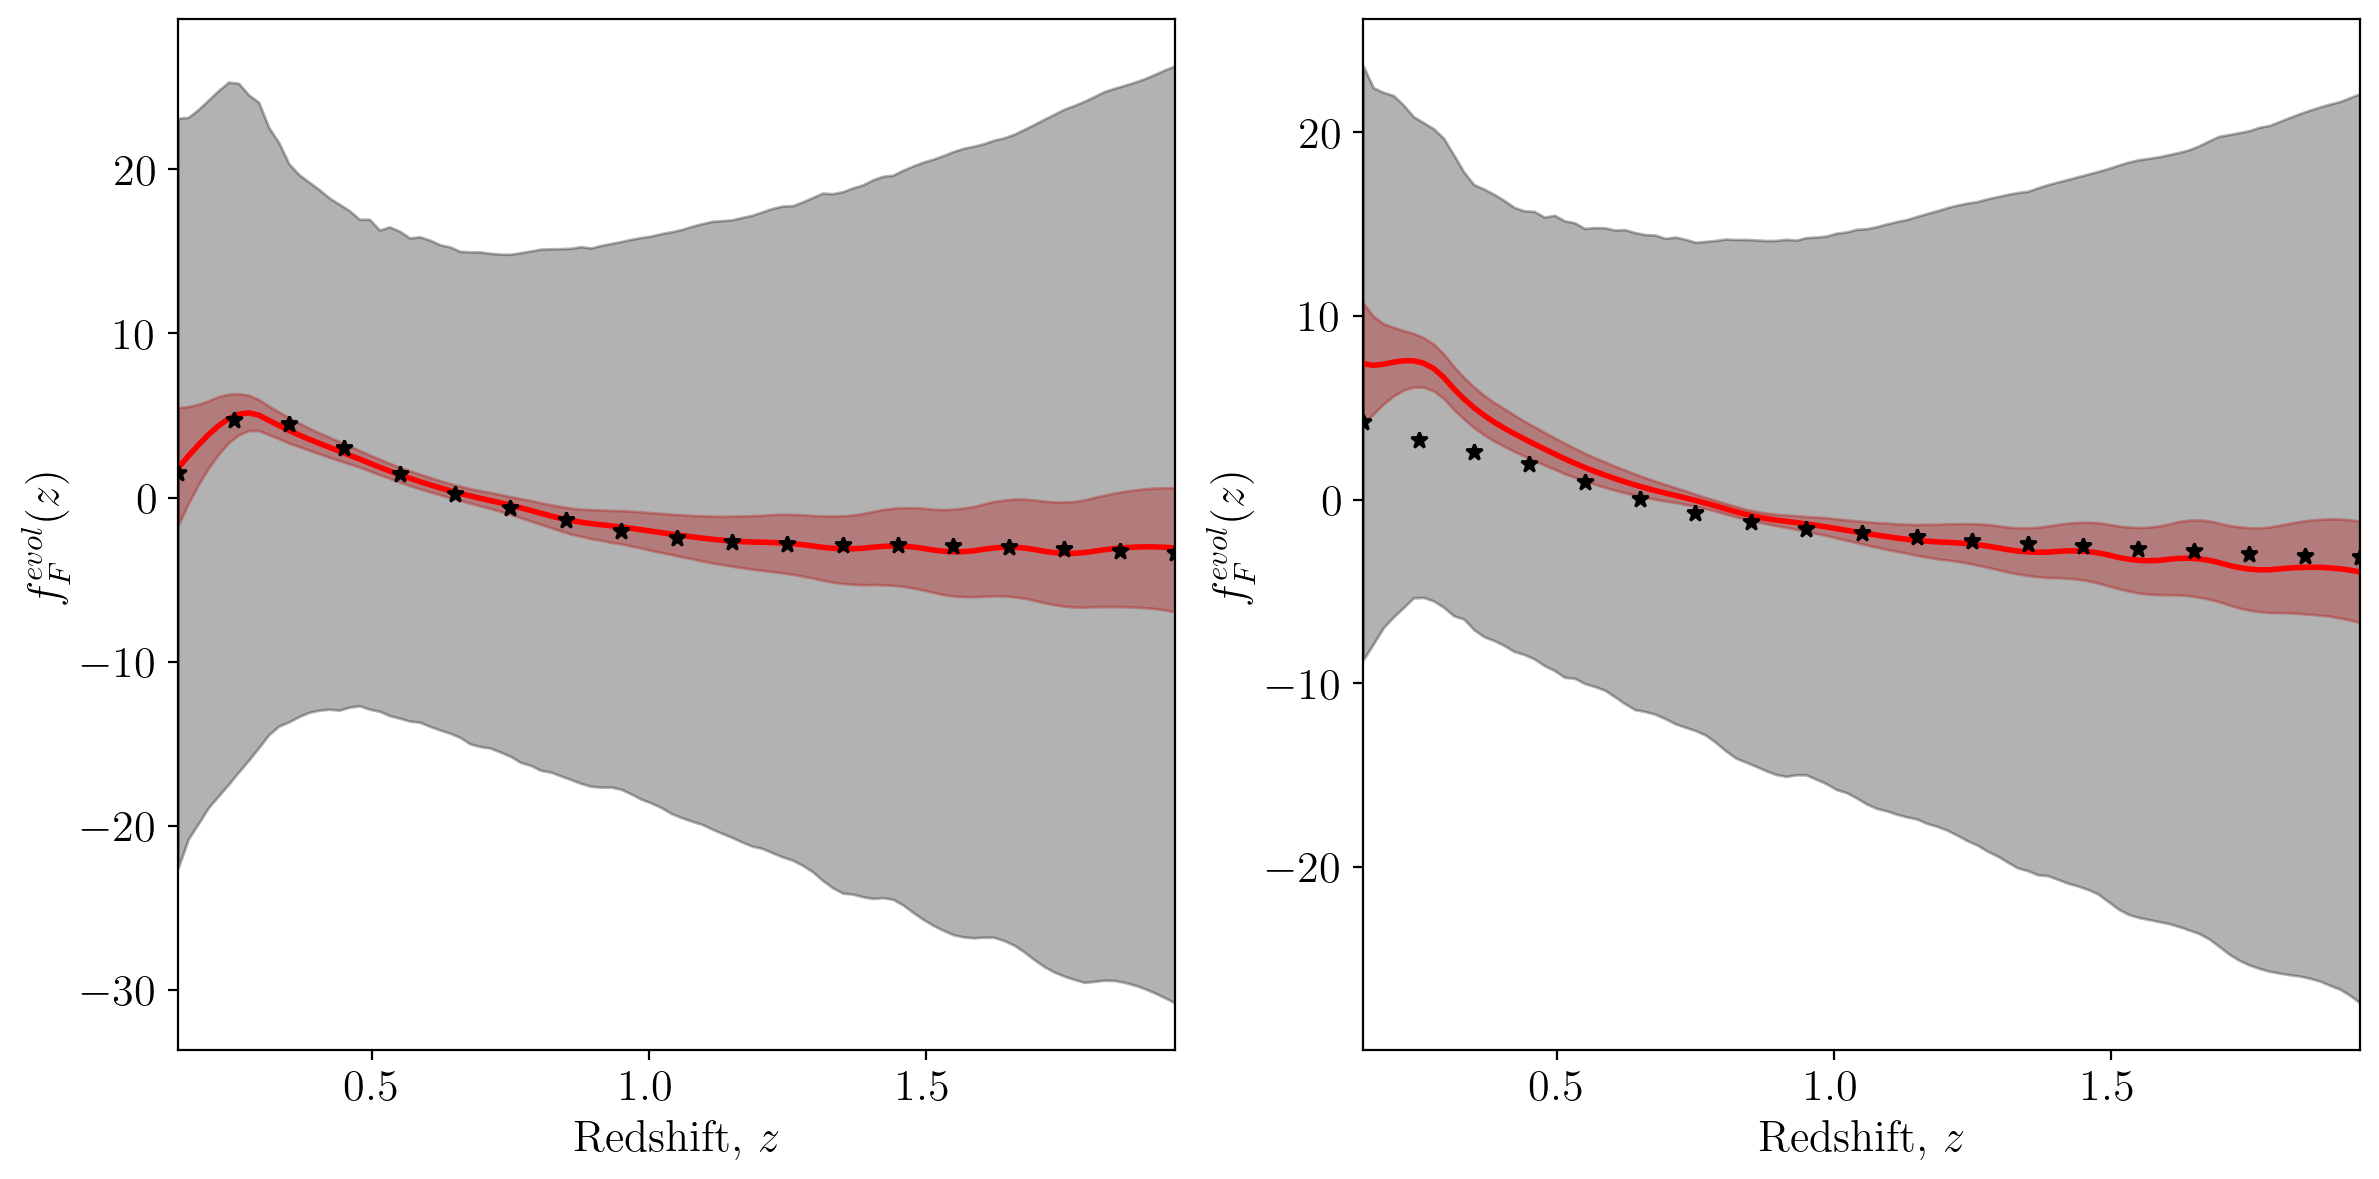

In [99]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_F_fid, '-', color='red', lw = 2.0)
ax[0].plot(z_bins, feF_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_F_fid, '-', color='red', lw = 2.0)
ax[1].plot(z_bins, feF_30, '*', color='black')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, fevol_F_50_lower_bound, fevol_F_50_upper_bound, color='red', alpha=0.3)
ax[0].fill_between(z_lin, fevol_F_50_lower_bound_priors, fevol_F_50_upper_bound_priors, color='black', alpha=0.3)

ax[1].fill_between(z_lin, fevol_F_30_lower_bound, fevol_F_30_upper_bound, color='red', alpha=0.3)
ax[1].fill_between(z_lin, fevol_F_30_lower_bound_priors, fevol_F_30_upper_bound_priors, color='black', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_F(z)$')

# Comparison with Individual Splits

## Magnification bias

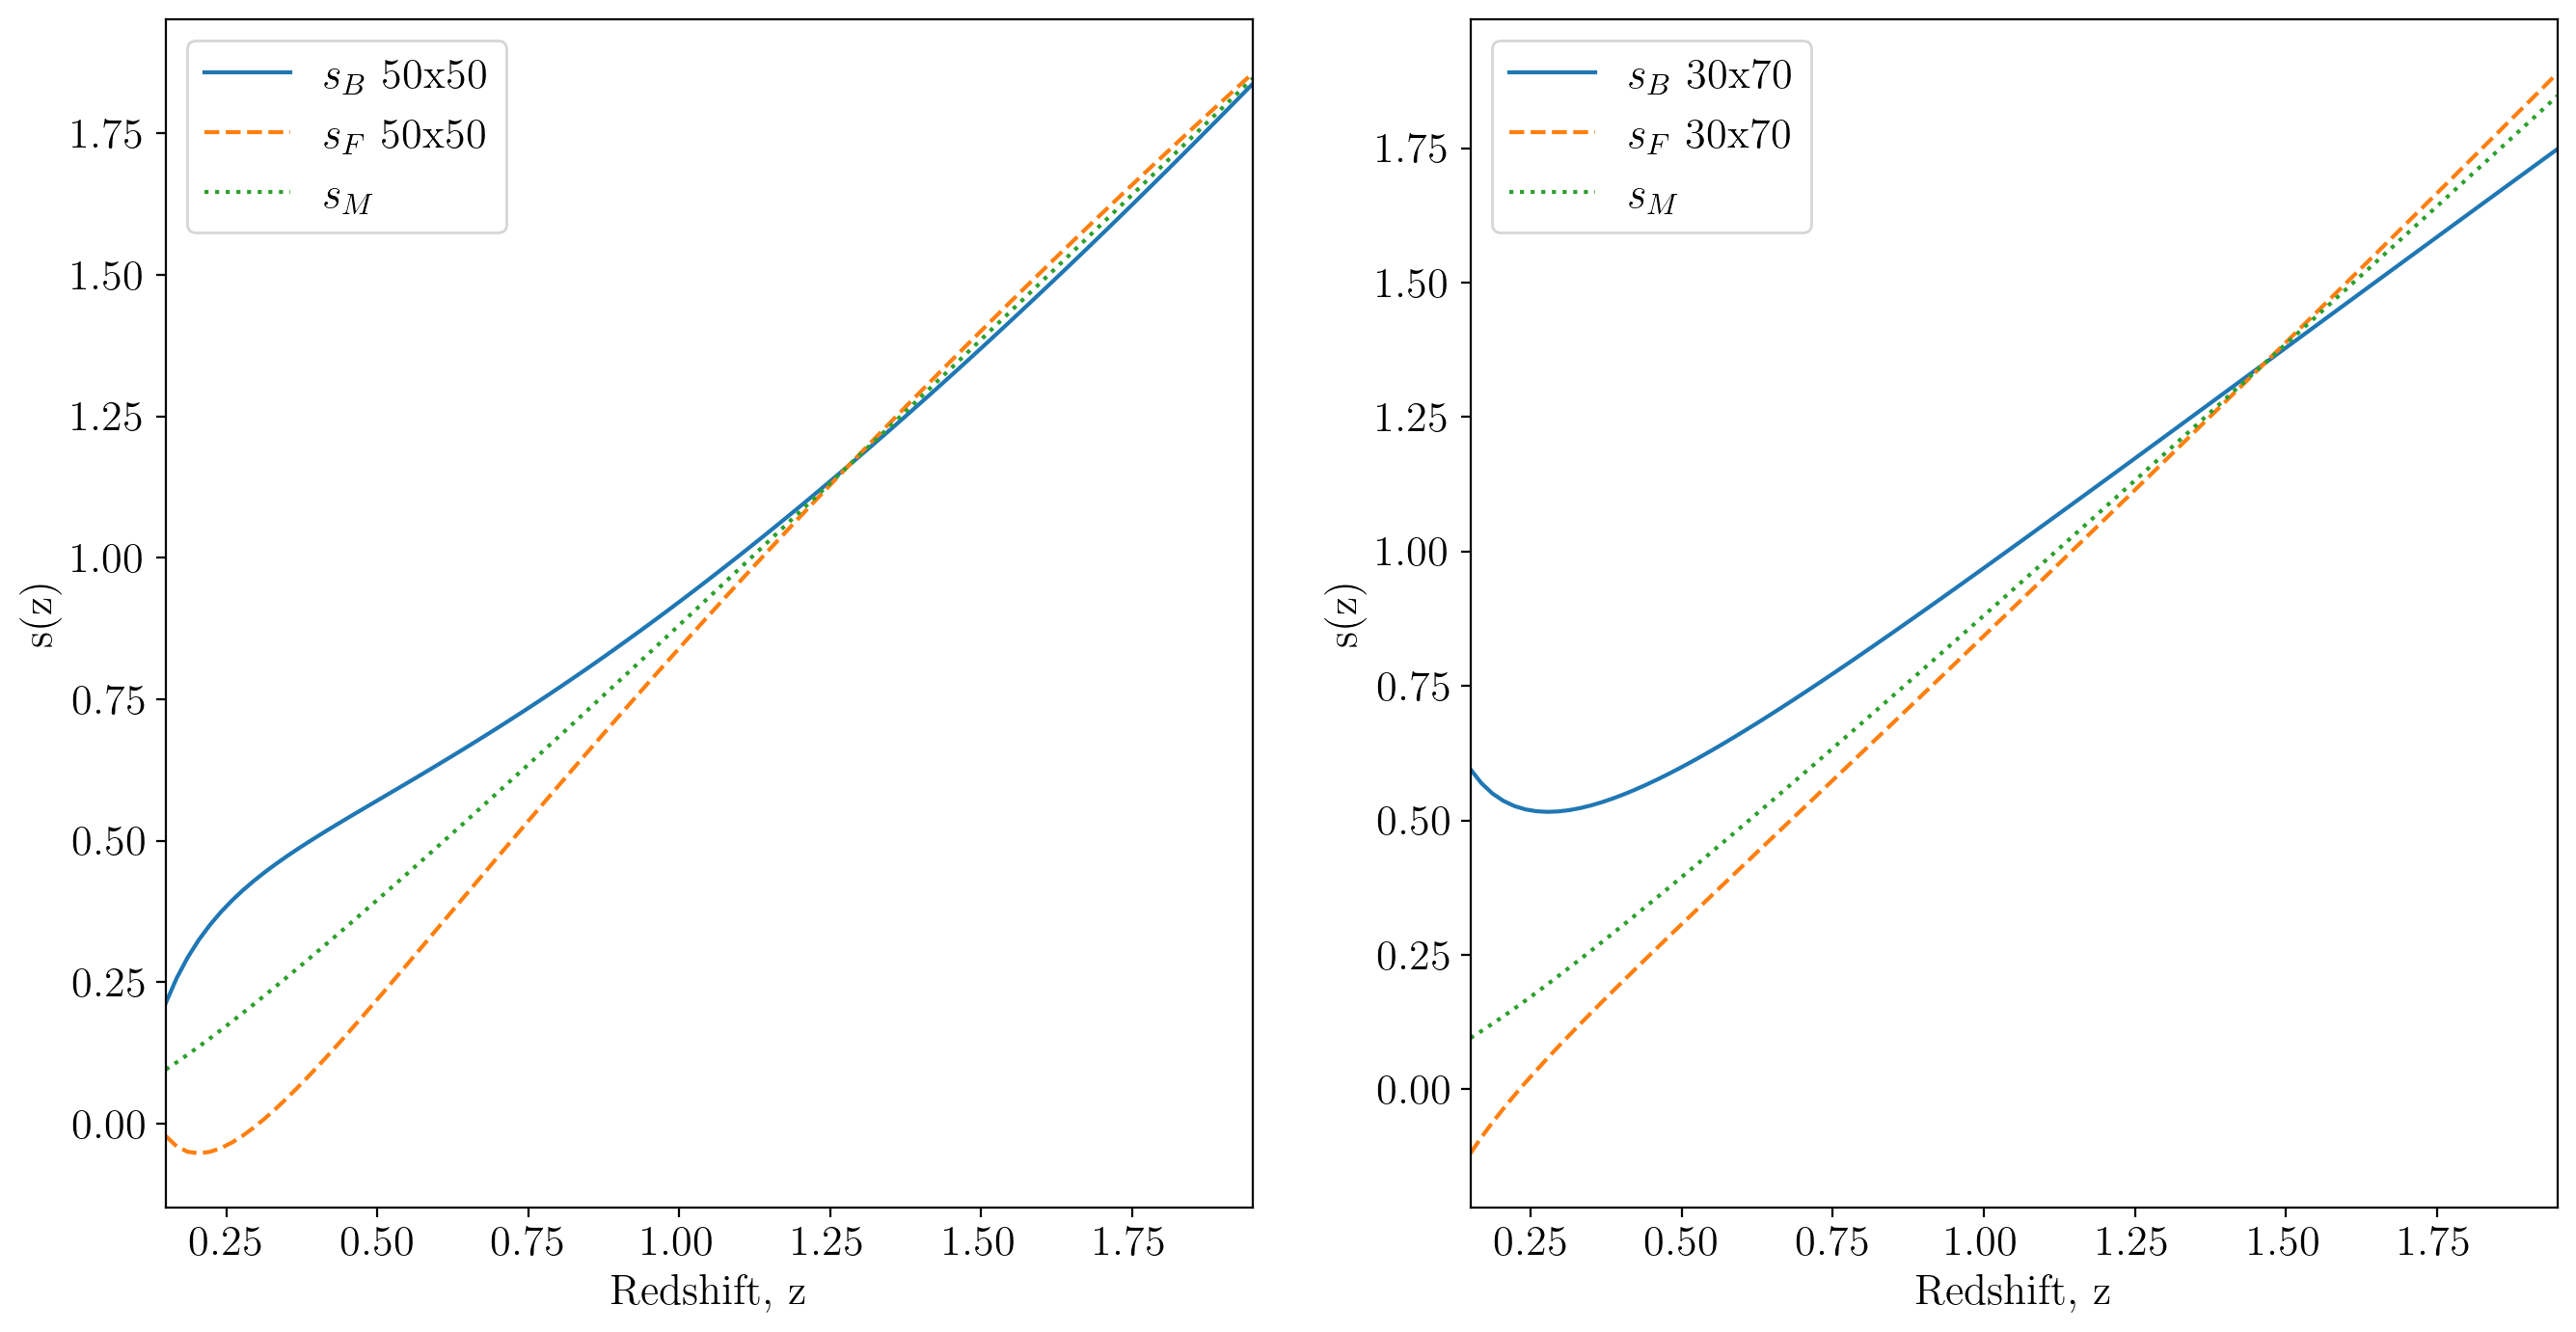

In [100]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

m_50 = 2.
m_30 = 10/3.

sB_fid_50 = magbias_fit(sB_fit[:4], z_lin)
sB_fid_30 = magbias_fit(sB_fit[4:], z_lin)
sM_fid = magbias_fit(sM_4fit, z_lin)
sF_fid_50 = sM_fid * (m_50/(m_50-1)) - sB_fid_50/(m_50-1)
sF_fid_30 = sM_fid * (m_30/(m_30-1)) - sB_fid_30/(m_30-1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, '-', label=r'$s_B$ 50x50')
ax[0].plot(z_lin, sF_fid_50, '--', label=r'$s_F$ 50x50')
ax[0].plot(z_lin, sM_fid, ':', label=r'$s_M$')

ax[1].plot(z_lin, sB_fid_30, '-', label=r'$s_B$ 30x70')
ax[1].plot(z_lin, sF_fid_30, '--', label=r'$s_F$ 30x70')
ax[1].plot(z_lin, sM_fid, ':', label=r'$s_M$')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r's(z)')
    axi.legend();


### Observables: $s_B(z)$ and $s_M(z)$

In [101]:
# Compute priors 

# Select the marginalized covariance matrix for the magnification biases priors

cov_sB_50_priors = Cov_prior_all[:4, :4]
cov_sB_30_priors = Cov_prior_all[4:8, 4:8]
cov_sM_priors = Cov_prior_all[8:12, 8:12]

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
sB_50_pars_samples_priors = np.random.multivariate_normal(sB_4fit50, cov_sB_50_priors, num_samples)
sB_30_pars_samples_priors = np.random.multivariate_normal(sB_4fit30, cov_sB_30_priors, num_samples)
sM_pars_samples_priors = np.random.multivariate_normal(sM_4fit, cov_sM_priors, num_samples)

# Evaluate fitting function for each parameter sample

sB_50_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_50_pars_samples_priors])
sB_30_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_30_pars_samples_priors])

sM_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_priors])

# Calculate the 68% confidence interval

sB_50_lower_bound_priors = np.percentile(sB_50_samples_priors, 16, axis=0)
sB_50_upper_bound_priors = np.percentile(sB_50_samples_priors, 84, axis=0)

sB_30_lower_bound_priors = np.percentile(sB_30_samples_priors, 16, axis=0)
sB_30_upper_bound_priors = np.percentile(sB_30_samples_priors, 84, axis=0)

sM_lower_bound_priors = np.percentile(sM_samples_priors, 16, axis=0)
sM_upper_bound_priors = np.percentile(sM_samples_priors, 84, axis=0)


In [102]:
# Select the marginalized covariance matrix for the magnification biases

cov_sB_50 = Sigma_Matrix_50[:4, :4]
cov_sB_30 = Sigma_Matrix_30[:4, :4]
cov_sM_50 = Sigma_Matrix_50[4:8, 4:8]
cov_sM_30 = Sigma_Matrix_30[4:8, 4:8]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sB_50_pars_samples = np.random.multivariate_normal(sB_4fit50, cov_sB_50, num_samples)
sB_30_pars_samples = np.random.multivariate_normal(sB_4fit30, cov_sB_30, num_samples)
sM_50_pars_samples = np.random.multivariate_normal(sM_4fit, cov_sM_50, num_samples)
sM_30_pars_samples = np.random.multivariate_normal(sM_4fit, cov_sM_30, num_samples)

# Evaluate fitting function for each parameter sample
sB_50_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_50_pars_samples])
sB_30_samples = np.array([magbias_fit(pars, z_lin) for pars in sB_30_pars_samples])
sM_50_samples = np.array([magbias_fit(pars, z_lin) for pars in sM_50_pars_samples])
sM_30_samples = np.array([magbias_fit(pars, z_lin) for pars in sM_30_pars_samples])

# Calculate the 68% confidence interval
sB_50_lower_bound = np.percentile(sB_50_samples, 16, axis=0)
sB_50_upper_bound = np.percentile(sB_50_samples, 84, axis=0)

sB_30_lower_bound = np.percentile(sB_30_samples, 16, axis=0)
sB_30_upper_bound = np.percentile(sB_30_samples, 84, axis=0)

sM_50_lower_bound = np.percentile(sM_50_samples, 16, axis=0)
sM_50_upper_bound = np.percentile(sM_50_samples, 84, axis=0)
sM_30_lower_bound = np.percentile(sM_30_samples, 16, axis=0)
sM_30_upper_bound = np.percentile(sM_30_samples, 84, axis=0)

Predictions for $s_B(z)$ vs Priors

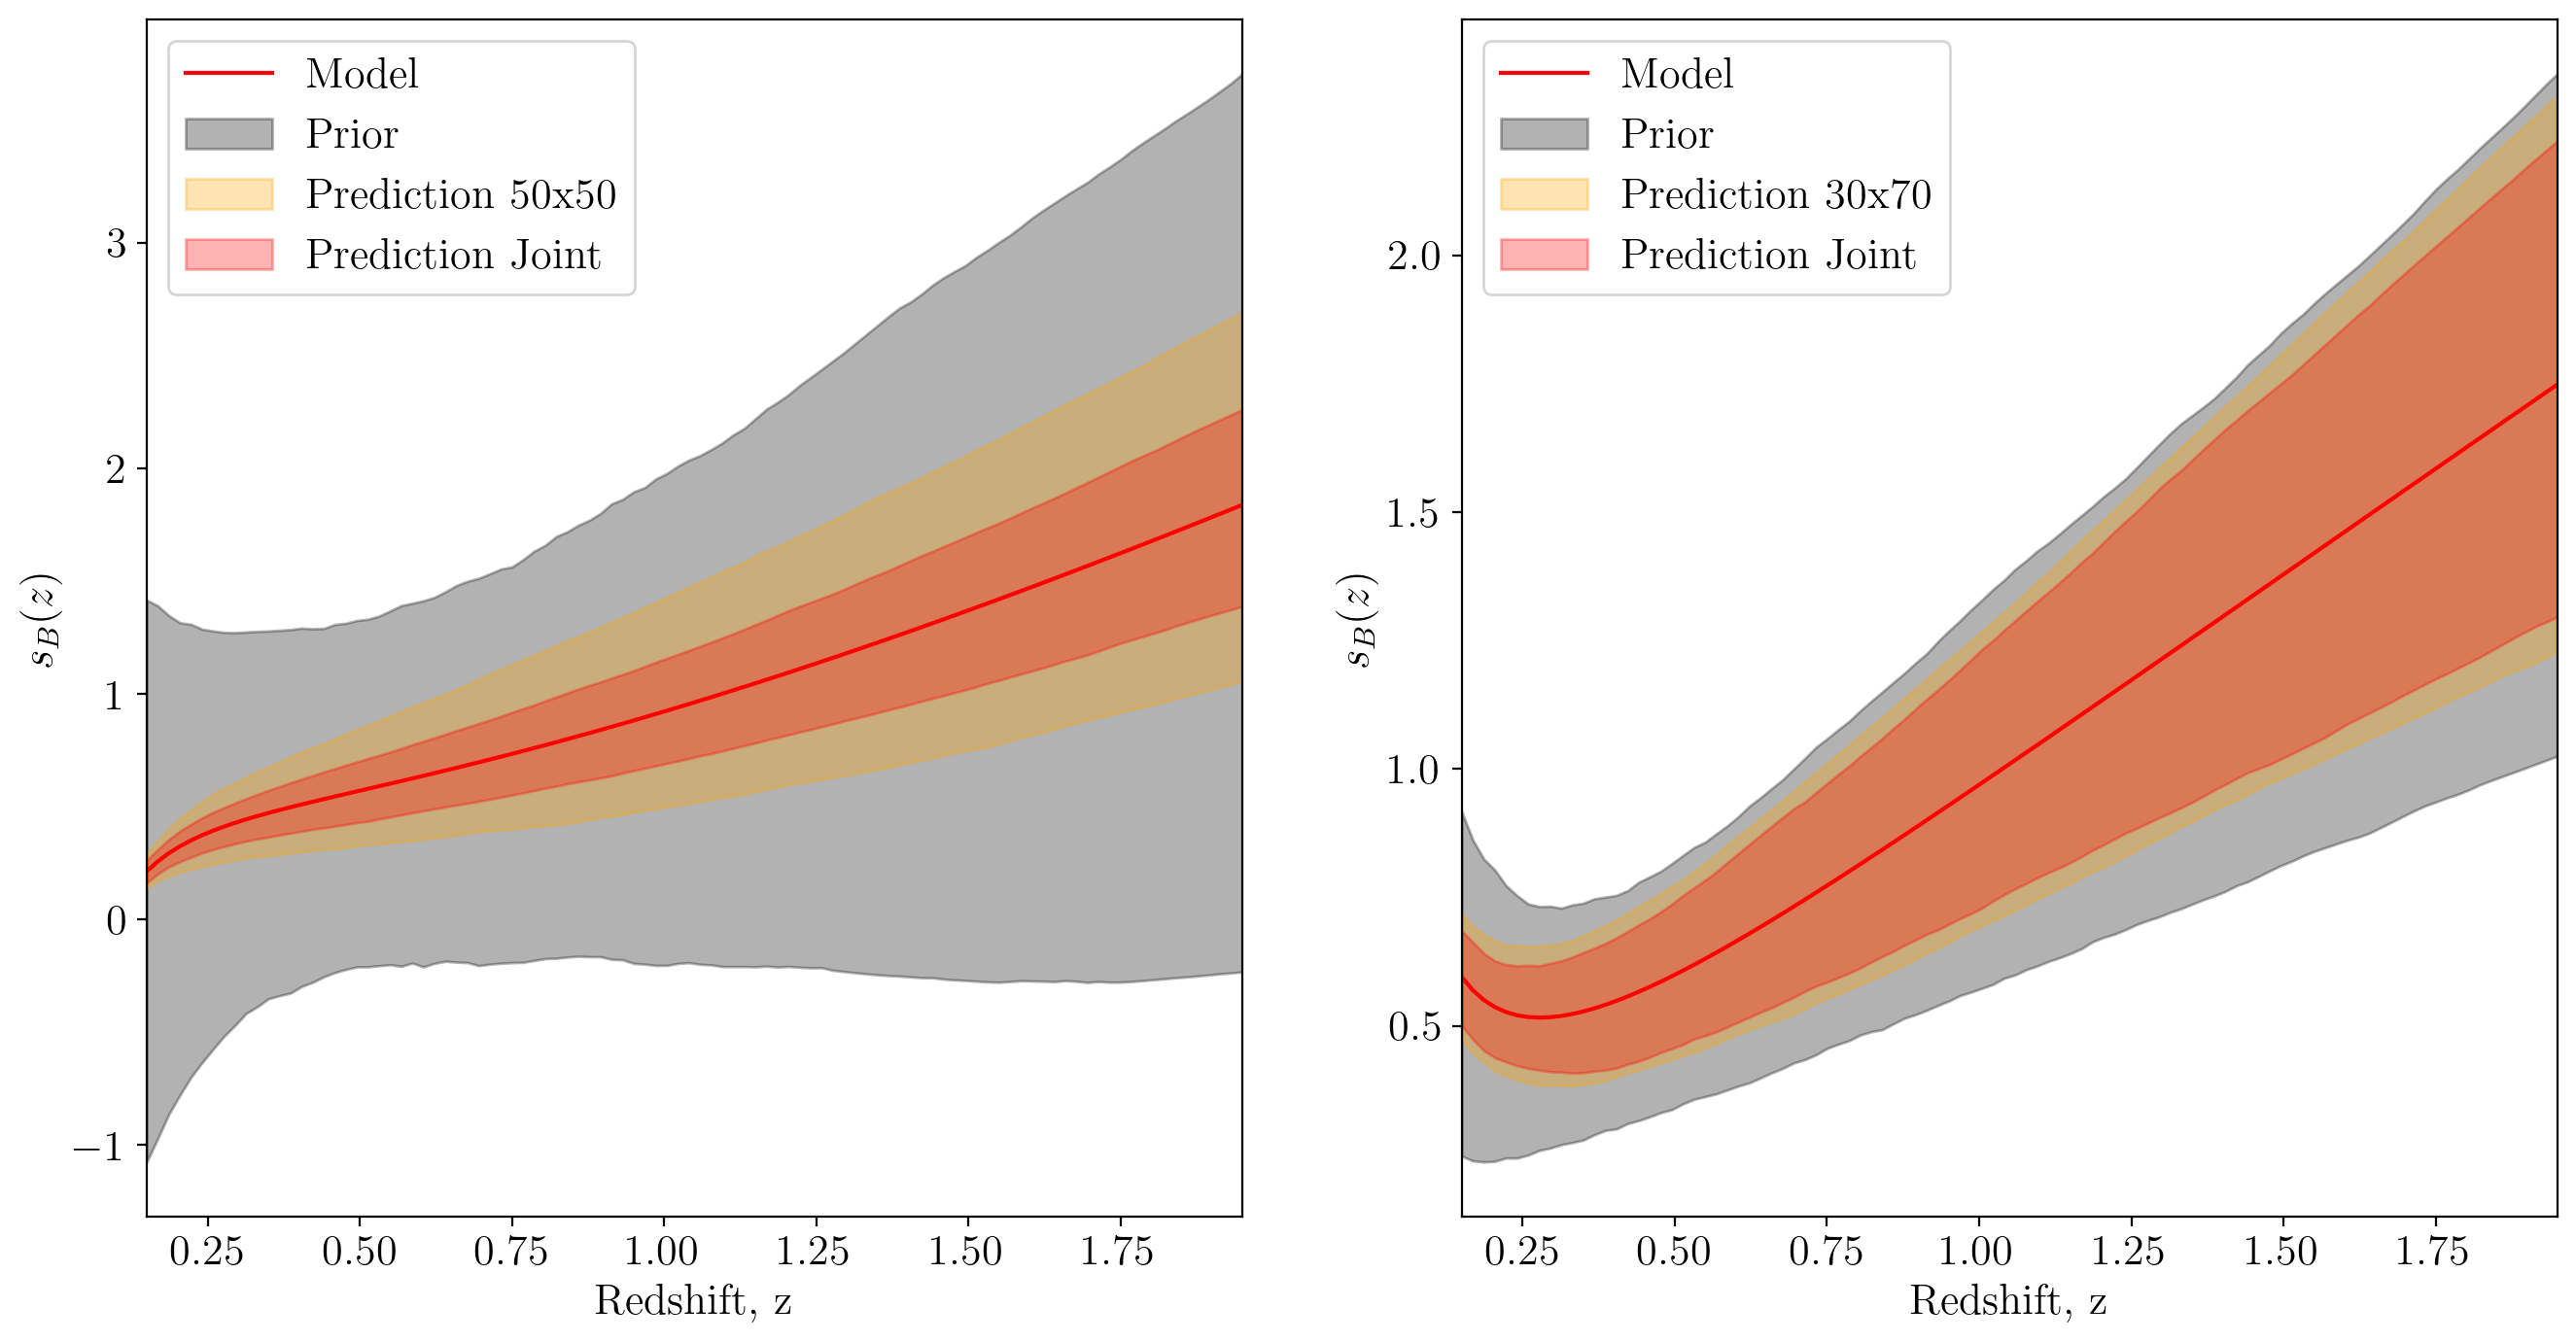

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sB_fid_50, 'r-', label = r'Model')
ax[0].fill_between(z_lin, sB_50_lower_bound_priors, sB_50_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, sB_50_lower_bound, sB_50_upper_bound, color='orange', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, sB_Joint_50_lower_bound, sB_Joint_50_upper_bound, color='red', alpha=0.3, label = 'Prediction Joint')
ax[0].legend(loc='upper left')

ax[1].plot(z_lin, sB_fid_30, 'r-', label = r'Model')
ax[1].fill_between(z_lin, sB_30_lower_bound_priors, sB_30_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, sB_30_lower_bound, sB_30_upper_bound, color='orange', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, sB_Joint_30_lower_bound, sB_Joint_30_upper_bound, color='red', alpha=0.3, label = 'Prediction Joint')
ax[1].legend(loc='upper left')

for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r'$s_B(z)$')

Predictions for $s_M(z)$ vs Priors

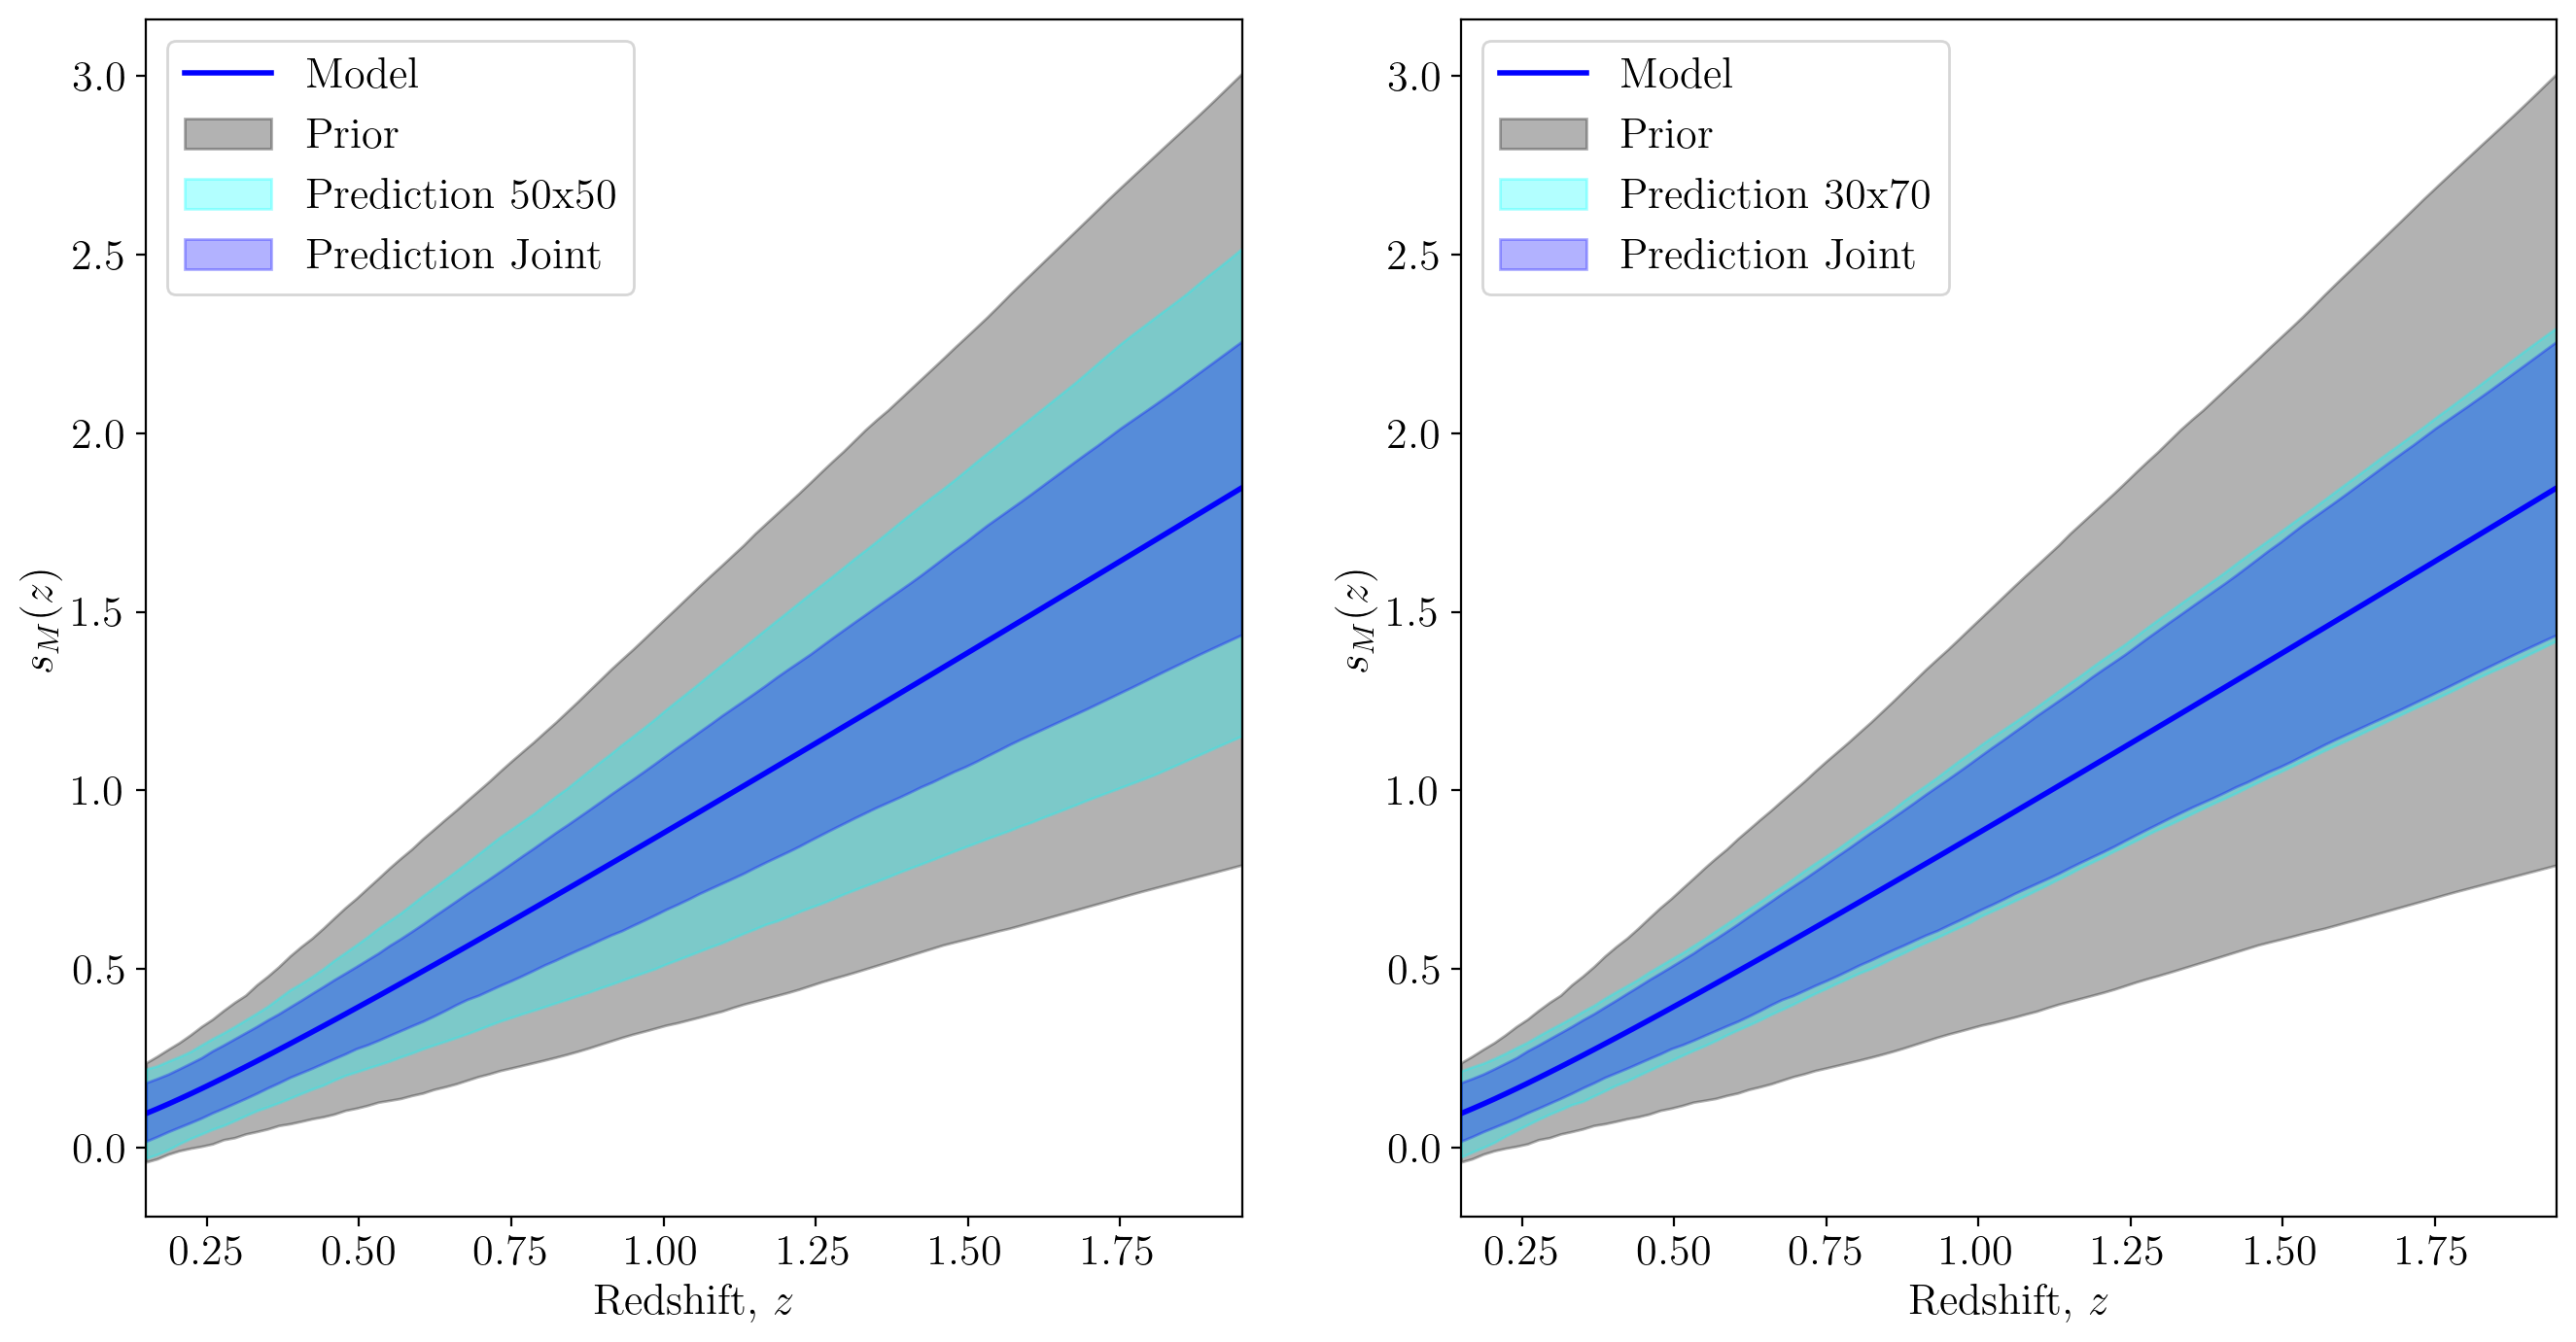

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

for axi in ax:
    axi.plot(z_lin, sM_fid, '-', lw = 2.0, color='blue', label = 'Model')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label = r'Prior')
ax[0].fill_between(z_lin, sM_50_lower_bound, sM_50_upper_bound, color='cyan', alpha=0.3, label = r'Prediction 50x50')
ax[0].fill_between(z_lin, sM_Joint_lower_bound, sM_Joint_upper_bound, color='blue', alpha=0.3, label = r'Prediction Joint')

ax[1].fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label = r'Prior')
ax[1].fill_between(z_lin, sM_30_lower_bound, sM_30_upper_bound, color='cyan', alpha=0.3, label = r'Prediction 30x70')
ax[1].fill_between(z_lin, sM_Joint_lower_bound, sM_Joint_upper_bound, color='blue', alpha=0.3, label = r'Prediction Joint')
    
for axi in ax:
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlabel(r'Redshift, $z$');
    axi.set_ylabel(r'$s_M(z)$');
    axi.legend(loc='upper left');


### Magnification bias of the Faint, $s_F(z)$

The magnification bias of the faint population is obtained by:

$$ s_F(z) = s_{model}(z)\frac{\bar{N}(z)}{\bar{N}_F(z)} - s_B(z)\frac{\bar{N}_B(z)}{\bar{N}_F(z)} = s_F(z) = s_{model}(z)\frac{m}{m-1} - s_B(z)\frac{1}{m-1} $$ 

We need to sample together the $s_B$ and $s_M$ parameters.

In [105]:
sbias_50_fid = np.concatenate([sB_4fit50, sM_4fit])
sbias_30_fid = np.concatenate([sB_4fit30, sM_4fit])

np.shape(sbias_50_fid), np.shape(sbias_30_fid)

((8,), (8,))

In [106]:
# Select the marginalized covariance matrix for the magnification biases together
cov_50_sbias = Sigma_Matrix_50[:8, :8]
cov_30_sbias = Sigma_Matrix_30[:8, :8]

# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_50_pars_samples = np.random.multivariate_normal(sbias_50_fid, cov_50_sbias, num_samples)
sbias_30_pars_samples = np.random.multivariate_normal(sbias_30_fid, cov_30_sbias, num_samples)


# Evaluate fitting function for each parameter sample
sB_50_samples = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_50_pars_samples])
sB_30_samples = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_30_pars_samples])
sM_50_samples = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_50_pars_samples])
sM_30_samples = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_30_pars_samples])


# Compute the sF for each sample
sF_50_samples = sM_50_samples*m_50/(m_50-1) - sB_50_samples/(m_50-1)
sF_30_samples = sM_30_samples*m_30/(m_30-1) - sB_30_samples/(m_30-1)


# Calculate the 68% confidence interval
sF_50_lower_bound = np.percentile(sF_50_samples, 16, axis=0)
sF_50_upper_bound = np.percentile(sF_50_samples, 84, axis=0)

sF_30_lower_bound = np.percentile(sF_30_samples, 16, axis=0)
sF_30_upper_bound = np.percentile(sF_30_samples, 84, axis=0)

Compare with priors

In [107]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_50_priors = Cov_priors_50[:8, :8]
cov_sbias_30_priors = Cov_priors_30[:8, :8]


# Generate parameter samples from multivariate normal distribution
num_samples = 1000
sbias_50_pars_samples_priors = np.random.multivariate_normal(sbias_50_fid, cov_sbias_50_priors, num_samples)
sbias_30_pars_samples_priors = np.random.multivariate_normal(sbias_30_fid, cov_sbias_30_priors, num_samples)


# Evaluate fitting function for each parameter sample
sB_50_samples_priors = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_50_pars_samples_priors])
sB_30_samples_priors = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_30_pars_samples_priors])
sM_50_samples_priors = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_50_pars_samples_priors])
sM_30_samples_priors = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_30_pars_samples_priors])

# Compute the sF for each sample
sF_50_samples_priors = sM_50_samples_priors*m_50/(m_50-1) - sB_50_samples_priors/(m_50-1)
sF_30_samples_priors = sM_30_samples_priors*m_30/(m_30-1) - sB_30_samples_priors/(m_30-1)

# Calculate the 68% confidence interval
sF_50_lower_bound_priors = np.percentile(sF_50_samples_priors, 16, axis=0)
sF_50_upper_bound_priors = np.percentile(sF_50_samples_priors, 84, axis=0)

sF_30_lower_bound_priors = np.percentile(sF_30_samples_priors, 16, axis=0)
sF_30_upper_bound_priors = np.percentile(sF_30_samples_priors, 84, axis=0)

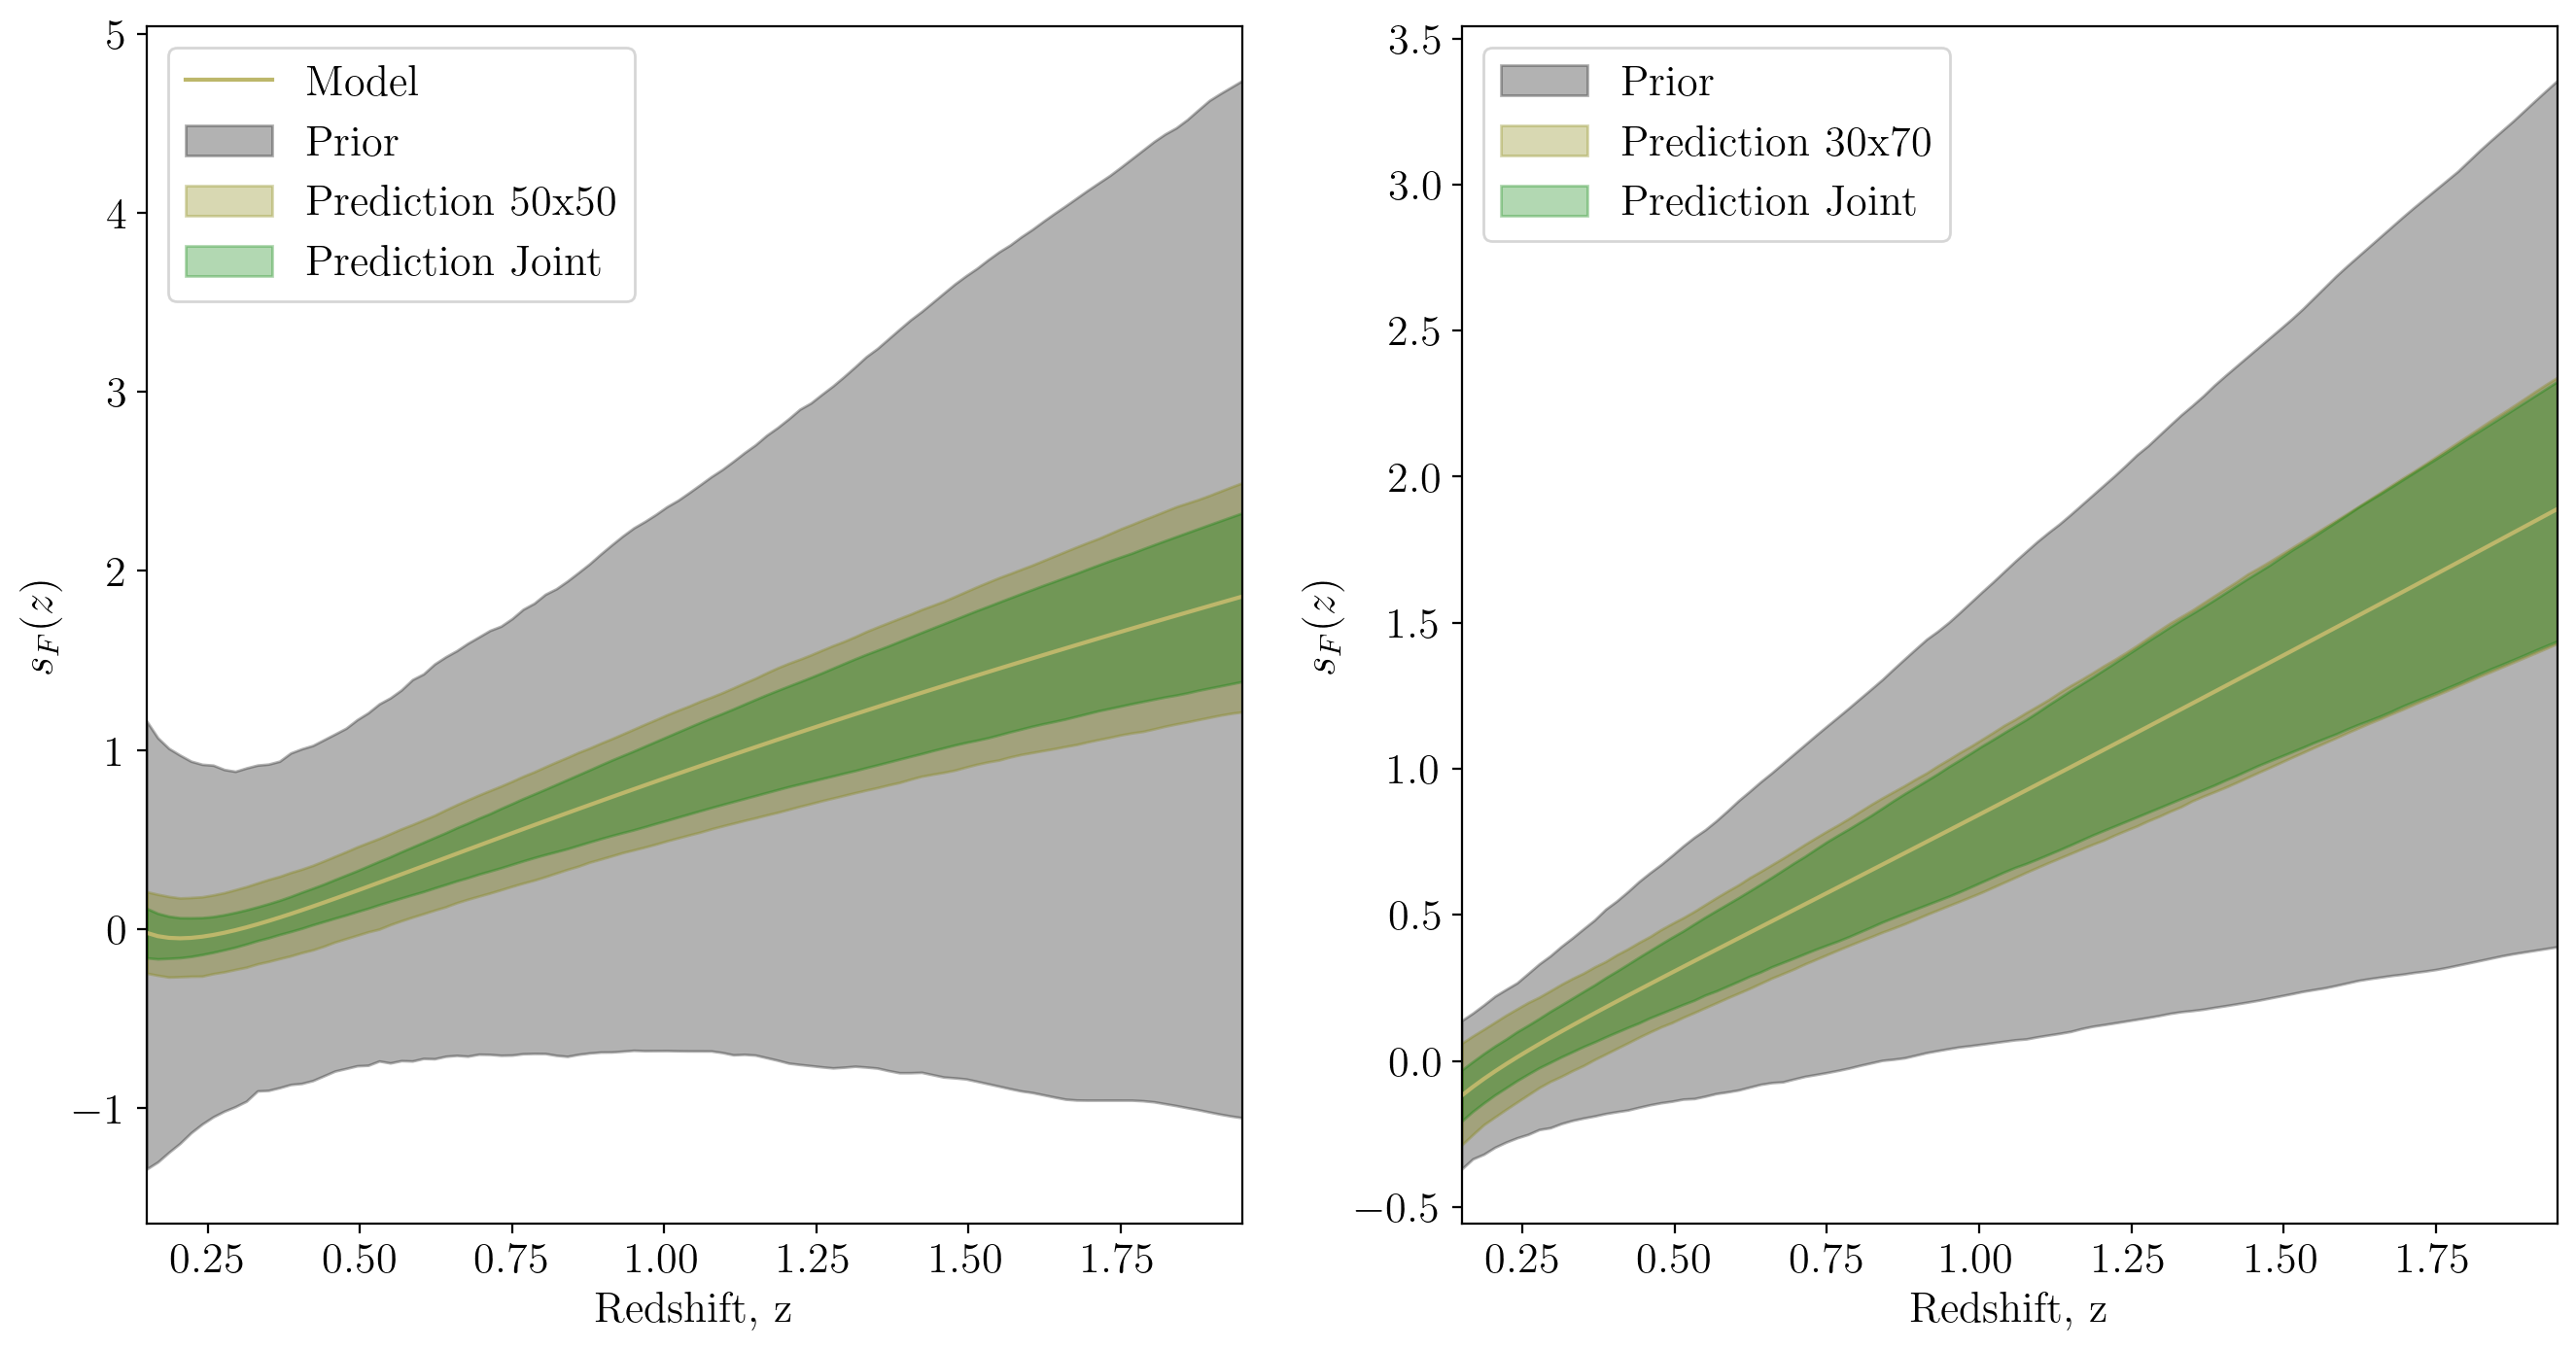

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax[0].plot(z_lin, sF_fid_50, '-', color = 'darkkhaki', label = 'Model')
ax[0].fill_between(z_lin, sF_50_lower_bound_priors_, sF_50_upper_bound_priors_, color='black', alpha=0.3, label = 'Prior')
ax[0].fill_between(z_lin, sF_50_lower_bound, sF_50_upper_bound, color='olive', alpha=0.3, label = 'Prediction 50x50')
ax[0].fill_between(z_lin, sF_50_Joint_lower_bound_, sF_50_Joint_upper_bound_, color='green', alpha=0.3, label = 'Prediction Joint')

ax[1].plot(z_lin, sF_fid_30, '-', color = 'darkkhaki')
ax[1].fill_between(z_lin, sF_30_lower_bound_priors_, sF_30_upper_bound_priors_, color='black', alpha=0.3, label = 'Prior')
ax[1].fill_between(z_lin, sF_30_lower_bound, sF_30_upper_bound, color='olive', alpha=0.3, label = 'Prediction 30x70')
ax[1].fill_between(z_lin, sF_30_Joint_lower_bound_, sF_30_Joint_upper_bound_, color='green', alpha=0.3, label = 'Prediction Joint')


for axi in ax:
    axi.set_xlim(0.15, 1.95)
    axi.set_xlabel(r'Redshift, z')
    axi.set_ylabel(r'$s_F(z)$')
    axi.legend(loc='upper left')

## Evolution bias

The evolution bias is computed from the magnification biases and the evolution of the number densities.

$$ f^{evol}_{B}(z) = -\frac{d\log{N_B(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_B(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) - \frac{5}{2}s_B(z)\,\frac{d\log{F_c}}{d\log{(1+z)}} $$

$$ f^{evol}_{F}(z) = -\frac{d\log{N_F(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_F(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) 
    - \frac{5}{2}\left[\frac{\bar{N}}{\bar{N}_F}\,s_{model}(z)\frac{d\log{F_*}}{d\log{(1+z)}}-\frac{\bar{N}_B}{\bar{N}_F}\,s_B(z)\frac{d\log{F_c}}{d\log{(1+z)}}\right] $$

We have all the ingredients defined as methods in the EvolutionBias class. We need to extract the relevant terms and then sample togeter the $n_{evol}$ and magnification bias parameters to construct the predictions for each evolution bias. 

In [109]:
from biasmodels import EvolutionBias

In [110]:
myEvolBias_50 = EvolutionBias(n_split=m_50)
myEvolBias_30 = EvolutionBias(n_split=m_30)


dlogH = myEvolBias_50.dlogH
rHterm = myEvolBias_50.rHterm
dFstar = myEvolBias_50.dLogFstar
dFcut = myEvolBias_50.dLogFcut

In [111]:
def fevol_bright(pars_s, pars_n, z):
    pars_sB = pars_s[:4] 
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*magbias_fit(params=pars_sB, x=z))*rHterm(z) - 5*magbias_fit(params=pars_sB, x=z) - 5/2*magbias_fit(params=pars_sB, x=z)*dFcut(z)
    
def fevol_faint(pars_s, pars_n, z):
    
    pars_sB = pars_s[:4]
    pars_sM = pars_s[4:]
    s_B = magbias_fit(params=pars_sB, x=z)
    s_M = magbias_fit(params=pars_sM, x=z)
    s_faint = s_M*m_split/(m_split-1) - s_B/(m_split-1)
    
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*s_faint)*rHterm(z) - 5*s_faint + 5/2*((1/(m_split-1)) * s_B *dFcut(z) - (m_split/(m_split-1)) * s_M *dFstar(z))

In [112]:
sbias_fid_50 = np.concatenate([sB_4fit50, sM_4fit])
sbias_fid_30 = np.concatenate([sB_4fit30, sM_4fit])

np.shape(sbias_fid_50), np.shape(sbias_fid_30)

((8,), (8,))

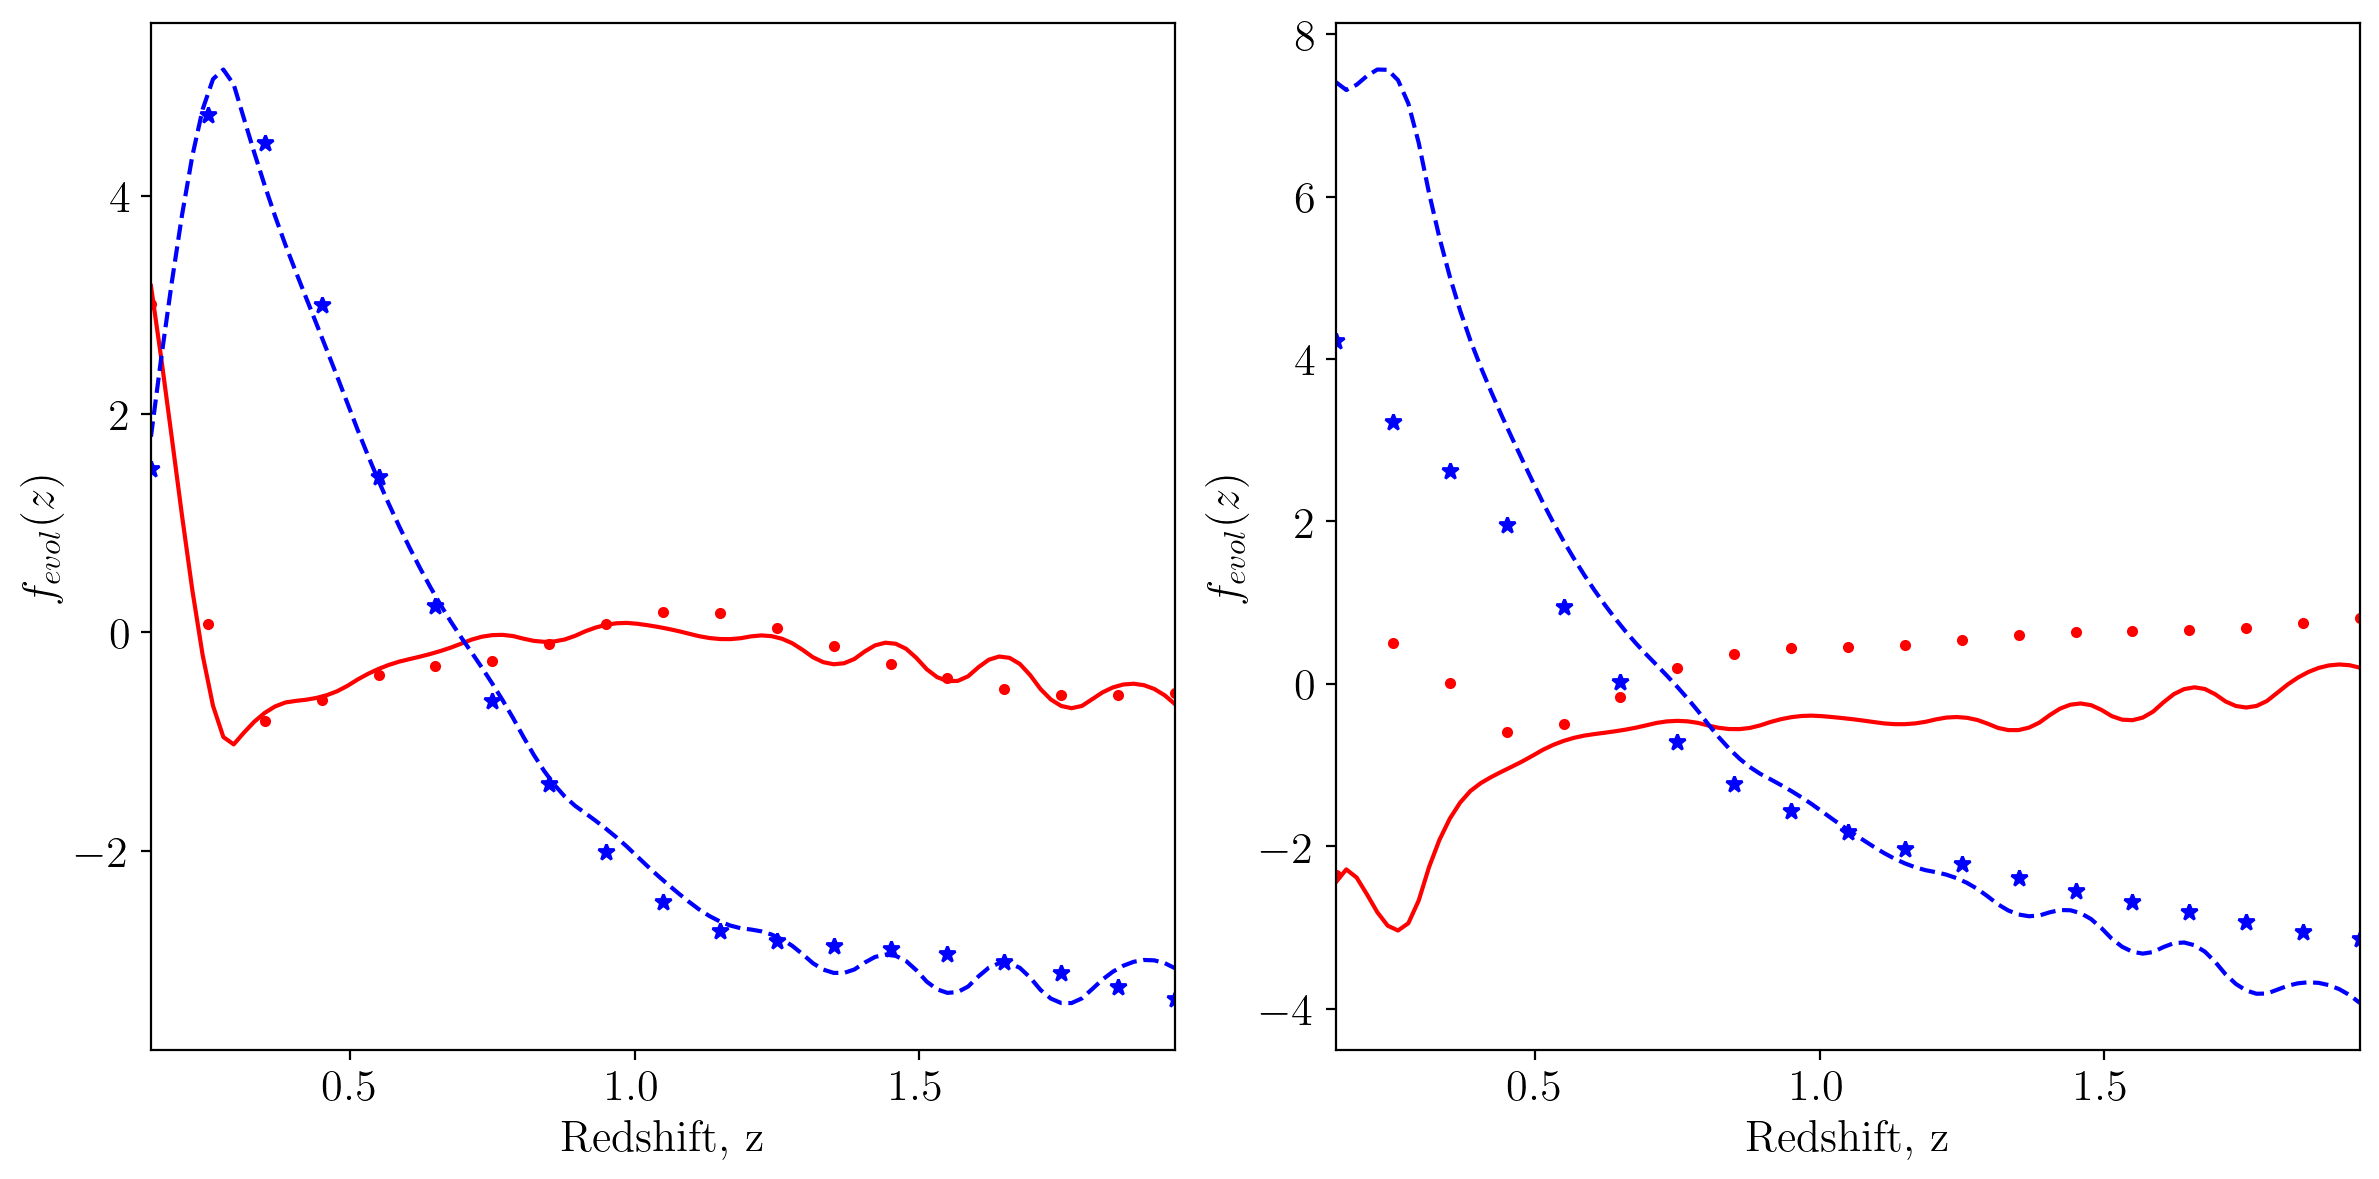

In [113]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

fevol_50_B_fid = fevol_bright(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)
fevol_50_F_fid = fevol_faint(pars_s = sbias_fid_50, pars_n = num_fit, z = z_lin)

fevol_30_B_fid = fevol_bright(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)
fevol_30_F_fid = fevol_faint(pars_s = sbias_fid_30, pars_n = num_fit, z = z_lin)

feB_50 = myEvolBias_50.fevol_bright(z_bins)
feF_50 = myEvolBias_50.fevol_faint(z_bins)

feB_30 = myEvolBias_30.fevol_bright(z_bins)
feF_30 = myEvolBias_30.fevol_faint(z_bins)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, 'r-')
ax[0].plot(z_lin, fevol_50_F_fid, 'b--')
ax[0].plot(z_bins, feB_50, 'r.', label='Bright')
ax[0].plot(z_bins, feF_50, 'b*', label='Faint')

ax[1].plot(z_lin, fevol_30_B_fid, 'r-')
ax[1].plot(z_lin, fevol_30_F_fid, 'b--')
ax[1].plot(z_bins, feB_30, 'r.', label='Bright')
ax[1].plot(z_bins, feF_30, 'b*', label='Faint')

for axi in ax:
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlim(z_bins[0],z_bins[-1])
    axi.set_xlabel(r'Redshift, z');
    axi.set_ylabel(r'$f_{evol}(z)$');

In [114]:
all_50_fid = np.concatenate([sB_4fit50, sM_4fit, num_fit])
all_30_fid = np.concatenate([sB_4fit30, sM_4fit, num_fit])

np.shape(all_50_fid), np.shape(all_30_fid)

((12,), (12,))

In [115]:
# Select the marginalized covariance matrix for the parameters

cov_50_all = Sigma_Matrix_50[:12, :12]
cov_30_all = Sigma_Matrix_30[:12, :12]
cov_50_priors = Cov_priors_50[:12, :12]
cov_30_priors = Cov_priors_30[:12, :12]

# Generate parameter samples from multivariate normal distribution

num_samples = 1000
all_50_pars_samples = np.random.multivariate_normal(all_50_fid, cov_50_all, num_samples)
all_50_pars_samples_priors_ = np.random.multivariate_normal(all_50_fid, cov_50_priors, num_samples)
all_30_pars_samples = np.random.multivariate_normal(all_30_fid, cov_30_all, num_samples)
all_30_pars_samples_priors_ = np.random.multivariate_normal(all_30_fid, cov_30_priors, num_samples)

In [116]:
# Evaluate fitting function for each parameter sample

fevol_50_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples])
fevol_50_B_samples_priors_ = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors_])
fevol_50_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples])
fevol_50_F_samples_priors_ = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_50_pars_samples_priors_])

fevol_30_B_samples = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples])
fevol_30_B_samples_priors_ = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors_])
fevol_30_F_samples = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples])
fevol_30_F_samples_priors_ = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_30_pars_samples_priors_])

# Calculate the 68% confidence intervals

fevol_B_50_lower_bound_ = np.percentile(fevol_50_B_samples, 16, axis=0)
fevol_B_50_upper_bound_ = np.percentile(fevol_50_B_samples, 84, axis=0)
fevol_B_50_lower_bound_priors_ = np.percentile(fevol_50_B_samples_priors_, 16, axis=0)
fevol_B_50_upper_bound_priors_ = np.percentile(fevol_50_B_samples_priors_, 84, axis=0)

fevol_F_50_lower_bound_ = np.percentile(fevol_50_F_samples, 16, axis=0)
fevol_F_50_upper_bound_ = np.percentile(fevol_50_F_samples, 84, axis=0)
fevol_F_50_lower_bound_priors_ = np.percentile(fevol_50_F_samples_priors_, 16, axis=0)
fevol_F_50_upper_bound_priors_ = np.percentile(fevol_50_F_samples_priors_, 84, axis=0)

fevol_B_30_lower_bound_ = np.percentile(fevol_30_B_samples, 16, axis=0)
fevol_B_30_upper_bound_ = np.percentile(fevol_30_B_samples, 84, axis=0)
fevol_B_30_lower_bound_priors_ = np.percentile(fevol_30_B_samples_priors_, 16, axis=0)
fevol_B_30_upper_bound_priors_ = np.percentile(fevol_30_B_samples_priors_, 84, axis=0)

fevol_F_30_lower_bound_ = np.percentile(fevol_30_F_samples, 16, axis=0)
fevol_F_30_upper_bound_ = np.percentile(fevol_30_F_samples, 84, axis=0)
fevol_F_30_lower_bound_priors_ = np.percentile(fevol_30_F_samples_priors_, 16, axis=0)
fevol_F_30_upper_bound_priors_ = np.percentile(fevol_30_F_samples_priors_, 84, axis=0)

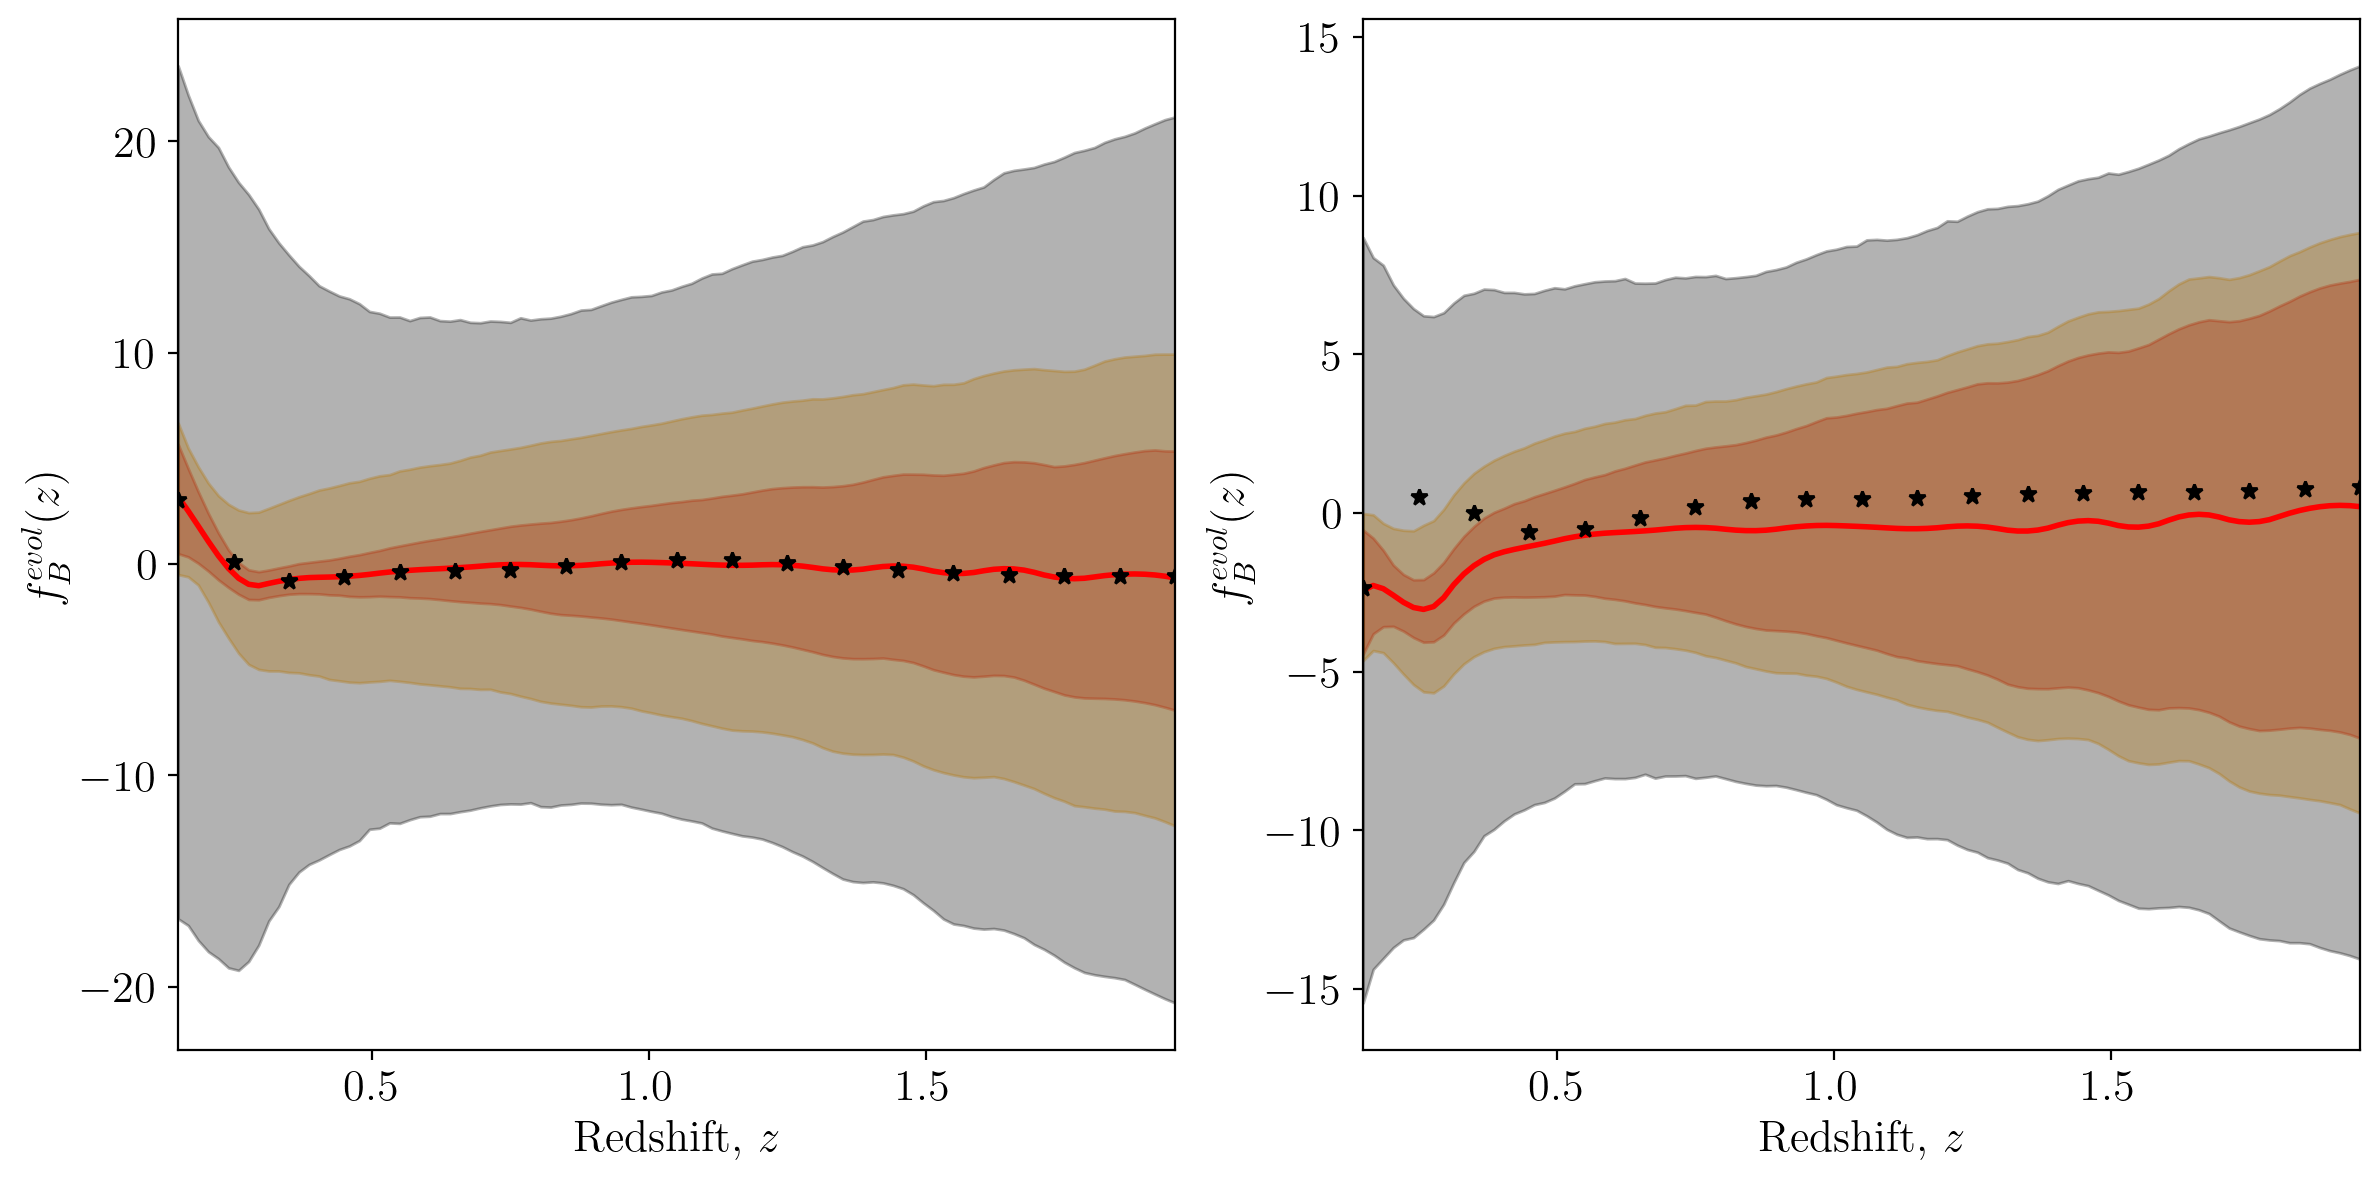

In [117]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_B_fid, '-', color='red', lw = 2.0)
ax[0].plot(z_bins, feB_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_B_fid, '-', color='red', lw = 2.0)
ax[1].plot(z_bins, feB_30, '*', color='black')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, fevol_B_50_lower_bound, fevol_B_50_upper_bound, color='red', alpha=0.3)
ax[0].fill_between(z_lin, fevol_B_50_lower_bound_, fevol_B_50_upper_bound_, color='orange', alpha=0.3)
ax[0].fill_between(z_lin, fevol_B_50_lower_bound_priors, fevol_B_50_upper_bound_priors, color='black', alpha=0.3)

ax[1].fill_between(z_lin, fevol_B_30_lower_bound, fevol_B_30_upper_bound, color='red', alpha=0.3)
ax[1].fill_between(z_lin, fevol_B_30_lower_bound_, fevol_B_30_upper_bound_, color='orange', alpha=0.3)
ax[1].fill_between(z_lin, fevol_B_30_lower_bound_priors, fevol_B_30_upper_bound_priors, color='black', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_B(z)$')

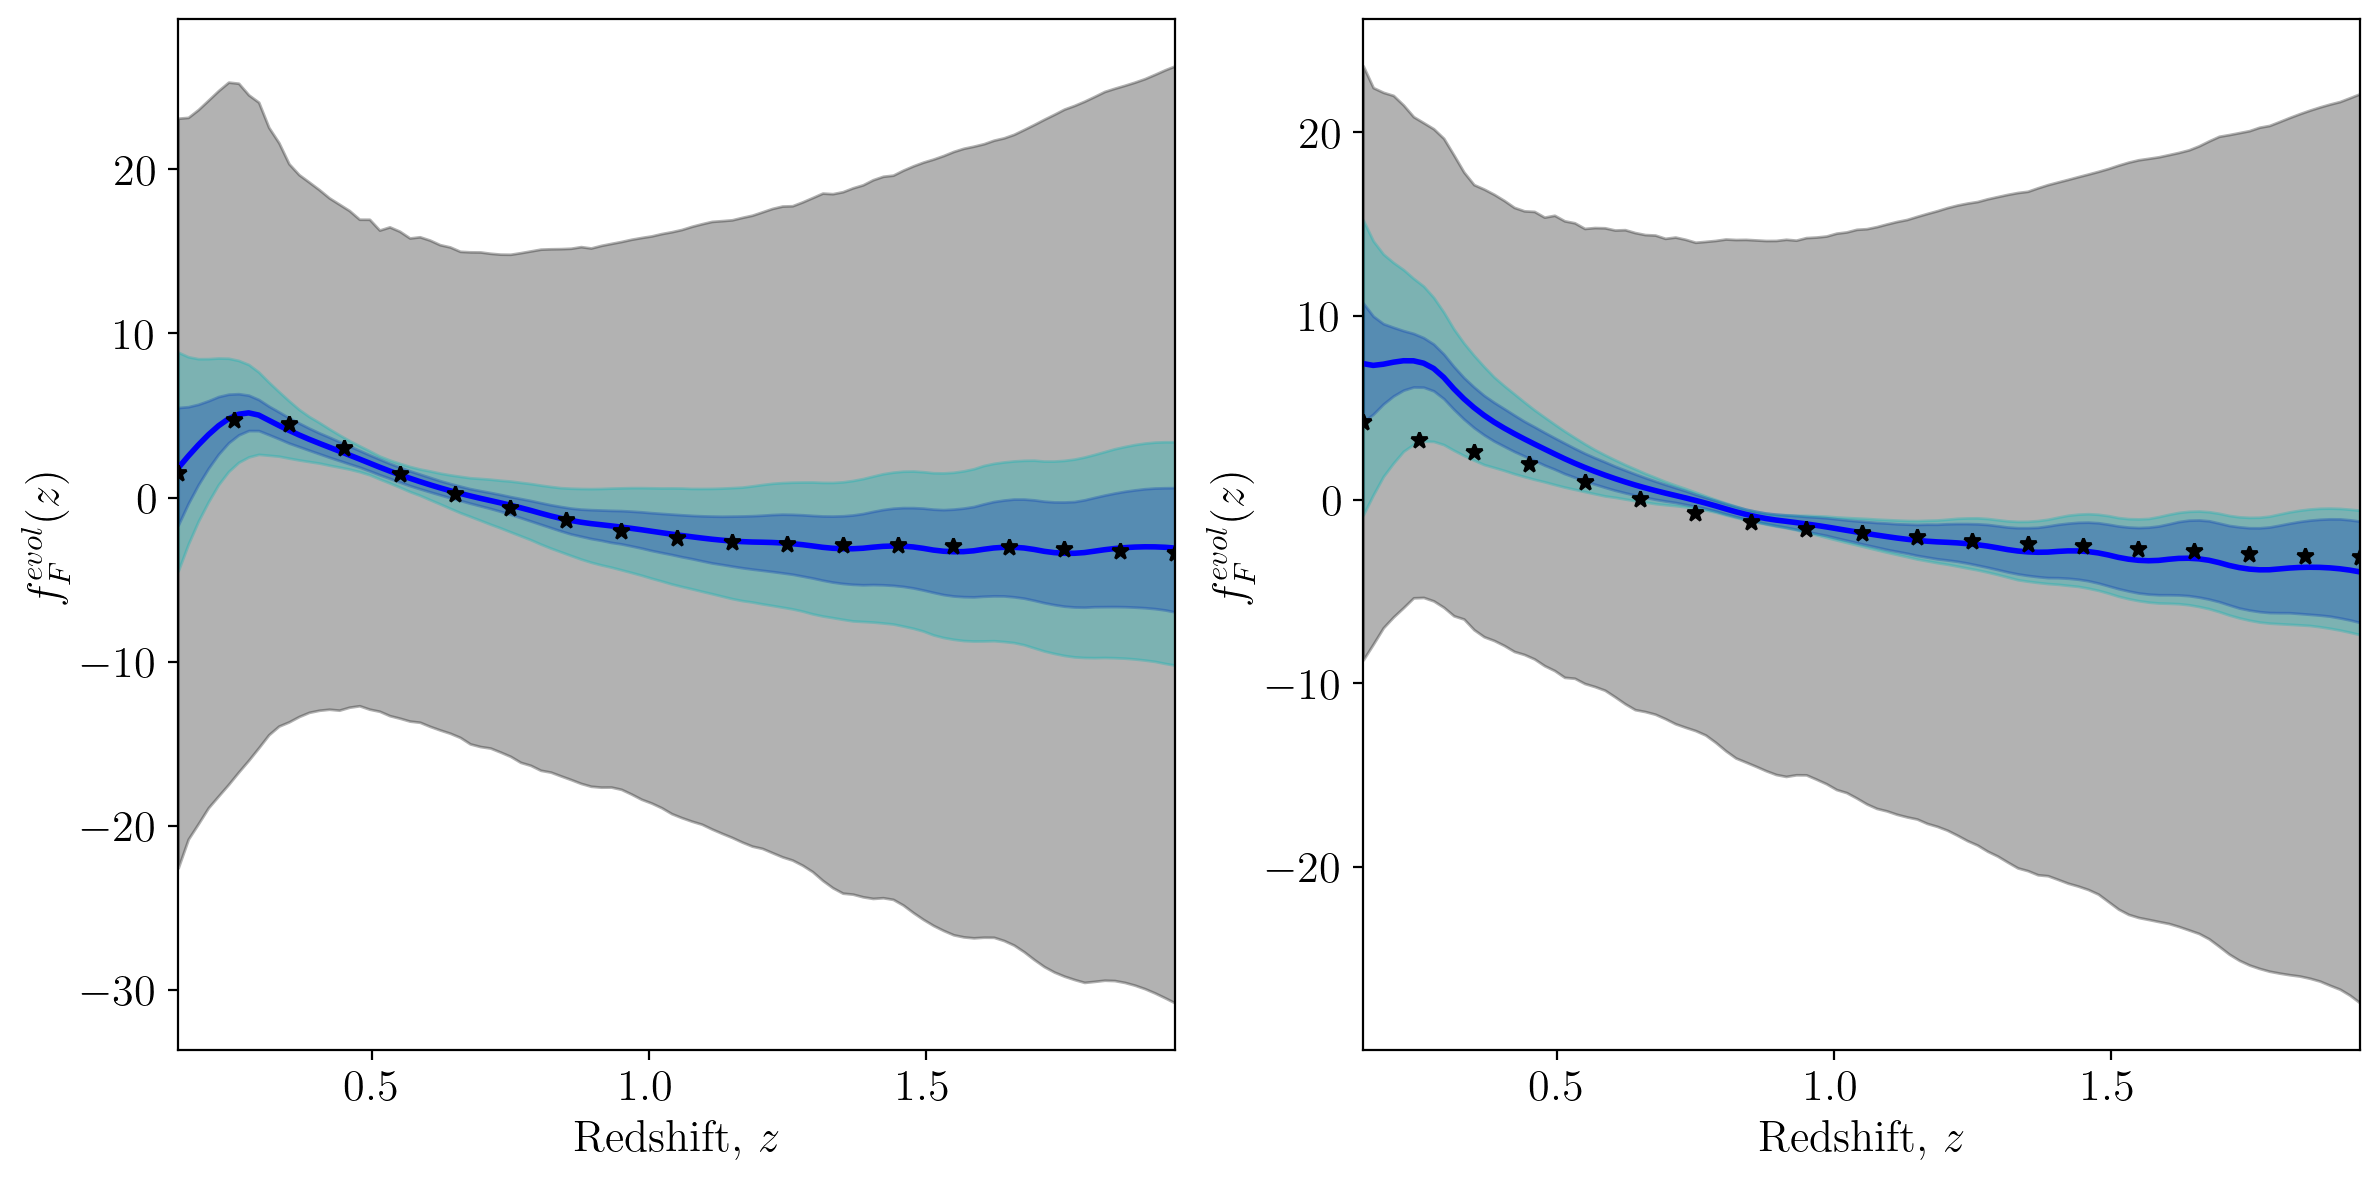

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), tight_layout=True)

ax[0].plot(z_lin, fevol_50_F_fid, '-', color='blue', lw = 2.0)
ax[0].plot(z_bins, feF_50, '*', color='black')
ax[1].plot(z_lin, fevol_30_F_fid, '-', color='blue', lw = 2.0)
ax[1].plot(z_bins, feF_30, '*', color='black')

# Shade the 68% confidence interval

ax[0].fill_between(z_lin, fevol_F_50_lower_bound, fevol_F_50_upper_bound, color='blue', alpha=0.3)
ax[0].fill_between(z_lin, fevol_F_50_lower_bound_, fevol_F_50_upper_bound_, color='cyan', alpha=0.3)
ax[0].fill_between(z_lin, fevol_F_50_lower_bound_priors, fevol_F_50_upper_bound_priors, color='black', alpha=0.3)

ax[1].fill_between(z_lin, fevol_F_30_lower_bound, fevol_F_30_upper_bound, color='blue', alpha=0.3)
ax[1].fill_between(z_lin, fevol_F_30_lower_bound_, fevol_F_30_upper_bound_, color='cyan', alpha=0.3)
ax[1].fill_between(z_lin, fevol_F_30_lower_bound_priors, fevol_F_30_upper_bound_priors, color='black', alpha=0.3)

for axi in ax:
    axi.set_xlim(0.15,1.95)
    axi.set_xlabel(r'Redshift, $z$')
    axi.set_ylabel(r'$f^{evol}_F(z)$')